In [191]:
from astropy.table import Table, vstack
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic
import matplotlib.pyplot as plt
import numpy as np
import matplotlib 
from RegscorePy import *
from collections import OrderedDict
from radial_distribution_funcs import *

from cosmic_calc import * 
from astropy.cosmology import WMAP9

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=20), plt.rc('ytick', labelsize=20)
plt.rcParams['savefig.dpi'] = 100
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)
figure_save_path = 'figures/radial_dist/'

In [3]:
bin_number=14
bin_edges_areas = 10 ** np.linspace(1.0, np.log10(700), num=bin_number + 1)
areas = np.array([])
for i in range(len(bin_edges_areas[:-1])):
    areas = np.append(areas, (bin_edges_areas[i + 1] ** 2 - bin_edges_areas[i] ** 2) * np.pi)


In [199]:
def combine_deep_fields(fields, csfq, ssfq, masscut_low, masscut_high, z, path, sat_z_cut, sample='',bin_number=14,rmax='r200'):
    if isinstance(z,str):
        pass
    elif isinstance(z,float):
        z = str(round(z, 1))
        
    if sample != '': sample+='_'
    affix = '_'+sample+str(sat_z_cut) + '_' +rmax+'_'+ str(masscut_low) + '_' + str(masscut_high) + '_'+ str(csfq) + '_' + str(ssfq) + '_' + z + '.txt'
    
    radial_combine = np.zeros(bin_number)
    radial_err_combine =  np.zeros(bin_number)
    n_fields = []
    for field in fields:
        data_field = np.genfromtxt(path+'count'+field+affix)
            
        split_index = int(((len(data_field)-1)/2)+1)
        n_field = data_field[0]
        radial_field = data_field[1:split_index]
        radial_field_err = data_field[split_index:]
        
        n_fields.append(n_field)
        radial_combine = np.vstack([radial_combine, radial_field])
        radial_err_combine = np.vstack([radial_err_combine, radial_field_err*n_field])
        
    # remove the zeros line
    radial_combine = radial_combine[1:,:]
    radial_err_combine = radial_err_combine[1:,:]
    
    n_tot = sum(n_fields)   
    radial = np.average(radial_combine, axis=0, weights=n_fields)
    radial_err = np.sqrt(sum(radial_err_combine**2))/sum(n_fields)
    return (radial, radial_err, n_tot)

def load_deep(field_name, csfq, ssfq, masscut_low, masscut_high, sat_z_cut, z, path, sample=''):
    if isinstance(z,str):
        pass
    elif isinstance(z,float):
        z = str(round(z, 1))
        
    if sample != '': sample+='_'
            
    affix = '_'+ sample + str(sat_z_cut)+'_'+str(masscut_low)+'_'+str(masscut_high)+'_'+csfq+'_'+ssfq+'_'+str(z)+'.txt'
    field_deep = np.genfromtxt(path+'count'+field_name+affix)
    n_field = int(field_deep[0])
    
    split_index = int(((len(field_deep)-1)/2)+1)
    radial_field = field_deep[1:split_index]
    radial_field_err = field_deep[split_index:]
    return (radial_field, radial_field_err, n_field)


def nfw(r, rs, I):
    x = r / float(rs)
    y = np.piecewise(x, [x < 1, x==1, x > 1],
                     [lambda x:I*(x**2-1)**(-1)*(1-2/np.sqrt(1-x**2)*np.arctanh(np.sqrt((1-x)/(1+x)))), 
                      lambda x:I*1./3, 
                      lambda x:I*(x**2-1)**(-1)*(1-2/np.sqrt(x**2-1)*np.arctan(np.sqrt((x-1)/(1+x))))])
    return y


In [240]:
def fit_nfw(xdata, ydata, ydata_err, start):
    popt,pcov = curve_fit(nfw, xdata[start-1:], ydata[start-1:], sigma=ydata_err[start-1:])
    
    res = ydata - nfw(xdata, *popt)
    chi2 = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2

def sersic(r,Ie,re,n):
#     n=5.5
    b=2*n-1./3
    sersic = Ie * np.exp(-b*((r/float(re))**(1/float(n))-1))
    return sersic

def nfw_sersic(r, rs, I, Ie,re, n):
    sersic_val = sersic(r,Ie,re,n)
    nfw_val = nfw(r,rs,I)
    return nfw_val + sersic_val

def fit_nfw_sersic(xdata, ydata, ydata_err, start,end=-1):
    xdata = xdata[start-1:end]
    ydata = ydata[start-1:end]
    ydata_err = ydata_err[start-1:end]
    popt,pcov = curve_fit(nfw_sersic, xdata, ydata, sigma=ydata_err, p0=[0.1,3e-5,4.2e-5,0.01, 5.5]
                          ,bounds=([0, 0, 0 ,0 ,0],[1, 2e-2, 2e-2, 0.04, 40]),maxfev=10000)
    res = ydata - nfw_sersic(xdata, *popt)
    chi2 = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2

def fit_nfw_sersic_fix_n(xdata, ydata, ydata_err, start,fix_n=0.26):
    xdata = xdata[start-1:]
    ydata = ydata[start-1:]
    ydata_err = ydata_err[start-1:]
    popt,pcov = curve_fit(nfw_sersic, xdata, ydata, sigma=ydata_err, p0=[250,3e-5,4.2e-5,15.1, 0.26]
                          ,bounds=([0, 0, 0 ,0 ,fix_n-0.001],[10000, 2e-2, 2e-2, 300, fix_n+0.001]),maxfev=10000)
    res = ydata - nfw_sersic(xdata, *popt)
    chi2 = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2

def red_frac_err_new(q, All, q_err, all_err):
    return np.sqrt( q_err**2*(1/All)**2 + all_err**2*(q/All**2)**2)


### Total Satellite Sample (all $z$-bins)

In [340]:
sat_z_cut = 1.5
path = 'new_radial_dist_2023/distribution/total_sample_pcat_11.0_'+str(sat_z_cut)+'/'
masscut_low = '9.5'
masscut_high = '12.0'
csfq='all'

bin_number=14
bin_edges = np.load(path+'bin_edges.npy')
# bin_centers = np.load(path+'bin_centers_fixed.npy')
bin_centers_normed = np.load(path+'bin_centers_r200.npy')
    
minus = bin_centers - bin_edges[:-1]
plus = bin_edges[1:] - bin_centers

#### combine redshift bins

In [341]:
field_names = ['COSMOS_deep','DEEP_deep','ELAIS_deep']
for sample in ['','sat','bkg']:
    radial_all = np.zeros(bin_number)
    radial_all_err_square = np.zeros(bin_number)
    radial_ssf = np.zeros(bin_number)
    radial_ssf_err_square = np.zeros(bin_number)
    radial_sq = np.zeros(bin_number)
    radial_sq_err_square = np.zeros(bin_number)
    count_central = 0
    
    for z in [0.2, 0.5, 0.8, 1.1]:
        radial_z_all = combine_deep_fields(field_names, csfq, 'all', masscut_low,masscut_high, z, sat_z_cut=sat_z_cut, path=path, sample=sample, bin_number=bin_number)
        print('No. of centrals',z,radial_z_all[2])
        
        count_central += radial_z_all[2]
        radial_all += radial_z_all[0]*radial_z_all[2]
        radial_all_err_square += radial_z_all[1]**2*radial_z_all[2]**2
            
        radial_z_ssf = combine_deep_fields(field_names,csfq,'ssf', masscut_low,masscut_high, z, sat_z_cut=sat_z_cut, path=path, sample=sample, bin_number=bin_number)
        radial_ssf += radial_z_ssf[0]*radial_z_ssf[2]
        radial_ssf_err_square += radial_z_ssf[1]**2*radial_z_ssf[2]**2
            
        radial_z_sq = combine_deep_fields(field_names,csfq,'sq', masscut_low,masscut_high, z, sat_z_cut=sat_z_cut, path=path, sample=sample, bin_number=bin_number)
        radial_sq += radial_z_sq[0]*radial_z_sq[2]
        radial_sq_err_square += radial_z_sq[1]**2*radial_z_sq[2]**2
        # print(radial_z_all)
        # print(radial_z_ssf)
        # print(radial_z_sq)
        
        if sample != '': 
            sample_show = sample+'_'
        else:
            sample_show = ''
            
        np.savetxt(path+'all_field_'+ sample_show + str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_'+csfq+'_'+ str(z) + '_all'+'.txt', (radial_z_all[0],radial_z_all[1]))
        np.savetxt(path+'all_field_'+ sample_show + str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_'+csfq+'_'+ str(z) + '_ssf'+'.txt', (radial_z_ssf[0],radial_z_ssf[1]))
        np.savetxt(path+'all_field_'+ sample_show + str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_'+csfq+'_'+ str(z) + '_sq'+'.txt', (radial_z_sq[0],radial_z_sq[1]))
    
    radial_all = (radial_all/count_central, np.sqrt(radial_all_err_square)/count_central)
    radial_ssf = (radial_ssf/count_central, np.sqrt(radial_ssf_err_square)/count_central)
    radial_sq = (radial_sq/count_central, np.sqrt(radial_sq_err_square)/count_central)
    print('No. of centrals',count_central)
    
    np.savetxt(path+'all_field_'+ sample_show +str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_'+csfq+'_all'+'.txt', radial_all)
    np.savetxt(path+'all_field_'+ sample_show +str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_'+csfq+'_ssf'+'.txt', radial_ssf)
    np.savetxt(path+'all_field_'+ sample_show +str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_'+csfq+'_sq'+'.txt', radial_sq)

No. of centrals 0.2 2163.0
No. of centrals 0.5 3418.0
No. of centrals 0.8 4672.0
No. of centrals 1.1 5863.0
No. of centrals 16116.0
No. of centrals 0.2 2163.0
No. of centrals 0.5 3418.0
No. of centrals 0.8 4672.0
No. of centrals 1.1 5863.0
No. of centrals 16116.0
No. of centrals 0.2 2163.0
No. of centrals 0.5 3418.0
No. of centrals 0.8 4672.0
No. of centrals 1.1 5863.0
No. of centrals 16116.0


### catalog stats figures

In [ ]:
# central galaxy mass offset



# match with C20



In [ ]:
# load in satellite catalogs





In [ ]:
# mass vs z plot





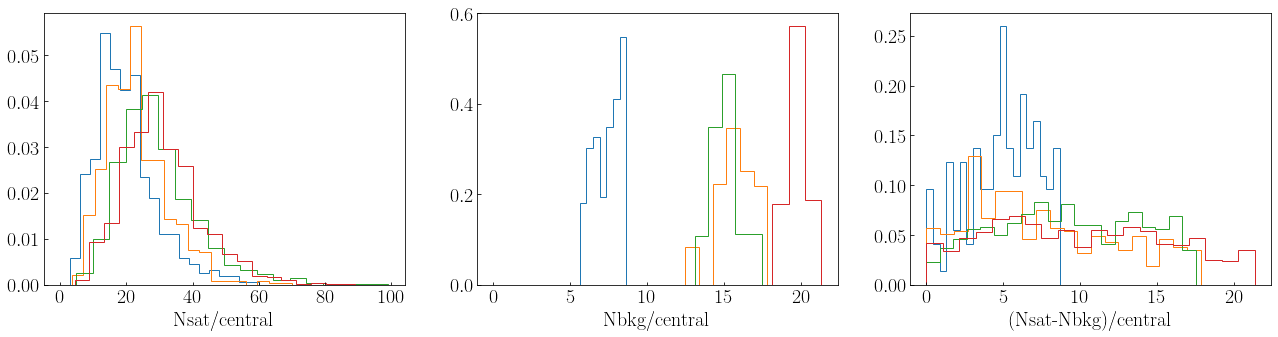

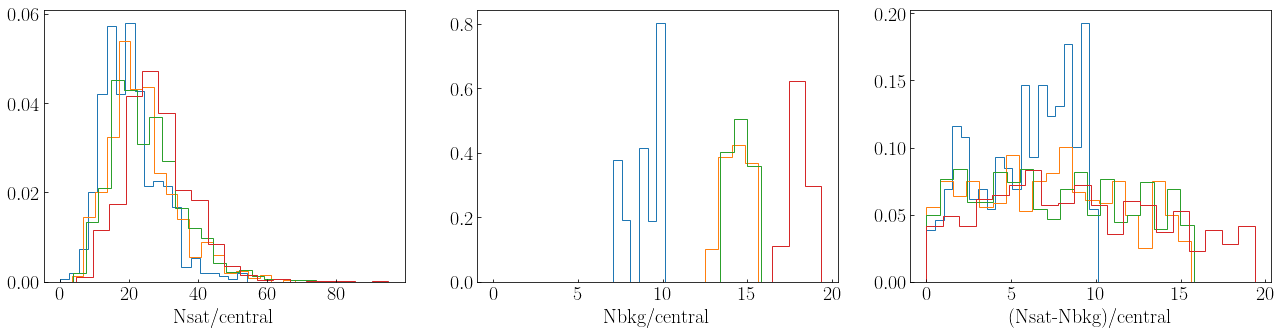

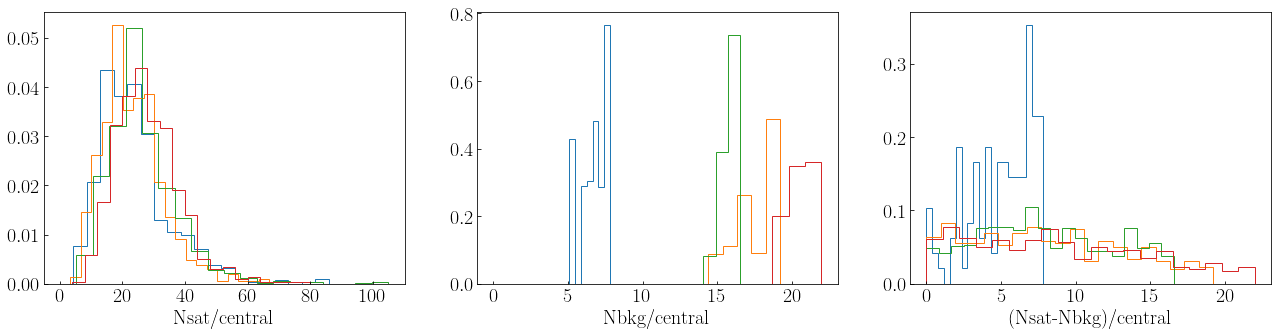

In [193]:
# N/central distribution
hist_show  = ''
for cat_name in ['COSMOS_deep','DEEP_deep','ELAIS_deep']:
    fig, axs = plt.subplots(1, 3, figsize=(22, 5))
    for z in [0.2, 0.5, 0.8, 1.1]:
        cat = Table.read('new_radial_dist_2023/central_cat/isolated_'+cat_name+'_1.5_11.0_'+str(z)+'_massive.positions.fits')
        
        if hist_show == 'volume_norm':
            volumes_central = []
            for gal in cat:
                # cylinder volume
                z_sat_high = gal['Z_COMBINE'] + sat_z_cut * 0.06 * (1 + gal['Z_COMBINE'])
                z_sat_low = gal['Z_COMBINE'] - sat_z_cut * 0.06 * (1 + gal['Z_COMBINE'])
            
                z_test_bin_size = (z_sat_high - z_sat_low)/10
                volume_cylinder = 0
                for z_test in np.arange(z_sat_low,z_sat_high,z_test_bin_size):
                    volume = ( cosmic_calc(z_test+z_test_bin_size) - cosmic_calc(z_test) )*1e9 # in Mpc^3
                    radius_radians = 0.7/ WMAP9.angular_diameter_distance(z_test).value # radian radius at redshift of the central galaxy
                    solid_angle = np.pi*radius_radians**2
                    total_solid_angle = 4*np.pi 
                    volume_cylinder += volume*solid_angle/total_solid_angle
                volumes_central.append(volume_cylinder)
            norm = volumes_central
        else:
            norm = np.ones(len(cat))
        
        axs[0].hist(cat['n_sat']/norm, histtype='step',range=(0,max(cat['n_sat']/norm)),bins=20,density=True)
        axs[1].hist(cat['n_bkg']/norm, histtype='step',range=(0,max(cat['n_bkg']/norm)),bins=20,density=True)
        axs[2].hist((cat['n_sat']-cat['n_bkg'])/norm, histtype='step',range=(0,max(cat['n_bkg']/norm)),bins=20,density=True)
        
    axs[0].set_xlabel('Nsat/central', fontsize=20)
    axs[1].set_xlabel('Nbkg/central', fontsize=20)
    axs[2].set_xlabel('(Nsat-Nbkg)/central', fontsize=20)

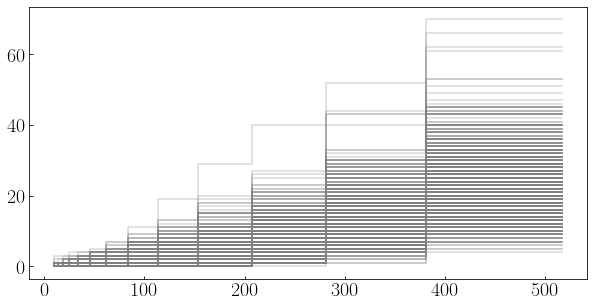

In [189]:
# cumulative sat distribution
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(10, 5))
central_cat = Table.read('new_radial_dist_2023/central_cat/isolated_COSMOS_deep_1.5_11.0_0.6_massive.positions.fits')

for gal in central_cat:
    sat_dist = gal['sat_dist']
    cum_sum = np.cumsum(sat_dist*areas)
    plt.step(bin_edges_areas[:-1],cum_sum,color='grey',alpha=0.3)

In [ ]:
#### size of R200



### Results Figures

[[8.424e-05 8.622e-05 8.627e-05 6.449e-05 4.236e-05 3.265e-05 2.739e-05
  1.886e-05 1.477e-05 1.036e-05 8.209e-06 5.956e-06 4.823e-06 3.982e-06]
 [9.837e-06 6.868e-06 4.846e-06 3.140e-06 2.016e-06 1.414e-06 9.987e-07
  6.851e-07 4.841e-07 3.425e-07 2.456e-07 1.771e-07 1.291e-07 9.441e-08]]
[[8.424e-05 8.622e-05 8.627e-05 6.449e-05 4.236e-05 3.265e-05 2.739e-05
  1.886e-05 1.477e-05 1.036e-05 8.209e-06 5.956e-06 4.823e-06 3.982e-06]
 [9.837e-06 6.868e-06 4.846e-06 3.140e-06 2.016e-06 1.414e-06 9.987e-07
  6.851e-07 4.841e-07 3.425e-07 2.456e-07 1.771e-07 1.291e-07 9.441e-08]]
nfw+sersic [7.135e-01 1.182e-05 3.564e-05 4.000e-02 3.484e+00] [4.259e-01 8.162e-06 8.286e-05 5.512e-02 1.416e+01] 4.228355200519952
[[6.902e-05 7.298e-05 6.954e-05 4.958e-05 3.296e-05 2.423e-05 2.109e-05
  1.423e-05 1.133e-05 8.032e-06 6.360e-06 4.672e-06 3.873e-06 3.177e-06]
 [9.431e-06 6.571e-06 4.511e-06 2.869e-06 1.848e-06 1.276e-06 9.159e-07
  6.298e-07 4.473e-07 3.190e-07 2.295e-07 1.657e-07 1.214e-07 8.872e

/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


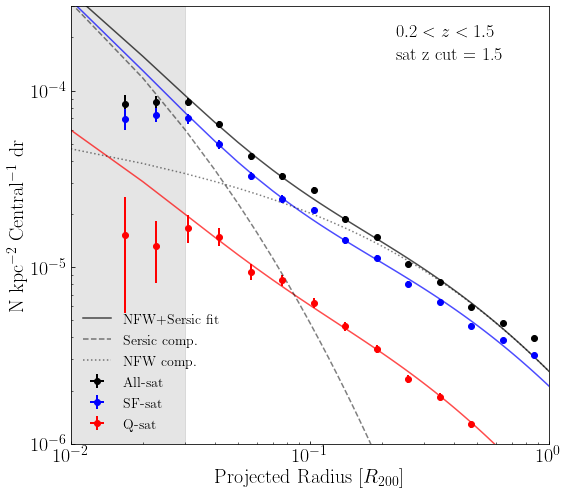

In [355]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))
path = 'new_radial_dist_2023/distribution/total_sample_pcat_11.0_1.5/'

r_scale='r200'

start=3
color=['k','b','r']
sat_type = ['All','SF','Q']
if r_scale=='r200':
    fit_x = np.linspace(0.01,1,num=100)
    bins_plot = bin_centers_normed
else:
    fit_x = np.linspace(2,700,num=100)
    bins_plot = bin_centers

count_radial_allz = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ 'all'+'.txt')
count_radial_sf_allz = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ 'ssf'+'.txt')
count_radial_q_allz = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ 'sq'+'.txt')
print(count_radial_allz)

########
for i, radial in enumerate([count_radial_allz,count_radial_sf_allz,count_radial_q_allz]):
    label='NFW+Sersic fit' if i==0 else ''
    print(radial)
    plt.errorbar(bins_plot, radial[0],yerr=radial[1],xerr=0,fmt='o'+color[i],label=sat_type[i]+'-sat',linewidth=2)
    
    popt_allz,pcov_allz,chi2_allz = fit_nfw_sersic(bins_plot,radial[0],radial[1], start,-1)
    perr_allz = np.sqrt(np.diag(pcov_allz))
    print('nfw+sersic',popt_allz,perr_allz,chi2_allz/(len(bins_plot)-start+1 - len(popt_allz)))
    plt.plot(fit_x,nfw_sersic(fit_x, popt_allz[0],popt_allz[1],popt_allz[2],popt_allz[3],popt_allz[4]),color[i],alpha=0.7,label=label)
        
popt_allz,pcov_allz,chi2_allz = fit_nfw_sersic(bins_plot,count_radial_allz[0],count_radial_allz[1], start)
plt.plot(fit_x,sersic(fit_x, popt_allz[2],popt_allz[3],popt_allz[4]),'--k',alpha=0.5,label='Sersic comp.')
plt.plot(fit_x,nfw(fit_x,popt_allz[0],popt_allz[1]),':k',alpha=0.5,label='NFW comp.')

# prediction of rs from DM mass distribution 
# median central mass --> halo mass --> rs
# rs_range1 = [647] # m_h from Leathaud et al. 2012
# rs_range2 = [156] # m_h from Coupon et al. 2015
# references = ['Leathaud+2012\&Ludlow+2014','Coupon+2015\&Ludlow+2014']
# colors = ['g','y']
# norm_to_value = nfw_sersic(bin_centers[-1], popt_allz[0],popt_allz[1],popt_allz[2],popt_allz[3],popt_allz[4])
# for i,rs_range in enumerate([rs_range1,rs_range2]):
#     for j,rs in enumerate(rs_range):
#         norm_guess = 1e-4
#         norm = norm_guess/(nfw(fit_x,rs,norm_guess)[-10]/norm_to_value)
#         plt.plot(fit_x,nfw(fit_x,rs,norm),':'+colors[i],linewidth=2,label=references[i] if j==0 else'')
        
plt.annotate(r'$0.2<z<1.5$',xy=([0.68,0.93]),xycoords='axes fraction',fontsize=18,color='k')
plt.annotate('sat z cut = '+str(sat_z_cut),xy=([0.68,0.88]),xycoords='axes fraction',fontsize=18,color='k')
# plt.annotate(sfq_method.replace('_',' '),xy=([0.68,0.82]),xycoords='axes fraction',fontsize=18,color='k')

plt.axvspan(0.01, 0.03, alpha=0.1, color='k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.01,1])
plt.ylim([1e-6,3e-4])
plt.xlabel('Projected Radius [$R_{200}$]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.legend(fontsize=14,frameon=False,loc='lower left')
plt.tight_layout()
plt.savefig(figure_save_path+'number_density_allz.png')


new_radial_dist_2023/distribution/total_sample_pcat_11.0_1.5/


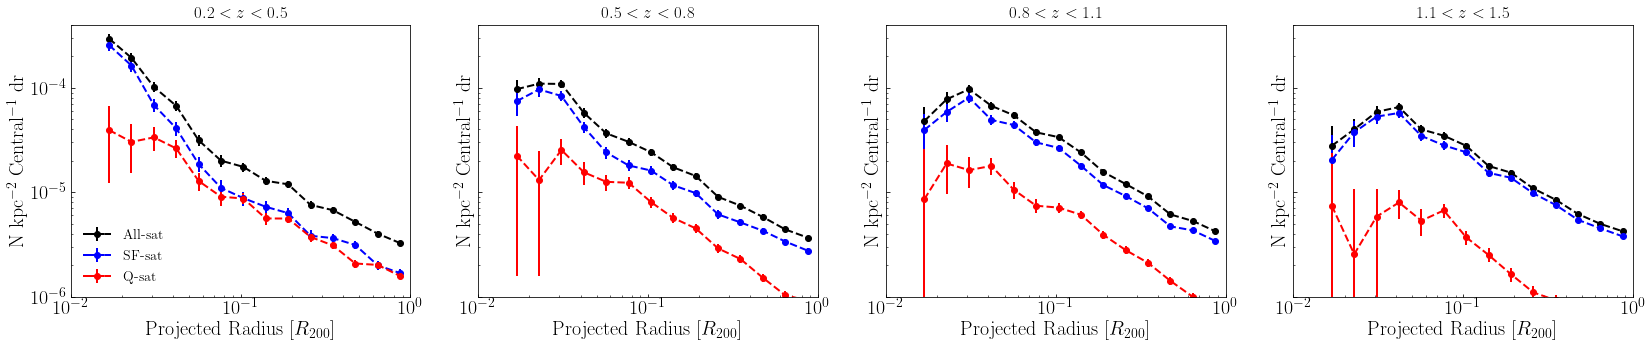

In [343]:
fig, axs = plt.subplots(1, 4, sharex=True,sharey='row', figsize=(28, 5))
color=['k','b','r']
sat_type = ['All','SF','Q']

z_mins = [0.2,0.5,0.8,1.1]
z_maxs = [0.5,0.8,1.1,1.5]

print(path)
for z_idx,z in enumerate([0.2, 0.5, 0.8, 1.1]): 
    count_radial_z = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ str(z) +'_all'+'.txt')
    count_radial_sf_z = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ str(z) +'_ssf'+'.txt')
    count_radial_q_z = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ str(z) +'_sq'+'.txt')
    for i, radial in enumerate([count_radial_z, count_radial_sf_z, count_radial_q_z]):
        axs[z_idx].errorbar(bin_centers_normed, radial[0],yerr=radial[1],xerr=0,fmt='o--'+color[i],label=sat_type[i]+'-sat',linewidth=2)

    axs[z_idx].set_xscale('log')
    axs[z_idx].set_yscale('log')
    axs[z_idx].set_xlim([0.01,1])
    axs[z_idx].set_ylim([1e-6,4e-4])
    
    axs[z_idx].set_title(r'$'+str(z_mins[z_idx])+'<z<'+str(z_maxs[z_idx])+'$',fontsize=17)
    axs[z_idx].set_xlabel('Projected Radius [$R_{200}$]', fontsize=20)
    axs[z_idx].set_ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
    axs[0].legend(fontsize=14,frameon=False,loc='lower left')


[1.226e-05 1.226e-05 1.226e-05 1.226e-05 1.226e-05 1.226e-05 1.226e-05
 1.226e-05 1.226e-05 1.226e-05 1.226e-05 1.226e-05 1.226e-05 1.226e-05]
[1.449e-05 1.449e-05 1.449e-05 1.449e-05 1.449e-05 1.449e-05 1.449e-05
 1.449e-05 1.449e-05 1.449e-05 1.449e-05 1.449e-05 1.449e-05 1.449e-05]
[1.632e-05 1.632e-05 1.632e-05 1.632e-05 1.632e-05 1.632e-05 1.632e-05
 1.632e-05 1.632e-05 1.632e-05 1.632e-05 1.632e-05 1.632e-05 1.632e-05]
[2.076e-05 2.076e-05 2.076e-05 2.076e-05 2.076e-05 2.076e-05 2.076e-05
 2.076e-05 2.076e-05 2.076e-05 2.076e-05 2.076e-05 2.076e-05 2.076e-05]


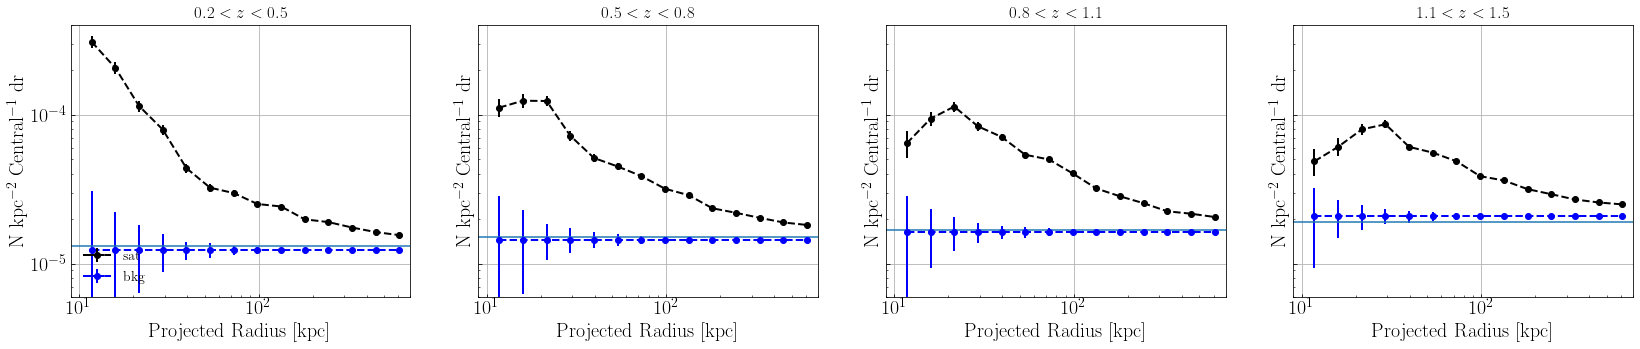

In [353]:
# sat / bkg distribution

fig, axs = plt.subplots(1, 4, sharex=True,sharey='row', figsize=(28, 5))
expected_bkgs = [1.31e-05,1.52e-05,1.67e-05,1.9e-05] # from field SMF esitmates

start=4
color=['k','b','r']
sat_type = ['All','SF','Q']

for z_idx,z in enumerate([0.2, 0.5, 0.8, 1.1]): 
    count_radial_z = np.genfromtxt(path  + 'all_field_sat_' + str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ str(z) +'_all'+'.txt')
    count_radial_z_bkg = np.genfromtxt(path + 'all_field_bkg_' + str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ str(z) +'_all'+'.txt')
    print(count_radial_z_bkg[0])
        
    axs[z_idx].errorbar(bin_centers, count_radial_z[0],yerr=count_radial_z[1],xerr=0,fmt='ok--',label='sat',linewidth=2)
    axs[z_idx].errorbar(bin_centers, count_radial_z_bkg[0],yerr=count_radial_z_bkg[1],xerr=0,fmt='ob--',label='bkg',linewidth=2)
    axs[z_idx].plot([9,700],[expected_bkgs[z_idx],expected_bkgs[z_idx]])
    
    axs[z_idx].set_xscale('log')
    axs[z_idx].set_yscale('log')
    axs[z_idx].set_xlim([9,700])
    axs[z_idx].set_ylim([6e-6,4e-4])
    axs[z_idx].set_title(r'$'+str(z_mins[z_idx])+'<z<'+str(z_maxs[z_idx])+'$',fontsize=17)
    axs[z_idx].grid()
    
    axs[z_idx].set_xlabel('Projected Radius [kpc]', fontsize=20)
    axs[z_idx].set_ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
    axs[0].legend(fontsize=14,frameon=False,loc='lower left')

OSError: new_radial_dist_2023/distribution/total_sample_test_pcat_11.2_1.5/all_field_sat_1.5_9.5_12.0_all_0.2_all.txt not found.

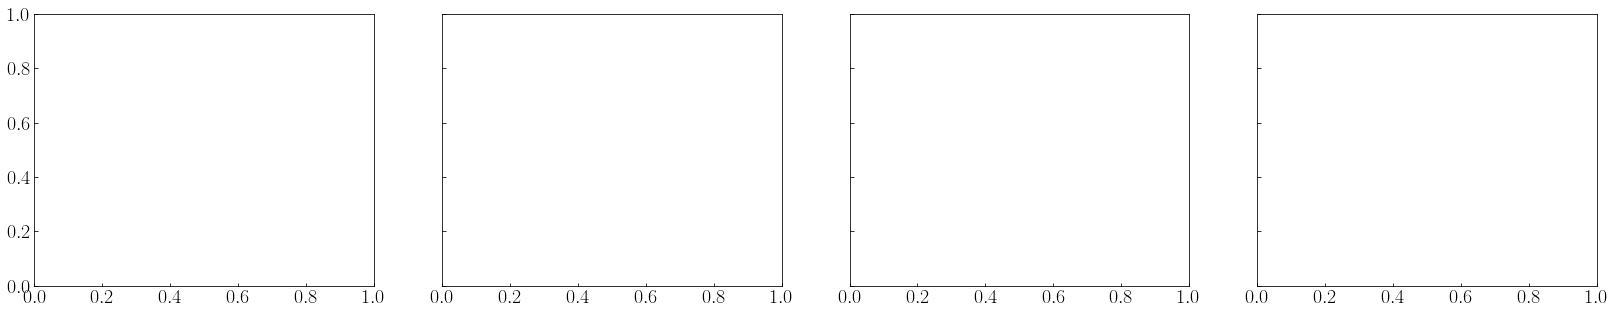

In [351]:
# sat / bkg distribution
path1 = 'new_radial_dist_2023/distribution/total_sample_test_pcat_11.2_'+str(sat_z_cut)+'/'
path2 = 'new_radial_dist_2023/distribution/total_sample_test_pcat_11.0_'+str(sat_z_cut)+'/'

fig, axs = plt.subplots(1, 4, sharex=True,sharey='row', figsize=(28, 5))
expected_bkgs = [1.31e-05,1.52e-05,1.67e-05,1.9e-05]
z_mins = [0.2,0.5,0.8,1.1]
z_maxs = [0.5,0.8,1.1,1.5]

start=4
color=['k','b','r']
sat_type = ['All','SF','Q']

for z_idx,z in enumerate([0.2, 0.5, 0.8, 1.1]): 
    count_radial_z = np.genfromtxt(path1  + 'all_field_sat_' + str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ str(z) +'_all'+'.txt')
    count_radial_z_bkg = np.genfromtxt(path2 + 'all_field_sat_' + str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ str(z) +'_all'+'.txt')
    print(count_radial_z_bkg[0])
        
    axs[z_idx].errorbar(bin_centers, count_radial_z[0],yerr=count_radial_z[1],xerr=0,fmt='ok--',label='sat',linewidth=2)
    axs[z_idx].errorbar(bin_centers, count_radial_z_bkg[0],yerr=count_radial_z_bkg[1],xerr=0,fmt='ob--',label='bkg',linewidth=2)
    axs[z_idx].plot([9,700],[expected_bkgs[z_idx],expected_bkgs[z_idx]])
    
    axs[z_idx].set_xscale('log')
    axs[z_idx].set_yscale('log')
    axs[z_idx].set_xlim([9,700])
    axs[z_idx].set_ylim([6e-6,4e-4])
    axs[z_idx].set_title(r'$'+str(z)+'<z<'+str(round(z+0.1,1))+'$',fontsize=17)
    
    axs[z_idx].set_xlabel('Projected Radius [kpc]', fontsize=20)
    axs[z_idx].set_ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
    axs[0].legend(fontsize=14,frameon=False,loc='lower left')

#### redshift evolution

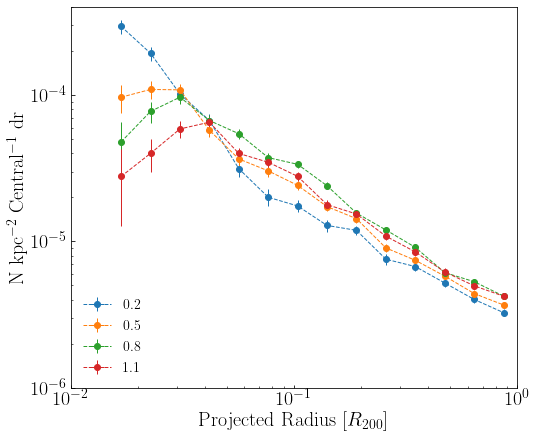

In [350]:
fig, ax = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))

start=4
color=['k','b','r']
sat_type = ['All','SF','Q']

# adjust = [0,2e-6,0,0]

for z_idx,z in enumerate([0.2, 0.5, 0.8, 1.1]):
    radial = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ str(z) +'_all'+'.txt')
    ax.errorbar(bin_centers_normed, radial[0],yerr=radial[1],xerr=0,fmt='o--',linewidth=1,label=str(z))
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.01,1])
ax.set_ylim([1e-6,4e-4])
ax.set_xlabel('Projected Radius [$R_{200}$]', fontsize=20)
ax.set_ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
ax.legend(fontsize=14,frameon=False,loc='lower left')


evolving mass cut for centrals
artificial test catalog
start with look at N/central and bkg level (centrals catalog)

mnassive gals z<1.5

PDZs of Guillaume's galaxies(include irac detection)
recompute redshift with Guillaume's PDZ 

go to C20, compare z_G and z_C20, check PDZ (bimodal?) and my redshift for massive galaxies (those who changed massses, or not)
bring in IRAC information? check i-IRAC color! mass cut M>[11.0]
also just plot irac vs z_G_6B (or z_ML)

comptute SMF for Guillaume's catalog !!!
also SMF for 6band photometry

Z_BEST distribution

my mass function is lower --> maybe redshift problem --> use pcat redshifts --> avoid pcat z-problems because of lack of IRAC (meaning massive gals may be not estimated correctly) --> modify some of the pcat redshifts --> maybe rerun phosphoros for some of the galaxies (massive ones)

In [3]:
from regions import DS9Parser, read_ds9
from regions import PixCoord, CirclePixelRegion,RectanglePixelRegion, PolygonPixelRegion,EllipsePixelRegion, PolygonSkyRegion

# megacam, hsc, vircam
cosmos_reg_filelist = ['MegaCam_u_cosmos.reg','HSC_cosmos.reg']
xmm_reg_filelist = ['MegaCam_uS_deep_xmm.reg','HSC_xmm.reg']
elais_reg_filelist = ['MegaCam_u_elais.reg','HSC_elais.reg']
deep_reg_filelist = ['MegaCam_u_deep2.reg','HSC_deep2.reg']

# ra_min, ra_max, dec_min, dec_max
cosmos_radec_lim = [148,152,0.5,3.8]
xmm_radec_lim = [33,38.5,-7,-3]
elais_radec_lim = [239.5,246,53,57]
deep_radec_lim = [354,350,-2,1.5]

field_lim_list = [cosmos_radec_lim, xmm_radec_lim, elais_radec_lim, deep_radec_lim]
field_name_list = ['E-COSMOS','XMM-LSS','ELAIS-N1','DEEP2-3']
field_name_infile = ['COSMOS','XMM-LSS','ELAIS','DEEP']
filter_list =['$U$','HSC']

smf_pcat/test_smf_cenmass_test_Feb24_11.2_11.5/COSMOS_deep_cen_11.2_0.2.fits
smf_pcat/test_smf_cenmass_test_Feb24_11.2_11.5/XMM-LSS_deep_cen_11.2_0.2.fits
smf_pcat/test_smf_cenmass_test_Feb24_11.2_11.5/ELAIS_deep_cen_11.2_0.2.fits
smf_pcat/test_smf_cenmass_test_Feb24_11.2_11.5/DEEP_deep_cen_11.2_0.2.fits


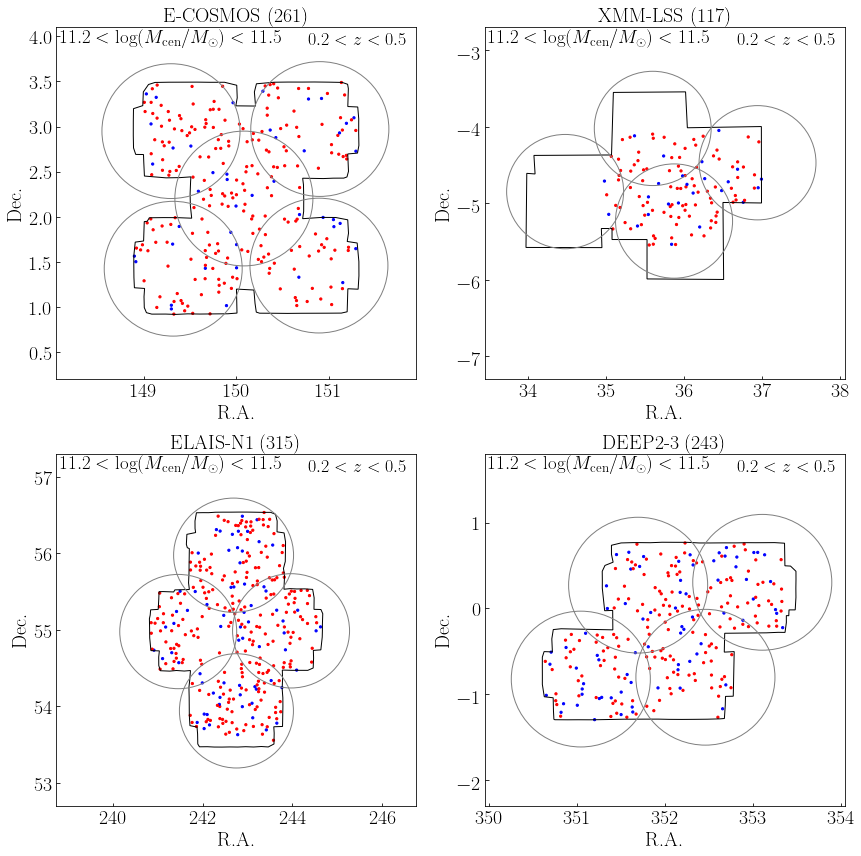

In [112]:
fig, axs = plt.subplots(2, 2, figsize = (12, 12))
colors = ['k','grey']
z_mins = [0.2,0.5,0.8,1.1]
z_maxs = [0.5,0.8,1.1,1.5]
z_idx = 0
masscut_host=11.2
masscut_host_high=11.5
path = 'smf_pcat/test_smf_cenmass_test_Feb24_'+str(masscut_host)+'_'+str(masscut_host_high)+'/'
for field_num, field_reg_list in enumerate([cosmos_reg_filelist, xmm_reg_filelist, elais_reg_filelist,deep_reg_filelist]):
    row = field_num // 2
    col = field_num % 2
    for i,filename in enumerate(field_reg_list):
        file = open('../regions/'+filename)
        lines = file.readlines()
        
        if '_u_' in filename or '_uS_' in filename:
            color=colors[0]
        else:
            color=colors[1]
            
        for line in lines:
            if 'polygon' in line:
                line = 'wcs; fk5\n '+line.rstrip()
                region = DS9Parser(line).shapes.to_regions()[0]
                vertices = region.vertices
                pixel_vertex_x = []
                pixel_vertex_y = []
                for vertex in vertices:
                    pixel_vertex_x.append(vertex.ra.value)
                    pixel_vertex_y.append(vertex.dec.value)
                    pixel_region = PolygonPixelRegion(vertices=PixCoord(x=pixel_vertex_x, y=pixel_vertex_y))
                
                artist = pixel_region.as_artist(edgecolor=color,fill=False)     
                axs[row][col].add_artist(artist)
            
            elif 'circle' in line:
                line = 'wcs; fk5\n '+line.rstrip()
                region = DS9Parser(line).shapes.to_regions()[0]
                x = region.center.ra.value
                y = region.center.dec.value
                pixel_center = PixCoord(x=x, y=y)
                pixel_ra_axis = region.radius.value/np.cos(region.center.dec.value/180*np.pi)/3600
                pixel_dec_axis = region.radius.value/3600
                pixel_region = EllipsePixelRegion(pixel_center, pixel_ra_axis*2,pixel_dec_axis*2)
            
                artist = pixel_region.as_artist(edgecolor=color,fill=False)        
                axs[row][col].add_artist(artist)
                
            elif 'box' in line:
                line = 'wcs; fk5\n '+line.rstrip()
                region = DS9Parser(line).shapes.to_regions()[0]
                x = region.center.ra.value
                y = region.center.dec.value
                pixel_center = PixCoord(x=x, y=y)
                pixel_height = region.height.value/3600
                pixel_width = region.width.value/3600
                pixel_region = RectanglePixelRegion(center=pixel_center, width=pixel_width,height=pixel_height)
            
                artist = pixel_region.as_artist(edgecolor=color,fill=False)        
                axs[row][col].add_artist(artist)
    
    ra_min = field_lim_list[field_num][0]-0.3
    ra_max = field_lim_list[field_num][1]+0.3
    ra_avg = (ra_min+ra_max)/2
    ra_diff = ra_max - ra_min
    
    dec_min = field_lim_list[field_num][2]-0.3
    dec_max = field_lim_list[field_num][3]+0.3
    dec_avg = (dec_min+dec_max)/2
    dec_diff = dec_max - dec_min
    
    aspect_ratio = ra_diff/dec_diff
    #np.cos(dec_avg/180.*np.pi)
    
    axs[row][col].set_xlim(ra_avg-ra_diff/np.cos(dec_avg/180.*np.pi)/aspect_ratio/2, ra_avg+ra_diff/np.cos(dec_avg/180.*np.pi)/aspect_ratio/2)
    axs[row][col].set_ylim(dec_min, dec_max)
    axs[row][col].set_xlabel('R.A.',fontsize=20)
    axs[row][col].set_ylabel('Dec.',fontsize=20)
    axs[row][col].set_adjustable(adjustable='box')
    
    # axs[row][col].set_aspect('equal')
    
    # read in isolated central catalog
    print(path+field_name_infile[field_num]+'_deep_cen_'+str(masscut_host)+'_'+str(z_mins[z_idx])+'.fits')
    cen_cat = Table.read(path+field_name_infile[field_num]+'_deep_cen_'+str(masscut_host)+'_'+str(z_mins[z_idx])+'.fits')
    axs[row][col].set_title(field_name_list[field_num]+' ('+str(len(cen_cat))+')',fontsize=20)
    axs[row][col].scatter(cen_cat['RA'],cen_cat['DEC'],c=cen_cat['sfq_nuvrk_balanced'],s=5,cmap='bwr_r')
    axs[row][col].annotate('$'+str(round(z_mins[z_idx],1))+'<z<'+str(round(z_maxs[z_idx],1))+'$',xy=([0.7,0.95]),xycoords='axes fraction',fontsize=18,color='k')
    axs[row][col].annotate('$'+str(masscut_host)+'<\log(M_\mathrm{cen}/M_\odot)<'+str(masscut_host_high)+'$',xy=([0.01,0.95]),xycoords='axes fraction',fontsize=19,color='k')
    

plt.tight_layout()
plt.savefig('/Users/lejay/Desktop/smf_paper/central_sky_plot.png')

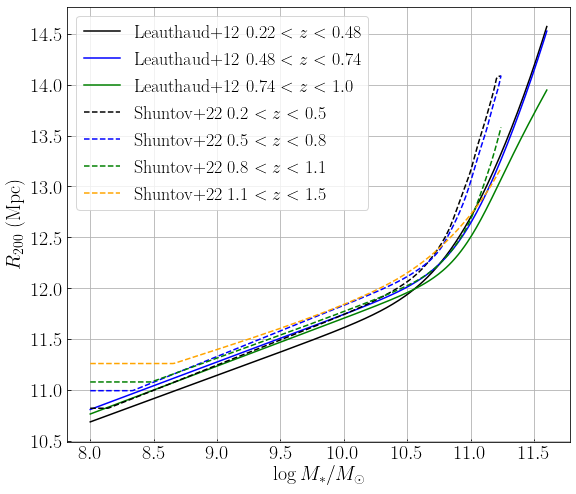

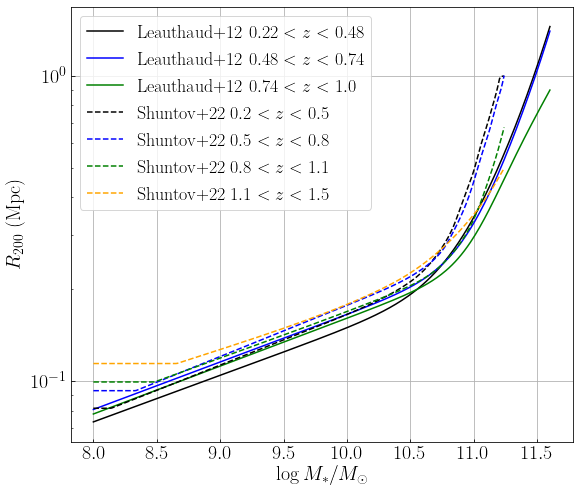

In [337]:
def Ms_to_r200_no2(log_Ms,z_min,z_max):
    rho_bar = 9.9e-30  # g/cm^3
    data = np.genfromtxt('SHMR_total_z-'+str(round((z_min+z_max)/2,2))+'.dat') # from Shuntov et al. 2022 A&A, 664 (2022) A61 
    data = data[1:,]
    log_Mh_list = np.log10(data[:,0])
    log_Ms_list = np.log10(data[:,1])
    log_Mh = np.interp(log_Ms,log_Ms_list,log_Mh_list)
    
    r200 = ((3*10**log_Mh*1.989e30*1e3)/(4*np.pi*200*rho_bar))**(1/3)/3.086e21 # in kpc
    return log_Mh,r200/1000  # in Mpc

# M_cen vs R200
def Ms_to_r200(log_Ms,z): 
    Ms = 10**log_Ms # solar masses
    rho_bar = 9.9e-30  # g/cm^3
    if z>0.22 and z<0.48:
        M1 = 10 ** 12.52 # solar masses
        Ms0 = 10 ** 10.916 # solar masses
        beta = 0.457
        delta = 0.566
        gamma = 1.53
    elif z>=0.48 and z<0.74:
        M1 = 10 ** 12.725 # solar masses
        Ms0 = 10 ** 11.038 # solar masses
        beta = 0.466
        delta = 0.61
        gamma = 1.95
    elif z>=0.74 and z<1:
        M1 = 10 ** 12.722 # solar masses
        Ms0 = 10 ** 11.1 # solar masses
        beta = 0.47
        delta = 0.393
        gamma = 2.51
    
    log_mh = np.log10(M1) + beta * np.log10(Ms / Ms0) + (Ms / Ms0) ** delta / (1 + (Ms / Ms0) ** (-1 * gamma)) - 0.5 # Leauthaud+2012
    
    r200 = ((3*10**log_mh*1.989e30*1e3)/(4*np.pi*200*rho_bar))**(1/3)/3.086e21 # in kpc
    return log_mh,r200/1000  # in Mpc

m_cen_plot = np.linspace(8.0,11.6,300)
colors = ['k','b','g','orange']

fig, ax = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(9, 8))
plt.plot(m_cen_plot, Ms_to_r200(m_cen_plot,0.3)[0],label='Leauthaud+12 $0.22<z<0.48$',color=colors[0])
plt.plot(m_cen_plot, Ms_to_r200(m_cen_plot,0.5)[0],label='Leauthaud+12 $0.48<z<0.74$',color=colors[1])
plt.plot(m_cen_plot, Ms_to_r200(m_cen_plot,0.8)[0],label='Leauthaud+12 $0.74<z<1.0$',color=colors[2])

cutoff = -30
plt.plot(m_cen_plot[:cutoff], Ms_to_r200_no2(m_cen_plot[:cutoff],0.2,0.5)[0],'--',label='Shuntov+22 $0.2<z<0.5$',color=colors[0])
plt.plot(m_cen_plot[:cutoff], Ms_to_r200_no2(m_cen_plot[:cutoff],0.5,0.8)[0],'--',label='Shuntov+22 $0.5<z<0.8$',color=colors[1])
plt.plot(m_cen_plot[:cutoff], Ms_to_r200_no2(m_cen_plot[:cutoff],0.8,1.1)[0],'--',label='Shuntov+22 $0.8<z<1.1$',color=colors[2])
plt.plot(m_cen_plot[:cutoff], Ms_to_r200_no2(m_cen_plot[:cutoff],1.1,1.5)[0],'--',label='Shuntov+22 $1.1<z<1.5$',color=colors[3])
plt.grid()
plt.legend(fontsize=18)
plt.xlabel('$\log M_*/M_\odot$',fontsize=20)
plt.ylabel('$\log M_h/M_\odot$ (Mpc)',fontsize=20)
plt.xlabel('$\log M_*/M_\odot$',fontsize=20)
plt.ylabel('$R_{200}$ (Mpc)',fontsize=20)
plt.savefig('/Users/lejay/Desktop/smf_paper/Ms_Mh.png')

fig, ax = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(9, 8))
plt.plot(m_cen_plot, Ms_to_r200(m_cen_plot,0.3)[1],label='Leauthaud+12 $0.22<z<0.48$',color=colors[0])
plt.plot(m_cen_plot, Ms_to_r200(m_cen_plot,0.5)[1],label='Leauthaud+12 $0.48<z<0.74$',color=colors[1])
plt.plot(m_cen_plot, Ms_to_r200(m_cen_plot,0.8)[1],label='Leauthaud+12 $0.74<z<1.0$',color=colors[2])

cutoff = -30
plt.plot(m_cen_plot[:cutoff], Ms_to_r200_no2(m_cen_plot[:cutoff],0.2,0.5)[1],'--',label='Shuntov+22 $0.2<z<0.5$',color=colors[0])
plt.plot(m_cen_plot[:cutoff], Ms_to_r200_no2(m_cen_plot[:cutoff],0.5,0.8)[1],'--',label='Shuntov+22 $0.5<z<0.8$',color=colors[1])
plt.plot(m_cen_plot[:cutoff], Ms_to_r200_no2(m_cen_plot[:cutoff],0.8,1.1)[1],'--',label='Shuntov+22 $0.8<z<1.1$',color=colors[2])
plt.plot(m_cen_plot[:cutoff], Ms_to_r200_no2(m_cen_plot[:cutoff],1.1,1.5)[1],'--',label='Shuntov+22 $1.1<z<1.5$',color=colors[3])
plt.yscale('log')
plt.grid()
plt.legend(fontsize=18)

plt.xlabel('$\log M_*/M_\odot$',fontsize=20)
plt.ylabel('$R_{200}$ (Mpc)',fontsize=20)
plt.savefig('/Users/lejay/Desktop/smf_paper/Ms_R200.png')

In [357]:
from astropy.cosmology import *
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

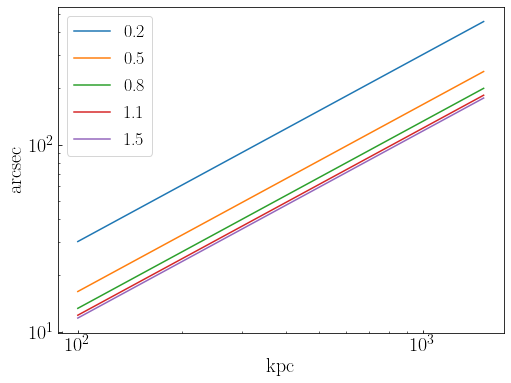

In [363]:
#
fig, ax = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 6))
r = np.linspace(100,1500,100)
for z in [0.2,0.5,0.8,1.1,1.5]:
    dis = cosmo.angular_diameter_distance(z).value # Mpc
    convert_factor = 1 / dis / np.pi * 180 # convert Mpc to degree (at the redshift of central galaxy)
    plt.plot(r,(r/1000)*convert_factor*3600,label=str(z))
    
    plt.xscale('log')
    plt.yscale('log')

plt.xlabel('kpc',fontsize=20)
plt.ylabel('arcsec',fontsize=20)   
plt.legend(fontsize=18)

In [1349]:
# print out number of isolated centrals and Q-frac

masscut_host_list = [10.5,10.8,11.0,11.2]
masscut_host_high_list = [10.8,11.0,11.2,11.5]

masscut_host = 11.2
masscut_host_high = 13.0
for m_idx in range(4):
    print()
    path = 'smf_pcat/test_smf_cenmass_'+str(masscut_host_list[m_idx])+'_'+str(masscut_host_high_list[m_idx])+'/'
    print(path)
    for z_idx,z in enumerate(z_mins): 
        num_cen = 0
        num_q_cen = 0
        for field in field_name_infile:
            cen_cat = Table.read(path + field_name_infile[field_num]+'_deep_cen_'+str(masscut_host_list[m_idx])+'_'+str(z_mins[z_idx])+'.fits')
            cen_q_cat = cen_cat[cen_cat['sfq_nuvrk_onebin_bal']==0]
            num_cen += len(cen_cat)
            num_q_cen += len(cen_q_cat)
            
        print(str(round(z_mins[z_idx],1))+'<z<'+str(round(z_maxs[z_idx],1)),num_cen,round(num_q_cen/num_cen*100,1))
    


smf_pcat/test_smf_cenmass_10.5_10.8/
0.2<z<0.5 548 59.1
0.5<z<0.8 772 39.4
0.8<z<1.1 868 47.9
1.1<z<1.5 1708 31.6

smf_pcat/test_smf_cenmass_10.8_11.0/
0.2<z<0.5 292 65.8
0.5<z<0.8 464 52.6
0.8<z<1.1 476 57.1
1.1<z<1.5 856 42.5

smf_pcat/test_smf_cenmass_11.0_11.2/
0.2<z<0.5 208 73.1
0.5<z<0.8 320 61.3
0.8<z<1.1 356 68.5
1.1<z<1.5 496 46.8

smf_pcat/test_smf_cenmass_11.2_11.5/
0.2<z<0.5 128 75.0
0.5<z<0.8 244 77.0
0.8<z<1.1 272 80.9
1.1<z<1.5 344 37.2



0.2 0.5
10044
21685



/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


0.5 0.8
16245
36343

0.8 1.1
19530
42616

1.1 1.5
30060
56982


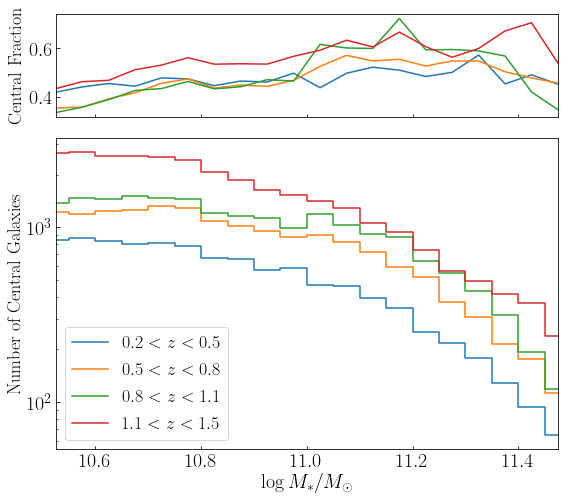

In [140]:
# mass distribution
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(9, 8),gridspec_kw={'height_ratios':[1,3]})

z_mins = [0.2,0.5,0.8,1.1]
z_maxs = [0.5,0.8,1.1,1.5]
masscut_host_list = [10.5,10.8,11.0,11.2]
masscut_host_high_list = [10.8,11.0,11.2,11.5]
bin_size=0.05
bin_edges=np.arange(10.5,11.56,bin_size)

for z_idx,z in enumerate(z_mins): 
    print('')
    mass_list_massive = np.array([])
    for field_num,field in enumerate(field_name_infile):
        if field_name_infile[field_num] != 'XMM-LSS':
            cat = Table.read('/Users/lejay/research/lephare_dev/my_code/graham_output_cats_new/pcat_'+field_name_infile[field_num]+'_deep_cat_out_nomaglimit_nonir_il_nz_prior_formass_sfq_added.fits')
            cat = cat[cat['inside_u'] == True]
        else:
            cat = Table.read('/Users/lejay/research/lephare_dev/my_code/graham_output_cats_new/pcat_'+field_name_infile[field_num]+'_deep_cat_out_nomaglimit_noirac_il_nz_prior_formass_sfq_added.fits')
            cat = cat[cat['inside_uS_deep'] == True]
            cat = cat[cat['inside_j'] == True]
    
        cat = cat[cat['inside_hsc'] == True]
        cat = cat[cat['isStar']==False]
        cat = cat[cat['inside_hsc'] == True]
        cat = cat[cat['isCompact']==False]
        cat = cat[cat['i_compact_flag']==False]
        cat = cat[cat['snr_i']>3]
        cat = cat[cat['snr_r']>1.5]
        cat = cat[cat['snr_z']>1.5]
        cat_total = cat[cat['i_cmodel']>0]
        
        cat_massive = cat_total[np.logical_and(cat_total['Z_COMBINE']>z_mins[z_idx],cat_total['Z_COMBINE']<z_maxs[z_idx])]
        cat_massive = cat_massive[cat_massive['MASS_MED']>10.5]
        cat_massive = cat_massive[cat_massive['MASS_MED']<11.5]
        mass_list_massive = np.append(mass_list_massive,cat_massive['MASS_MED'])
    
    mass_list_total = np.array([])
    for m_idx in range(len(masscut_host_list)):
        masscut_host = masscut_host_list[m_idx]
        masscut_host_high = masscut_host_high_list[m_idx]
        for field_num,field in enumerate(field_name_infile):
            cen_cat = Table.read('smf_pcat/test_smf_cenmass_test_Feb24_'+str(masscut_host)+'_'+str(masscut_host_high)+'/'+field_name_infile[field_num]+'_deep_cen_'+str(masscut_host)+'_'+str(z_mins[z_idx])+'.fits')
            mass_list_total = np.append(mass_list_total,cen_cat['MASS_MED'])
            
    print(z_mins[z_idx],z_maxs[z_idx])
    print(len(mass_list_total))
    print(len(mass_list_massive))
    
    hist_massive = np.histogram(mass_list_massive, bins=bin_edges)[0]
    hist_central = np.histogram(mass_list_total, bins=bin_edges)[0]
    cen_frac = hist_central/hist_massive
    
    axs[0].plot(bin_edges[:-1]+bin_size/2,cen_frac)
    axs[1].step(bin_edges[:-1],hist_central, where='post',label='$'+str(round(z_mins[z_idx],1))+'<z<'+str(round(z_maxs[z_idx],1))+'$')
    
axs[1].set_xlabel('$\log M_*/M_\odot$',fontsize=20)
axs[0].set_ylabel('Central Fraction',fontsize=18)
axs[0].set_xlim([10.5+bin_size/2,11.5-bin_size/2])
axs[1].set_ylabel('Number of Central Galaxies',fontsize=18)
axs[1].set_yscale('log')
axs[1].legend(fontsize=18)
fig.subplots_adjust(hspace=0.1)
plt.savefig('/Users/lejay/Desktop/smf_paper/Central_frac.png')

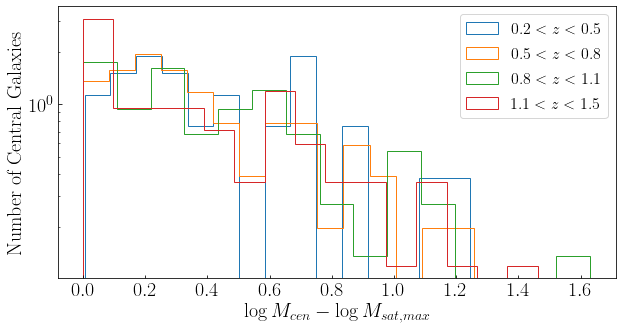

In [23]:
# dM distribution

fig, ax = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(10, 5))
masscut_host = 11.2
z_idx = 0

z_mins = [0.2,0.5,0.8,1.1]
z_maxs = [0.5,0.8,1.1,1.5]
for z_idx,z in enumerate(z_mins): 
    dM_list_total = np.array([])
    for field in field_name_infile:
        cen_cat = Table.read('smf_pcat/test_smf_cenmass_11.2_11.5/'+field_name_infile[field_num]+'_deep_cen_'+str(masscut_host)+'_'+str(z_mins[z_idx])+'.fits')
        dM_list = cen_cat['dM_sat']
        dM_list_total = np.append(dM_list_total,dM_list)
    
    plt.hist(dM_list_total,bins=15,histtype='step',label='$'+str(round(z_mins[z_idx],1))+'<z<'+str(round(z_maxs[z_idx],1))+'$',density=True)
    
plt.xlabel('$\log M_{cen}-\log M_{sat,max}$',fontsize=20)
plt.ylabel('Number of Central Galaxies',fontsize=20)
plt.yscale('log')
plt.legend(fontsize=16)
plt.show()


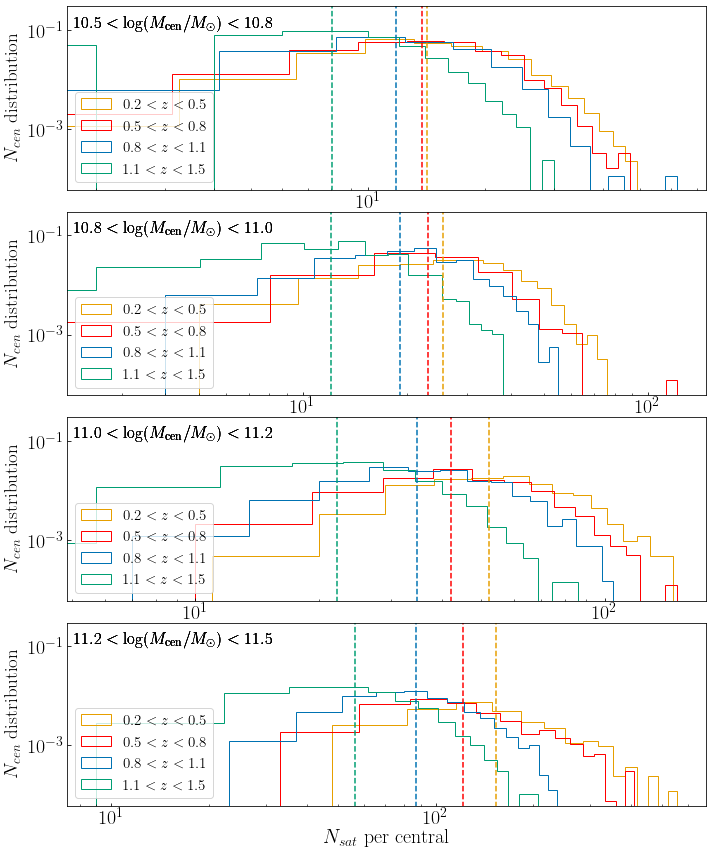

In [423]:
# N_sat distribution

fig, axs = plt.subplots(4, 1, figsize=(10, 12))
masscut_host_list = [10.5,10.8,11.0,11.2]
masscut_host_high_list = [10.8,11.0,11.2,11.5]
for m_idx in range(len(masscut_host_list)):
    masscut_host = masscut_host_list[m_idx]
    masscut_host_high = masscut_host_high_list[m_idx]
    
    num_bins = 35
    colors = ['#E69F00','red','#0072B2','#009E73']
    path = 'smf_pcat/test_smf_cenmass_test_Feb24_'+str(masscut_host)+'_'+str(masscut_host_high)+'/'
    z_mins = [0.2,0.5,0.8,1.1]
    z_maxs = [0.5,0.8,1.1,1.5]
    for z_idx,z in enumerate(z_mins): 
        nsat_list_total = np.array([])
        n_centrals_all = 0
        n_bkg = 0
        for field in field_name_infile:
            cen_cat = Table.read(path+field_name_infile[field_num]+'_deep_cen_'+str(masscut_host)+'_'+str(z_mins[z_idx])+'.fits')
            nsat_list = cen_cat['n_sat']
            nsat_list_total = np.append(nsat_list_total,nsat_list)
            
            # bkg level
            n_centrals, smf_avg, smf_inf, smf_sup = combine_deep_smf(path, 'all', 'bkg', str(z), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins,relative_cut='r_scale')
            n_bkg += sum(smf_avg*n_centrals)
            n_centrals_all += n_centrals
        axs[m_idx].hist(nsat_list_total,bins=15,histtype='step',label='$'+str(round(z_mins[z_idx],1))+'<z<'+str(round(z_maxs[z_idx],1))+'$',density=True,color=colors[z_idx])
        
        # indicate bkg level
        n_bkg = n_bkg/n_centrals_all
        axs[m_idx].vlines(x=n_bkg,ymin=6e-6,ymax=1,color=colors[z_idx],linestyle='--')
        axs[m_idx].annotate('$'+str(masscut_host)+'<\log(M_\mathrm{cen}/M_\odot)<'+str(masscut_host_high)+'$',xy=([0.01,0.87]),xycoords='axes fraction',fontsize=17,color='k')
        
    axs[m_idx].set_xlabel('$N_{sat}$ per central',fontsize=20)
    axs[m_idx].set_ylabel('$N_{cen}$ distribution',fontsize=19)
    axs[m_idx].set_xscale('log')
    axs[m_idx].set_yscale('log')
    axs[m_idx].set_ylim([6e-5,3e-1])
    axs[m_idx].legend(fontsize=15, loc='lower left')

plt.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.12)
plt.savefig('/Users/lejay/Desktop/smf_paper/n_sat_per_central.png')

In [266]:
# check with confirmed centrals ()

cat = Table.read('/Users/lejay/research/massive_gals/cluster_cats/COSMOS_z005_R3000_sig2_N100_specz_241107.fits')
cat_myCOSMOS = Table.read('smf_pcat/test_smf_noisobkg_cenmass_11.2/COSMOS_deep_cen_11.2_0.2.fits')
cat_myCOSMOS2 = Table.read('smf_pcat/test_smf_noisobkg_cenmass_11.2/COSMOS_deep_cen_11.2_0.5.fits')
cat_myCOSMOS3 = Table.read('smf_pcat/test_smf_noisobkg_cenmass_11.2/COSMOS_deep_cen_11.2_0.8.fits')

# select centrals
cluster_IDs = np.unique(cat['cluster_ID'])

for cluster_ID in cluster_IDs:
    cat_cluster = cat[cat['cluster_ID'] == cluster_ID]
    cat_cluster = cat_cluster[cat_cluster['mem_prob']>0.15]
    central_gal = cat_cluster[cat_cluster['mem_prob']==100]
    cen_ID = central_gal['ID'][0]
    
    cond = (central_gal['ID'][0] in cat_myCOSMOS['ID']) + (central_gal['ID'][0] in cat_myCOSMOS2['ID']) + (central_gal['ID'][0] in cat_myCOSMOS3['ID'])
    print(central_gal['MASS_MED'][0],cond)

11.1657 0
11.7516 1
11.1572 0
11.2851 1
11.5805 1
11.4675 0
11.6514 1
10.7372 0
11.5315 1
11.3565 1
11.0192 0
11.5718 1


#### Satellite SMF
mass cut for central: 11.3

In [393]:
masscut_lows=[8.0, 8.3, 8.5, 8.8]
def combine_deep_smf(path, ssfq, affix, z, masscut_low='7.0', masscut_host='11.0',bin_number=50, csfq='all',relative_cut='fixed_cut',rfactor=1.0): 
    z_mins = [0.2,0.5,0.8,1.1]
    z_idx = np.searchsorted(z_mins, eval(z))
    counts_total = 0
    smf_avg_total = np.zeros(bin_number)
    smf_inf_total = np.zeros(bin_number)
    smf_sup_total = np.zeros(bin_number)
    
    r_low = '0.0'
    r_high = '0.7'
    
    error_inf = np.zeros(bin_number)
    error_sup = np.zeros(bin_number)
    for cat_name in ['COSMOS_deep','XMM-LSS_deep','ELAIS_deep','DEEP_deep']:
        if relative_cut == 'fixed_cut':
            smf = np.genfromtxt(path+'smf_'+cat_name+'_cen_'+masscut_host+'_'+r_low+'_'+r_high+'_'+str(masscut_lows[z_idx])+'_'+csfq+'_'+ssfq+'_'+z+'_'+affix+'.txt')
        elif relative_cut == 'r_scale':
            if rfactor != 1.0:
                r_factor_infilename = str(rfactor)
            else:
                r_factor_infilename = ''
            smf = np.genfromtxt(path+'smf_'+cat_name+'_cen_'+masscut_host+'_'+r_low+'_'+r_factor_infilename+'r200_'+str(masscut_lows[z_idx])+'_'+csfq+'_'+ssfq+'_'+z+'_'+affix+'.txt')
        elif relative_cut == 'm_scale':
            smf = np.genfromtxt(path+'smf_'+cat_name+'_cen_'+masscut_host+'_rel_mscale_'+r_low+'_'+r_high+'_'+str(masscut_lows[z_idx])+'_'+csfq+'_'+ssfq+'_'+z+'_'+affix+'.txt')
        else:
            smf = np.genfromtxt(path+'smf_'+cat_name+'_cen_'+masscut_host+'_rel_mscale'+'_'+r_low+'_r200_'+str(masscut_lows[z_idx])+'_'+csfq+'_'+ssfq+'_'+z+'_'+affix+'.txt')
        
        # print(cat_name,'len of smf',len(smf),3*bin_number+1)
        
        count = smf[0]
        smf_avg = smf[1:bin_number+1]
        smf_inf = smf[bin_number+1:2*bin_number+1]
        smf_sup = smf[2*bin_number+1:3*bin_number+1]
        # print(count,len(smf_avg),len(smf_inf),len(smf_sup))
        
        counts_total += count
        smf_avg_total += smf_avg * count
        error_inf += ((smf_avg-smf_inf) * count)**2
        error_sup += ((smf_sup-smf_avg) * count)**2
    
    smf_avg_threefields = smf_avg_total / counts_total
    smf_inf_threefields = smf_avg_threefields - np.sqrt(error_inf) / counts_total
    smf_sup_threefields = smf_avg_threefields + np.sqrt(error_sup) / counts_total
    # print(np.sqrt(error_inf)/smf_avg_threefields)
    
    return counts_total, smf_avg_threefields, smf_inf_threefields, smf_sup_threefields

# combine central mass lists

def combine_cen_mass(path, z):
    mass_cen_all = np.array([])
    for field in ['COSMOS','XMM-LSS','ELAIS','DEEP']:
        cen_cat = Table.read(path+field+'_deep_cen_'+str(masscut_host)+'_'+str(z)+'.fits')
        mass_list = cen_cat['MASS_MED']
        mass_cen_all = np.append(mass_cen_all,mass_list)
        
    return mass_cen_all

##### define Schehter fitting functions

In [439]:
from scipy.optimize import curve_fit
from bisect import bisect

# schecter function
def schechter(log_m,phi,log_m_s,alpha_s):
    m_s = 10**(log_m_s-10)
    m = 10**(log_m-10)
    return phi*(m/m_s)**(alpha_s)*np.exp(-(m/m_s))

def double_schechter(log_m,log_m_s,phi1,alpha_s1,phi2,alpha_s2):
    m_s = 10**(log_m_s-10)
    m = 10**(log_m-10)
    return (phi1*(m/m_s)**(alpha_s1)+phi2*(m/m_s)**(alpha_s2))*np.exp(-(m/m_s))

def con_double_schec_varysigma(masses,m_s,phi1,alpha_s1,phi2,alpha_s2,z_min):
    intervals = 300
    mrange = np.linspace(8, 12.2, intervals)
    dx = (12.2-8)/intervals
    values = double_schechter(mrange+dx/2,m_s,phi1,alpha_s1,phi2,alpha_s2)  # un-convolved values 
    
    z_min = round(z_min,1)
    arr = np.load('mass_err/mass_err_overall_all_'+str(z_min)+'.npy')
    mass_err_x = arr[0]
    mass_err_y = arr[1]

    # calculate convolved values
    if isinstance(masses, list) or isinstance(masses, np.ndarray):
        con_values = []
        for m in masses:
            sigma_m_var = np.interp(m,mass_err_x,mass_err_y)
            kernel = []  # the gaussian kernel
            for i in range(int(-3*sigma_m_var/dx),int(3*sigma_m_var/dx)+1):
                kernel.append(gaussian(i*dx,0,sigma_m_var))
            kernel = np.array(kernel)
            kernel  = kernel / sum(kernel)
            con_values.append(np.convolve(values,kernel,mode='same')[min(bisect(mrange, m),intervals-1)])
    elif isinstance(masses, float):
        m = masses
        sigma_m_var = np.interp(m,mass_err_x,mass_err_y)
        kernel = []
        for i in range(int(-3*sigma_m_var/dx),int(3*sigma_m_var/dx)+1):
            kernel.append(gaussian(i*dx,0,sigma_m_var))
        kernel = np.array(kernel)
        kernel  = kernel / sum(kernel)
        con_values = np.convolve(values, kernel, mode='same')[min(bisect(mrange, m),intervals-1)]  
    else:
        raise ValueError("wrong value for mass...")
    
    return np.array(con_values)
        
def con_double_schechter(masses,m_s,phi1,alpha_s1,phi2,alpha_s2, sigma_m): # convolved schecter function with a gaussian function
    intervals = 300
    mrange = np.linspace(8, 12.2, intervals)
    dx = (12.2-8)/intervals
    values = double_schechter(mrange+dx/2,m_s,phi1,alpha_s1,phi2,alpha_s2)  # un-convolved values 
    
    # the gaussian kernel (same sigma_m for all masses)
    kernel_const = []
    con_values = []
    for i in range(int(-3*sigma_m/dx),int(3*sigma_m/dx)+1):
        kernel_const.append(gaussian(i*dx,0,sigma_m))
    kernel_const = np.array(kernel_const)
    kernel_const  = kernel_const / sum(kernel_const)
    
    # calculate convolved values
    if isinstance(masses, list) or isinstance(masses, np.ndarray):
        for m in masses:
            con_values.append(np.convolve(values,kernel_const,mode='same')[min(bisect(mrange, m),intervals-1)])
    elif isinstance(masses, float):
        con_values = np.convolve(values, kernel_const, mode='same')[min(bisect(mrange, m),intervals-1)]  
    else:
        raise ValueError("wrong value for mass...")
        
    return np.array(con_values)


def con_schechter(masses,phi,m_s,alpha_s,sigma): # convolved schecter function with a gaussian function
    intervals = 300
    dx = (12.2-8)/intervals
    
    # the gaussian kernel
    kernel = []
    for i in range(int(-3*sigma/dx),int(3*sigma/dx)+1):
        kernel.append(gaussian(i*dx,0,sigma))
    kernel = np.array(kernel)
    kernel  = kernel / sum(kernel)
    
    # calculate convolved values
    con_values = []
    mrange = np.linspace(8, 12.2, intervals)
    values = schechter(mrange+dx/2,phi,m_s,alpha_s)   
    if isinstance(masses, list) or isinstance(masses, np.ndarray):
        for m in masses:
            con_values.append(np.convolve(values,kernel,mode='same')[min(bisect(mrange, m),intervals-1)])
    else:
        m = masses 
        con_values = np.convolve(values, kernel, mode='same')[min(bisect(mrange, m),intervals-1)]           
    return np.array(con_values)

def gaussian(x, mu, sig):
    return 1/(sig*np.sqrt(2*np.pi))*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def con_double_schec_lognormal(masses, m_s, phi1, alpha_s1, phi2, alpha_s2, z_min, mu, sig, norm):
    return con_double_schec_varysigma(masses,m_s,phi1,alpha_s1,phi2,alpha_s2, z_min) + norm*gaussian(masses, mu, sig)

#########
#########

# fitting schecter function
def fit_schechter(xdata, ydata, ydata_err, start, end, mass_ini=11.0): # phi,m_s,alpha
    p0_fit = [1, mass_ini,-1]
    bounds_low_fit = [0.0, mass_ini-0.3, -2.0]
    bounds_high_fit = [20.0, mass_ini+0.1, 2.0]
        
    popt,pcov = curve_fit(schechter, xdata[start-1:end], ydata[start-1:end], sigma=ydata_err[start-1:end],p0=p0_fit,bounds=(bounds_low_fit,bounds_high_fit))
    res = ydata - schechter(xdata, *popt)
    chi2_ = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2_

def fit_schechter_con(xdata, ydata, ydata_err, start, end, sigma_m): # phi,m_s,alpha,sigma_m
    popt,pcov = curve_fit(con_schechter, xdata[start-1:end], ydata[start-1:end], sigma=ydata_err[start-1:end],p0=[2e-4,11,-1.5,sigma_m],bounds=([0,10,-2,sigma_m-0.00000001],[1e-2,12,2,sigma_m]),method='trf',absolute_sigma=True)
    res = ydata - con_schechter(xdata, *popt)
    chi2_ = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2_

def fit_double_schechter(xdata, ydata, ydata_err, start, end): # m_s,phi1,alpha_s1,phi2,alpha_s2
    popt,pcov = curve_fit(double_schechter, xdata[start-1:end], ydata[start-1:end], sigma=ydata_err[start-1:end],p0=[11,2e-1,-0.5,2e-1,-1.5],bounds=([10,0,-2,0,-2],[12,20,2,20,0]),absolute_sigma=True)
    res = ydata - double_schechter(xdata, *popt)
    chi2_ = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2_

def fit_double_schechter_con(xdata, ydata, ydata_err, start, end, sigma_m, double_fit=True): # log_m_s,phi1,alpha_s1,phi2,alpha_s2,sigma_m
    if double_fit: # double schechter fit
        p0_fit = [11,2.1e-1,-0.51,0.01,0.01,sigma_m]
        bounds_low_fit = [10.4,0,-2,0,-2,sigma_m-0.00001]
        bounds_high_fit = [12,20,4,20,0,sigma_m+0.00001]
    else:  # reduce to single schechter fit
        p0_fit = [11,2.1e-1,-0.51,0.01,0.01,sigma_m]
        bounds_low_fit = [10.4,0,-2,0,0,sigma_m-0.00001]
        bounds_high_fit = [12,1e1,4,1e-15,1e-10,sigma_m+0.00001]
        
    popt,pcov = curve_fit(con_double_schechter, xdata[start-1:end], ydata[start-1:end], sigma=ydata_err[start-1:end],p0=p0_fit,bounds=(bounds_low_fit,bounds_high_fit),absolute_sigma=True)
    res = ydata - con_double_schechter(xdata, *popt)
    chi2_ = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2_

def fit_double_schec_varysigma_con(xdata, ydata, ydata_err, start, end, zmin, double_fit=True, log_m_s_ini=10.5, alpha1_ini = -1.0, alpha2_ini = -1.0): # log_m_s,phi1,alpha_s1,phi2,alpha_s2, (z_min, z_max)
    if double_fit: # double schechter fit
        p0_fit = [log_m_s_ini,1.1,alpha1_ini,2e-1,alpha2_ini,zmin]
        bounds_low_fit = [log_m_s_ini-0.2,0,alpha1_ini-0.5,0,alpha2_ini-0.5,zmin-0.00001]
        bounds_high_fit = [log_m_s_ini+0.05,20,alpha1_ini+0.5,20,alpha2_ini+0.5,zmin+0.00001]
    else:  # reduce to single schechter fit
        p0_fit = [11,2e-1,-0.5,0,0,zmin]
        bounds_low_fit = [10.0,0,-2,0,0,zmin-0.00001]
        bounds_high_fit = [12,2e1,2,1e-15,1e-10,zmin+0.00001]
        
    popt,pcov = curve_fit(con_double_schec_varysigma, xdata[start-1:end], ydata[start-1:end], sigma=ydata_err[start-1:end],p0=p0_fit,bounds=(bounds_low_fit,bounds_high_fit),absolute_sigma=True)
    res = ydata - con_double_schec_varysigma(xdata, *popt)
    chi2_ = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2_

# def fit_double_schec_lognormal(xdata, ydata, ydata_err, start, end, zmin, mu, sig, double_fit=True):
#     if double_fit: # double schechter fit
#         p0_fit = [10.8,1,-0.5,2e-1,-1.5,zmin,mu,sig, 0.001]
#         bounds_low_fit = [10.0,0,-2,0,-2,zmin-0.00001,mu-1,sig/2,0]
#         bounds_high_fit = [12,20,4,20,0,zmin+0.00001,mu+1,sig*2,10]
#     else:  # reduce to single schechter fit
#         p0_fit = [11,2e-1,-0.5,0,0,zmin,mu,sig,0.001]
#         bounds_low_fit = [10.0,0,-2,0,0,zmin-0.00001,mu-0.5,sig/1.5,0]
#         bounds_high_fit = [12,2e1,4,1e-15,1e-10,zmin+0.00001,mu+0.5,sig*1.5,10]
        
#     popt,pcov = curve_fit(con_double_schec_lognormal, xdata[start-1:end], ydata[start-1:end], sigma=ydata_err[start-1:end],p0=p0_fit,bounds=(bounds_low_fit,bounds_high_fit),max_nfev=50000)
#     print(len(popt))
#     res = ydata - con_double_schec_lognormal(xdata, *popt)
#     chi2_ = sum((res / ydata_err) ** 2)
#     return popt,pcov,chi2_

In [459]:
# basic parameters
z_mins = [0.2,0.5,0.8,1.1]
z_maxs = [0.5,0.8,1.1,1.5]

masscut_lows=[8.0, 8.3, 8.5, 8.8]
masscut_high = 13.0

masscut_host = 10.5
masscut_host_high = 10.8
num_bins = 35 # number of bin edges

smf_pcat/test_smf_cenmass_10.5_10.8/
[-0.013  0.021  0.058  0.075  0.09   0.097  0.096  0.091  0.075  0.089
  0.056  0.06   0.044  0.041  0.043  0.054  0.051  0.045  0.024 -0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.   ]
0.2<z<0.5 No. of satellites 0.1 7377.0
[-0.042 -0.012 -0.004  0.022  0.051  0.063  0.039  0.076  0.058  0.041
  0.056  0.04   0.03   0.03   0.041  0.044  0.038  0.02  -0.001  0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.   ]
0.5<z<0.8 No. of satellites -0.4 12876.0
[-0.078 -0.074 -0.042 -0.018 -0.007  0.033  0.044  0.033  0.05   0.036
  0.045  0.029  0.039  0.044  0.035  0.037  0.023  0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.   ]
0.8<z<1.1 No. of satellites -0.8 14805.0
[-0.106 -0.101 -0.089 -0.064 -0.035 -0.019 -0.039 -0.024 -0.018  0.001
  0.006  0.011  0.021  0.013  0.019  0.

Text(0.5, 0, '$\\log M_*/M_\\odot$')

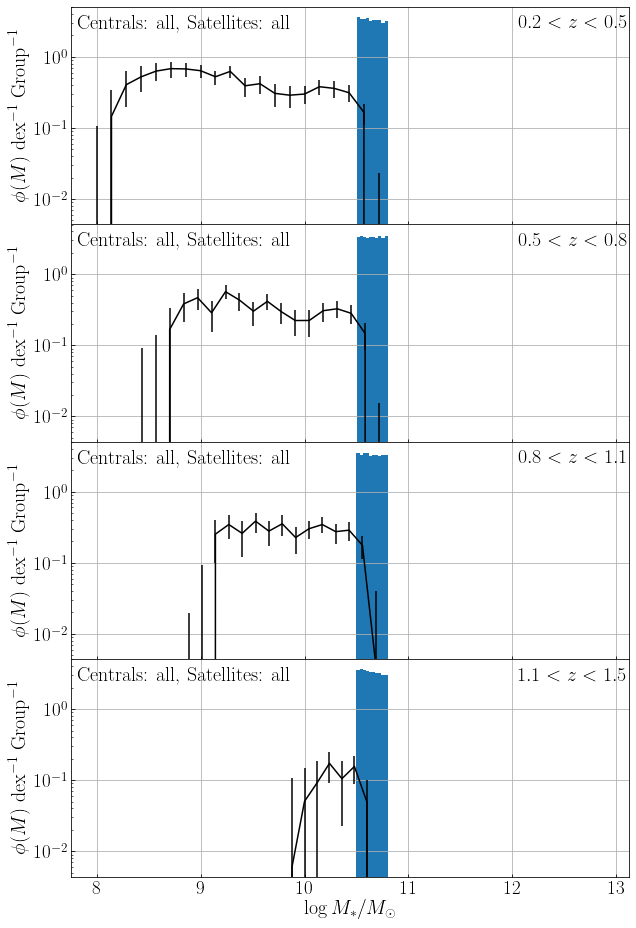

In [462]:
# plot SMF

fig, axs = plt.subplots(4, 1, figsize = (10, 16),sharex=True,sharey=True)
q_colors = ['lightsalmon','red','brown','maroon']
sf_colors = ['cornflowerblue','blue','darkblue','midnightblue']
all_colors  = ['lightgray','darkgray','gray','black']
color_sets = [all_colors, sf_colors, q_colors]

csfq='all'
ssfq='all'
count_type = 'sat'
fit_data = False
path = 'smf_pcat/test_smf_cenmass_'+str(masscut_host)+'_'+str(masscut_host_high)+'/'
# path = 'smf_pcat/test_smf_noisobkg_cenmass_10.5/'
print(path)
fit_params = []
fit_params_err = []

masscut_lows=[8.0, 8.3, 8.5, 8.8]
for i,z in enumerate(z_mins):   
    masscut_low = masscut_lows[i]
    m_bin_left_edges = np.linspace(masscut_low, masscut_high, num=num_bins+1)[:-1]
    bin_size = m_bin_left_edges[1] - m_bin_left_edges[0]
    
    n_centrals, smf_avg, smf_inf, smf_sup = combine_deep_smf(path, ssfq, count_type, str(z), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins,relative_cut='r_scale')
    y_error = np.array([smf_avg-smf_inf,smf_sup-smf_avg])
    print(smf_avg)
    
    # plot SSMF
    axs[i].errorbar(m_bin_left_edges, smf_avg/bin_size, yerr=y_error/bin_size,label=str(z),color='k')  
    print(str(round(z_mins[i],1))+'<z<'+str(round(z_maxs[i],1)), 'No. of satellites', round(sum(smf_avg)-1,1),n_centrals)
    
    # plot M_cen dist
    mass_cen_list = combine_cen_mass(path, z)
    axs[i].hist(mass_cen_list,bins=10,density=True)
    
    axs[i].set_ylabel(r'$\phi(M)~\mathrm{dex}^{-1} ~\mathrm{Group}^{-1}$',fontsize=20)
    axs[i].set_yscale('log')
    # axs[i].set_xlim([7.9,12.3])
    # axs[i].set_ylim([5e-3,200])
    axs[i].annotate('$'+str(round(z_mins[i],1))+'<z<'+str(round(z_maxs[i],1))+'$',xy=([0.8,0.9]),xycoords='axes fraction',fontsize=20,color='k')
    axs[i].annotate('Centrals: '+csfq+', Satellites: '+ssfq,xy=([0.01,0.9]),xycoords='axes fraction',fontsize=20,color='k')
    axs[i].grid(True)
    
fig.subplots_adjust(wspace=0, hspace=0)
axs[3].set_xlabel('$\log M_*/M_\odot$',fontsize=20)


1.1<z<0.5 No. of satellites 0.8
4 20
1.1<z<0.5 No. of satellites 0.3
4 20
1.1<z<0.8 No. of satellites 0.4
4 20
1.1<z<0.8 No. of satellites 0.1
4 20
1.1<z<1.1 No. of satellites 0.1
4 20
1.1<z<1.1 No. of satellites 0.1
4 20
1.1<z<1.5 No. of satellites -0.4
4 20
no fit
1.1<z<1.5 No. of satellites 0.0
4 20
no fit
1.1<z<0.5 No. of satellites 2.4
4 20
1.1<z<0.5 No. of satellites 0.8
4 20
1.1<z<0.8 No. of satellites 1.8
4 20
1.1<z<0.8 No. of satellites 0.4
4 20
1.1<z<1.1 No. of satellites 1.2
4 20
1.1<z<1.1 No. of satellites 0.3
4 20
1.1<z<1.5 No. of satellites 0.1
4 20
1.1<z<1.5 No. of satellites 0.1
4 20
1.1<z<0.5 No. of satellites 4.8
4 20
1.1<z<0.5 No. of satellites 1.6
4 20
1.1<z<0.8 No. of satellites 3.3
4 20
1.1<z<0.8 No. of satellites 0.9
4 20
1.1<z<1.1 No. of satellites 2.5
4 20
1.1<z<1.1 No. of satellites 0.7
4 20
1.1<z<1.5 No. of satellites 1.3
4 20
1.1<z<1.5 No. of satellites 0.3
4 20
1.1<z<0.5 No. of satellites 8.4
4 20
1.1<z<0.5 No. of satellites 3.4
4 20


/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in true_divide


1.1<z<0.8 No. of satellites 5.8
4 20
1.1<z<0.8 No. of satellites 2.0
4 20
1.1<z<1.1 No. of satellites 5.2
4 20
1.1<z<1.1 No. of satellites 1.6
4 20
1.1<z<1.5 No. of satellites 2.1
4 20
1.1<z<1.5 No. of satellites 0.5
4 20


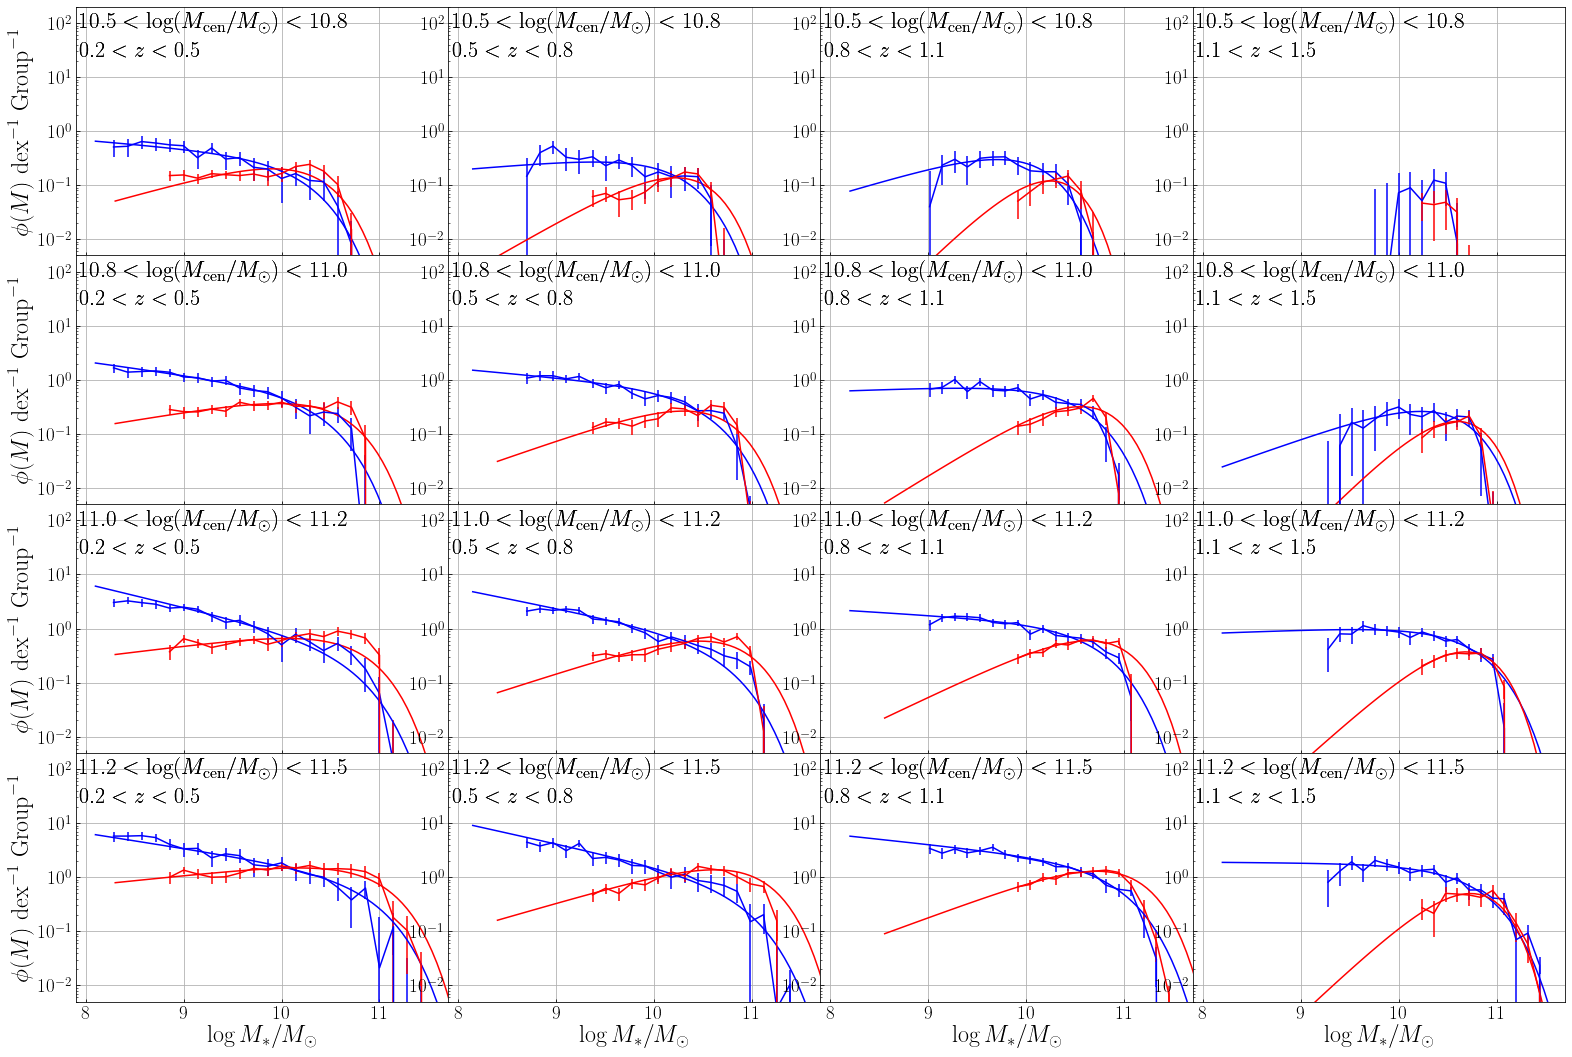

In [458]:
# plot SMF

q_colors = ['lightsalmon','red','brown','maroon']
sf_colors = ['cornflowerblue','blue','darkblue','midnightblue']
all_colors  = ['lightgray','darkgray','gray','black']
color_sets = [all_colors, sf_colors, q_colors]

mass_limits = [8.205, 8.657, 8.962, 9.26 ]
mass_limits_q = [ 8.752,  9.373,  9.794, 10.204]

csfq='all'
ssfq='all'
count_type = 'sat'
masscut_host=11.2
masscut_host_high=11.5


z_mins = [0.2,0.5,0.8,1.1]
z_maxs = [0.5,0.8,1.1,1.5]
mass_limits = [8.205, 8.657, 8.962, 9.26 ]
m_cens = [10.5,10.8,11.0,11.2,11.5]
masscut_lows=[8.0, 8.3, 8.5, 8.8]
masscut_high = 13.0

colors = ['b','r']
num_bins = 35

csfq = 'all'
ssfq = 'all'
count_type='sat'
fit_data='single'
        
fig, axs = plt.subplots(4, 4, figsize = (22, 15),sharex=True)
for m_idx in range(len(m_cens[:-1])):  
    masscut_host = m_cens[m_idx]
    masscut_host_high = m_cens[m_idx+1]
    path = 'smf_pcat/test_smf_cenmass_'+str(masscut_host)+'_'+str(masscut_host_high)+'/'
    for z_idx,z in enumerate(z_mins):   
        for sfq_idx, ssfq in enumerate(['ssf','sq']):
            
            masscut_low = masscut_lows[z_idx]
            m_bin_left_edges = np.linspace(masscut_low, masscut_high, num=num_bins+1)[:-1]
            bin_size = m_bin_left_edges[1] - m_bin_left_edges[0]
            if ssfq != 'sq':
                mlim_index = np.searchsorted(m_bin_left_edges,mass_limits[z_idx])
            else:
                mlim_index = np.searchsorted(m_bin_left_edges,mass_limits_q[z_idx])
            
            n_centrals, smf_avg, smf_inf, smf_sup = combine_deep_smf(path, ssfq, count_type, str(z), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins,relative_cut='r_scale')
            
            y_error = np.array([smf_avg[mlim_index:]-smf_inf[mlim_index:],smf_sup[mlim_index:]-smf_avg[mlim_index:]])
            # y_error = np.sqrt(smf_avg*n_centrals)/n_centrals
            axs[m_idx][z_idx].errorbar(m_bin_left_edges[mlim_index:], smf_avg[mlim_index:]/bin_size, yerr=y_error/bin_size,label=str(z),color=colors[sfq_idx])  
            print(str(round(z_mins[i],1))+'<z<'+str(round(z_maxs[z_idx],1)), 'No. of satellites', round(sum(smf_avg),1))
            
            # fit with single Schechter
            y_fitting = smf_avg
            y_fitting_err = (smf_sup - smf_avg)
            print(mlim_index_data,mhigh_index_data)
            
            try:
                popt, pcov, chi2_ = fit_schechter(m_bin_left_edges, y_fitting, y_fitting_err, start=mlim_index_data+4,end=mhigh_index_data-2, mass_ini=masscut_host-0.4)
                fit_params.append(popt)
                fit_params_err.append(np.sqrt(np.diag(pcov)))
            
                x_plot = np.linspace(8,13.0,100)
                mlim_index_plot = np.searchsorted(x_plot,mass_limits[z_idx])
                y_plot1 = schechter(x_plot, popt[0], popt[1], popt[2]) # phi,m_s,alpha
                axs[m_idx][z_idx].plot(x_plot[mlim_index:],y_plot1[mlim_index:]/bin_size,color=colors[sfq_idx])
            
                if z_idx==0 and m_idx==0:
                    popt_fiducial = popt

            except ValueError:
                print('no fit')
            
            axs[m_idx][0].set_ylabel(r'$\phi(M)~\mathrm{dex}^{-1} ~\mathrm{Group}^{-1}$',fontsize=24)
            axs[m_idx][z_idx].set_yscale('log')
            axs[m_idx][z_idx].set_xlim([7.9,11.7])
            axs[m_idx][z_idx].set_ylim([5e-3,200])
            axs[m_idx][z_idx].annotate('$'+str(round(z_mins[z_idx],1))+'<z<'+str(round(z_maxs[z_idx],1))+'$',xy=([0.01,0.8]),xycoords='axes fraction',fontsize=22,color='k')
            axs[m_idx][z_idx].annotate('$'+str(masscut_host)+'<\log(M_\mathrm{cen}/M_\odot)<'+str(masscut_host_high)+'$',xy=([0.01,0.9]),xycoords='axes fraction',fontsize=23,color='k')
            axs[m_idx][z_idx].grid(True)    

        axs[3][z_idx].set_xlabel('$\log M_*/M_\odot$',fontsize=24)

plt.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
plt.savefig('/Users/lejay/Desktop/smf_paper/ssmf_sat_sfq.png')

In [ ]:
# alternative R200 vs overall SSMF

fig, axs = plt.subplots(4, 1, figsize = (10, 16),sharex=True,sharey=True)
q_colors = ['lightsalmon','red','brown','maroon']
sf_colors = ['cornflowerblue','blue','darkblue','midnightblue']
all_colors  = ['lightgray','darkgray','gray','black']
color_sets = [all_colors, sf_colors, q_colors]

csfq='all'
ssfq='all'
count_type = 'sat'
masscut_host=11.2
masscut_host_high=11.5
path = 'smf_pcat/test_smf_cenmass_'+str(masscut_host)+'_'+str(masscut_host_high)+'/'

fit_data = False
fit_params = []
fit_params_err = []

masscut_lows=[8.0, 8.3, 8.5, 8.8]
colors = ['k','b']
for idx, rfactor in enumerate([1.0, 0.5]):
    for i,z in enumerate(z_mins):   
        masscut_low = masscut_lows[i]
        m_bin_left_edges = np.linspace(masscut_low, masscut_high, num=num_bins+1)[:-1]
        bin_size = m_bin_left_edges[1] - m_bin_left_edges[0]
        
        n_centrals, smf_avg, smf_inf, smf_sup = combine_deep_smf(path, ssfq, count_type, str(z), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins,relative_cut='r_scale',rfactor=rfactor)
        
        y_error = np.array([smf_avg-smf_inf,smf_sup-smf_avg])
        # y_error = np.sqrt(smf_avg*n_centrals)/n_centrals
        
        axs[i].errorbar(m_bin_left_edges, smf_avg/bin_size, yerr=y_error/bin_size,label=str(z),color=colors[idx])  
        print(str(round(z_mins[i],1))+'<z<'+str(round(z_maxs[i],1)), 'No. of satellites', round(sum(smf_avg),1))
        
        axs[i].set_ylabel(r'$\phi(M)~\mathrm{dex}^{-1} ~\mathrm{Group}^{-1}$',fontsize=20)
        axs[i].set_yscale('log')
        axs[i].set_xlim([7.5,12.3])
        axs[i].set_ylim([5e-3,200])
        axs[i].annotate('$'+str(round(z_mins[i],1))+'<z<'+str(round(z_maxs[i],1))+'$',xy=([0.8,0.9]),xycoords='axes fraction',fontsize=20,color='k')
        axs[i].annotate('Centrals: '+'$'+str(masscut_host)+'<\log(M_\mathrm{cen}/M_\odot)<'+str(masscut_host_high)+'$',xy=([0.01,0.9]),xycoords='axes fraction',fontsize=20,color='k')
        axs[i].grid(True)
        
        if fit_data:
            y_fitting = smf_avg
            y_fitting_err = (smf_sup - smf_avg)
            
            popt, pcov, chi2_ = fit_double_schec_lognormal(m_bin_left_edges, y_fitting, y_fitting_err, start=10,end=-15, zmin=z_mins[i],mu=11, sig=0.3, double_fit=False)
            # popt, pcov, chi2_ = fit_double_schec_varysigma_con(m_bin_left_edges, y_fitting, y_fitting_err, start=5,end=-15, zmin=z_mins[i], double_fit=False)
            fit_params.append(popt)
            fit_params_err.append(np.sqrt(np.diag(pcov))) 
        
    fig.subplots_adjust(wspace=0, hspace=0)
    axs[3].set_xlabel('$\log M_*/M_\odot$',fontsize=20)
           
    if fit_data:
        np.save('fit_param_sat_'+ssfq, np.array(fit_params))
        np.save('fit_param_err_sat_'+ssfq, np.array(fit_params_err))


0.2<z<0.5 No. of satellites 16.2
0.5<z<0.8 No. of satellites 5.0
0.8<z<1.1 No. of satellites 5.2
1.1<z<1.5 No. of satellites 2.4


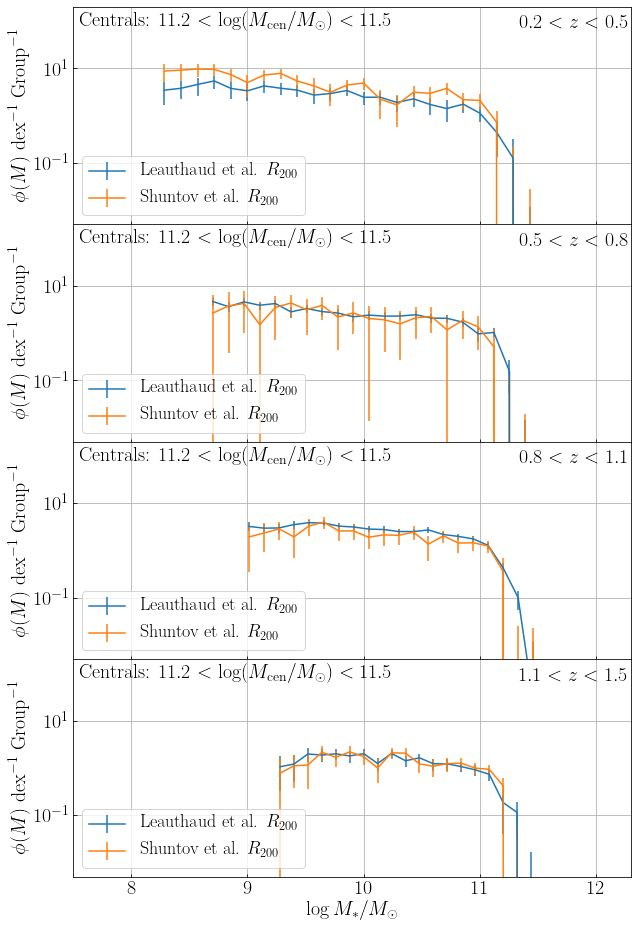

In [402]:
# alternative R200 SSMF

fig, axs = plt.subplots(4, 1, figsize = (10, 16),sharex=True,sharey=True)
q_colors = ['lightsalmon','red','brown','maroon']
sf_colors = ['cornflowerblue','blue','darkblue','midnightblue']
all_colors  = ['lightgray','darkgray','gray','black']
color_sets = [all_colors, sf_colors, q_colors]

csfq='all'
ssfq='all'
count_type = 'sat'
masscut_host=11.2
masscut_host_high=11.5

path = 'smf_pcat/test_smf_cenmass_'+str(masscut_host)+'_'+str(masscut_host_high)+'/'
path2 = 'smf_pcat/test_smf_altR200_'+str(masscut_host)+'_'+str(masscut_host_high)+'/'

fit_data = False
fit_params = []
fit_params_err = []

masscut_lows=[8.0, 8.3, 8.5, 8.8]
colors = ['k','b']
for i,z in enumerate(z_mins):   
    masscut_low = masscut_lows[i]
    m_bin_left_edges = np.linspace(masscut_low, masscut_high, num=num_bins+1)[:-1]
    bin_size = m_bin_left_edges[1] - m_bin_left_edges[0]
    mlim_index = np.searchsorted(m_bin_left_edges,mass_limits[i])
    
    n_centrals, smf_avg, smf_inf, smf_sup = combine_deep_smf(path, ssfq, count_type, str(z), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins,relative_cut='r_scale')
    y_error = np.array([smf_avg[mlim_index:]-smf_inf[mlim_index:],smf_sup[mlim_index:]-smf_avg[mlim_index:]])
    # y_error = np.sqrt(smf_avg*n_centrals)/n_centrals
    
    axs[i].errorbar(m_bin_left_edges[mlim_index:], smf_avg[mlim_index:]/bin_size, yerr=y_error/bin_size, label='Leauthaud et al. $R_{200}$')  
    
    n_centrals, smf_avg, smf_inf, smf_sup = combine_deep_smf(path2, ssfq, count_type, str(z), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins,relative_cut='r_scale')
    y_error = np.array([smf_avg[mlim_index:]-smf_inf[mlim_index:],smf_sup[mlim_index:]-smf_avg[mlim_index:]])
    # y_error = np.sqrt(smf_avg*n_centrals)/n_centrals
    
    axs[i].errorbar(m_bin_left_edges[mlim_index:], smf_avg[mlim_index:]/bin_size, yerr=y_error/bin_size,label='Shuntov et al. $R_{200}$')  
    
    print(str(round(z_mins[i],1))+'<z<'+str(round(z_maxs[i],1)), 'No. of satellites', round(sum(smf_avg),1))
    
    axs[i].set_ylabel(r'$\phi(M)~\mathrm{dex}^{-1} ~\mathrm{Group}^{-1}$',fontsize=20)
    axs[i].set_yscale('log')
    axs[i].set_xlim([7.5,12.3])
    axs[i].set_ylim([5e-3,200])
    axs[i].legend(fontsize=18, loc='lower left')
    axs[i].annotate('$'+str(round(z_mins[i],1))+'<z<'+str(round(z_maxs[i],1))+'$',xy=([0.8,0.9]),xycoords='axes fraction',fontsize=20,color='k')
    axs[i].annotate('Centrals: '+'$'+str(masscut_host)+'<\log(M_\mathrm{cen}/M_\odot)<'+str(masscut_host_high)+'$',xy=([0.01,0.9]),xycoords='axes fraction',fontsize=20,color='k')
    axs[i].grid(True)
    
    if fit_data:
        y_fitting = smf_avg
        y_fitting_err = (smf_sup - smf_avg)
        
        popt, pcov, chi2_ = fit_double_schec_lognormal(m_bin_left_edges, y_fitting, y_fitting_err, start=10,end=-15, zmin=z_mins[i],mu=11, sig=0.3, double_fit=False)
        # popt, pcov, chi2_ = fit_double_schec_varysigma_con(m_bin_left_edges, y_fitting, y_fitting_err, start=5,end=-15, zmin=z_mins[i], double_fit=False)
        fit_params.append(popt)
        fit_params_err.append(np.sqrt(np.diag(pcov))) 
    
fig.subplots_adjust(wspace=0, hspace=0)
axs[3].set_xlabel('$\log M_*/M_\odot$',fontsize=20)
       
if fit_data:
    np.save('fit_param_sat_'+ssfq, np.array(fit_params))
    np.save('fit_param_err_sat_'+ssfq, np.array(fit_params_err))


0.2<z<0.5 No. of satellites 5.7
0.5<z<0.8 No. of satellites 5.8
0.8<z<1.1 No. of satellites 4.4
1.1<z<1.5 No. of satellites 2.2


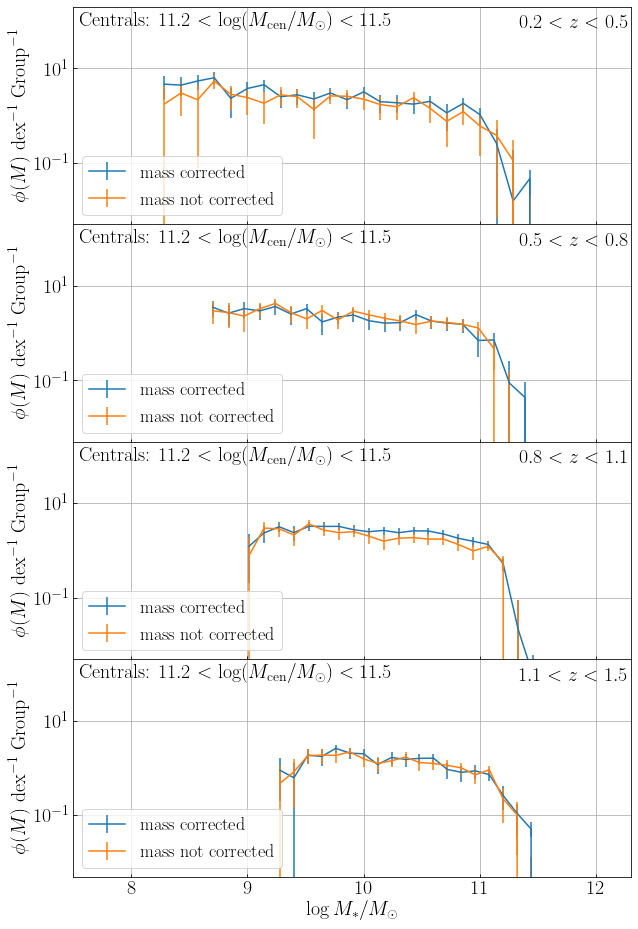

In [417]:
# mass corr vs. no mass corr


# inner vs overall SSMF

fig, axs = plt.subplots(4, 1, figsize = (10, 16),sharex=True,sharey=True)
q_colors = ['lightsalmon','red','brown','maroon']
sf_colors = ['cornflowerblue','blue','darkblue','midnightblue']
all_colors  = ['lightgray','darkgray','gray','black']
color_sets = [all_colors, sf_colors, q_colors]

csfq='all'
ssfq='all'
count_type = 'sat'
masscut_host=11.2
masscut_host_high=11.5
num_bins = 35 # number of bin edges
path = 'smf_pcat/test_smf_cenmass_masscorr_'+str(masscut_host)+'_'+str(masscut_host_high)+'/'
path2 = 'smf_pcat/test_smf_cenmass_nomasscorr_'+str(masscut_host)+'_'+str(masscut_host_high)+'/'

fit_data = False
fit_params = []
fit_params_err = []

masscut_lows=[8.0, 8.3, 8.5, 8.8]
colors = ['k','b']
for i,z in enumerate(z_mins):   
    masscut_low = masscut_lows[i]
    m_bin_left_edges = np.linspace(masscut_low, masscut_high, num=num_bins+1)[:-1]
    bin_size = m_bin_left_edges[1] - m_bin_left_edges[0]
    mlim_index = np.searchsorted(m_bin_left_edges,mass_limits[i])
    
    ##### curve 1
    n_centrals, smf_avg, smf_inf, smf_sup = combine_deep_smf(path, ssfq, count_type, str(z), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins,relative_cut='r_scale')
    y_error = np.array([smf_avg[mlim_index:]-smf_inf[mlim_index:],smf_sup[mlim_index:]-smf_avg[mlim_index:]])
    # y_error = np.sqrt(smf_avg*n_centrals)/n_centrals
    
    axs[i].errorbar(m_bin_left_edges[mlim_index:], smf_avg[mlim_index:]/bin_size, yerr=y_error/bin_size,label='mass corrected')  
    
    
    ##### curve 2
    n_centrals, smf_avg, smf_inf, smf_sup = combine_deep_smf(path2, ssfq, count_type, str(z), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins,relative_cut='r_scale')
    y_error = np.array([smf_avg[mlim_index:]-smf_inf[mlim_index:],smf_sup[mlim_index:]-smf_avg[mlim_index:]])
    # y_error = np.sqrt(smf_avg*n_centrals)/n_centrals
    
    axs[i].errorbar(m_bin_left_edges[mlim_index:], smf_avg[mlim_index:]/bin_size, yerr=y_error/bin_size,label='mass not corrected')  
    
    print(str(round(z_mins[i],1))+'<z<'+str(round(z_maxs[i],1)), 'No. of satellites', round(sum(smf_avg),1))
    
    axs[i].set_ylabel(r'$\phi(M)~\mathrm{dex}^{-1} ~\mathrm{Group}^{-1}$',fontsize=20)
    axs[i].set_yscale('log')
    axs[i].set_xlim([7.5,12.3])
    axs[i].set_ylim([5e-3,200])
    axs[i].annotate('$'+str(round(z_mins[i],1))+'<z<'+str(round(z_maxs[i],1))+'$',xy=([0.8,0.9]),xycoords='axes fraction',fontsize=20,color='k')
    axs[i].annotate('Centrals: '+'$'+str(masscut_host)+'<\log(M_\mathrm{cen}/M_\odot)<'+str(masscut_host_high)+'$',xy=([0.01,0.9]),xycoords='axes fraction',fontsize=20,color='k')
    axs[i].grid(True)
    axs[i].legend(fontsize=18, loc='lower left')
    
    if fit_data:
        y_fitting = smf_avg
        y_fitting_err = (smf_sup - smf_avg)
        
        popt, pcov, chi2_ = fit_double_schec_lognormal(m_bin_left_edges, y_fitting, y_fitting_err, start=10,end=-15, zmin=z_mins[i],mu=11, sig=0.3, double_fit=False)
        # popt, pcov, chi2_ = fit_double_schec_varysigma_con(m_bin_left_edges, y_fitting, y_fitting_err, start=5,end=-15, zmin=z_mins[i], double_fit=False)
        fit_params.append(popt)
        fit_params_err.append(np.sqrt(np.diag(pcov))) 
    
fig.subplots_adjust(wspace=0, hspace=0)
axs[3].set_xlabel('$\log M_*/M_\odot$',fontsize=20)
       
if fit_data:
    np.save('fit_param_sat_'+ssfq, np.array(fit_params))
    np.save('fit_param_err_sat_'+ssfq, np.array(fit_params_err))

0.2<z<0.5 No. of satellites 10.9
0.5<z<0.8 No. of satellites 7.7
0.8<z<1.1 No. of satellites 5.9
1.1<z<1.5 No. of satellites 3.1


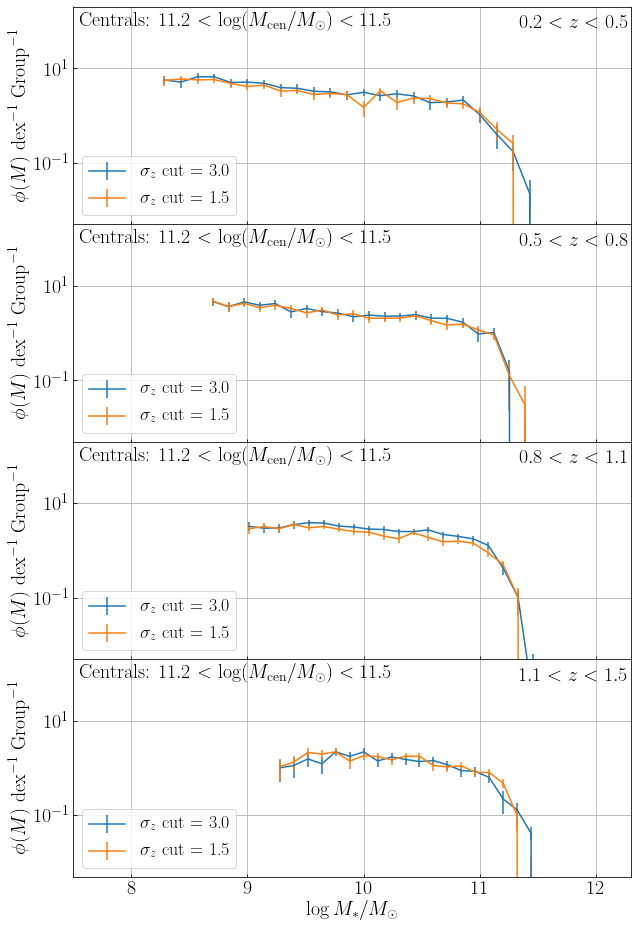

In [419]:
# sat_z_cut 1.5 vs 3.0
# inner vs overall SSMF

fig, axs = plt.subplots(4, 1, figsize = (10, 16),sharex=True,sharey=True)
q_colors = ['lightsalmon','red','brown','maroon']
sf_colors = ['cornflowerblue','blue','darkblue','midnightblue']
all_colors  = ['lightgray','darkgray','gray','black']
color_sets = [all_colors, sf_colors, q_colors]

csfq='all'
ssfq='all'
count_type = 'sat'
masscut_host=11.2
masscut_host_high=11.5
path = 'smf_pcat/test_smf_cenmass_'+str(masscut_host)+'_'+str(masscut_host_high)+'/'
path2 = 'smf_pcat/test_smf_cenmass_satzcut1.5_'+str(masscut_host)+'_'+str(masscut_host_high)+'/'

fit_data = False
fit_params = []
fit_params_err = []

masscut_lows=[8.0, 8.3, 8.5, 8.8]
colors = ['k','b']
for i,z in enumerate(z_mins):   
    masscut_low = masscut_lows[i]
    m_bin_left_edges = np.linspace(masscut_low, masscut_high, num=num_bins+1)[:-1]
    bin_size = m_bin_left_edges[1] - m_bin_left_edges[0]
    mlim_index = np.searchsorted(m_bin_left_edges,mass_limits[i])
    
    n_centrals, smf_avg, smf_inf, smf_sup = combine_deep_smf(path, ssfq, count_type, str(z), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins,relative_cut='r_scale')
    y_error = np.array([smf_avg[mlim_index:]-smf_inf[mlim_index:],smf_sup[mlim_index:]-smf_avg[mlim_index:]])
    # y_error = np.sqrt(smf_avg*n_centrals)/n_centrals
    
    axs[i].errorbar(m_bin_left_edges[mlim_index:], smf_avg[mlim_index:]/bin_size, yerr=y_error/bin_size,label='$\sigma_z$ cut = 3.0')  
    
    n_centrals, smf_avg, smf_inf, smf_sup = combine_deep_smf(path2, ssfq, count_type, str(z), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins,relative_cut='r_scale')
    y_error = np.array([smf_avg[mlim_index:]-smf_inf[mlim_index:],smf_sup[mlim_index:]-smf_avg[mlim_index:]])
    # y_error = np.sqrt(smf_avg*n_centrals)/n_centrals
    
    axs[i].errorbar(m_bin_left_edges[mlim_index:], smf_avg[mlim_index:]/bin_size, yerr=y_error/bin_size,label='$\sigma_z$ cut = 1.5')  
    
    print(str(round(z_mins[i],1))+'<z<'+str(round(z_maxs[i],1)), 'No. of satellites', round(sum(smf_avg),1))
    
    axs[i].set_ylabel(r'$\phi(M)~\mathrm{dex}^{-1} ~\mathrm{Group}^{-1}$',fontsize=20)
    axs[i].set_yscale('log')
    axs[i].set_xlim([7.5,12.3])
    axs[i].set_ylim([5e-3,200])
    axs[i].annotate('$'+str(round(z_mins[i],1))+'<z<'+str(round(z_maxs[i],1))+'$',xy=([0.8,0.9]),xycoords='axes fraction',fontsize=20,color='k')
    axs[i].annotate('Centrals: '+'$'+str(masscut_host)+'<\log(M_\mathrm{cen}/M_\odot)<'+str(masscut_host_high)+'$',xy=([0.01,0.9]),xycoords='axes fraction',fontsize=20,color='k')
    axs[i].grid(True)
    axs[i].legend(fontsize=18, loc='lower left')
    
    if fit_data:
        y_fitting = smf_avg
        y_fitting_err = (smf_sup - smf_avg)
        
        popt, pcov, chi2_ = fit_double_schec_lognormal(m_bin_left_edges, y_fitting, y_fitting_err, start=10,end=-15, zmin=z_mins[i],mu=11, sig=0.3, double_fit=False)
        # popt, pcov, chi2_ = fit_double_schec_varysigma_con(m_bin_left_edges, y_fitting, y_fitting_err, start=5,end=-15, zmin=z_mins[i], double_fit=False)
        fit_params.append(popt)
        fit_params_err.append(np.sqrt(np.diag(pcov))) 
    
fig.subplots_adjust(wspace=0, hspace=0)
axs[3].set_xlabel('$\log M_*/M_\odot$',fontsize=20)
       
if fit_data:
    np.save('fit_param_sat_'+ssfq, np.array(fit_params))
    np.save('fit_param_err_sat_'+ssfq, np.array(fit_params_err))


0.2<z<0.5 No. of satellites -1.4
0.5<z<0.8 No. of satellites -1.5
0.8<z<1.1 No. of satellites -1.7
1.1<z<1.5 No. of satellites -1.7


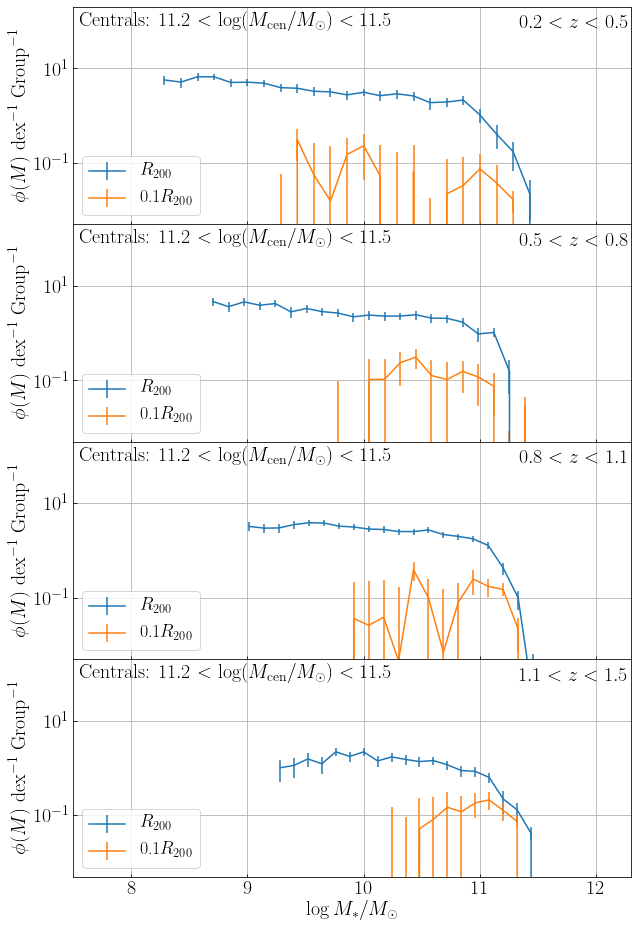

In [421]:
# within 0.1 R200 result

fig, axs = plt.subplots(4, 1, figsize = (10, 16),sharex=True,sharey=True)
q_colors = ['lightsalmon','red','brown','maroon']
sf_colors = ['cornflowerblue','blue','darkblue','midnightblue']
all_colors  = ['lightgray','darkgray','gray','black']
color_sets = [all_colors, sf_colors, q_colors]

csfq='all'
ssfq='all'
count_type = 'sat'
masscut_host=11.2
masscut_host_high=11.5
path = 'smf_pcat/test_smf_cenmass_'+str(masscut_host)+'_'+str(masscut_host_high)+'/'

fit_data = False
fit_params = []
fit_params_err = []

masscut_lows=[8.0, 8.3, 8.5, 8.8]
colors = ['k','b']
for i,z in enumerate(z_mins):   
    masscut_low = masscut_lows[i]
    m_bin_left_edges = np.linspace(masscut_low, masscut_high, num=num_bins+1)[:-1]
    bin_size = m_bin_left_edges[1] - m_bin_left_edges[0]
    mlim_index = np.searchsorted(m_bin_left_edges,mass_limits[i])
    
    ##### curve 1
    n_centrals, smf_avg, smf_inf, smf_sup = combine_deep_smf(path, ssfq, count_type, str(z), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins,relative_cut='r_scale')
    y_error = np.array([smf_avg[mlim_index:]-smf_inf[mlim_index:],smf_sup[mlim_index:]-smf_avg[mlim_index:]])
    # y_error = np.sqrt(smf_avg*n_centrals)/n_centrals
    
    axs[i].errorbar(m_bin_left_edges[mlim_index:], smf_avg[mlim_index:]/bin_size, yerr=y_error/bin_size,label='$R_{200}$')  
    
    ##### curve 2
    n_centrals, smf_avg, smf_inf, smf_sup = combine_deep_smf(path, ssfq, count_type, str(z), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins,relative_cut='r_scale',rfactor=0.1)
    y_error = np.array([smf_avg[mlim_index:]-smf_inf[mlim_index:],smf_sup[mlim_index:]-smf_avg[mlim_index:]])
    # y_error = np.sqrt(smf_avg*n_centrals)/n_centrals
    
    axs[i].errorbar(m_bin_left_edges[mlim_index:], smf_avg[mlim_index:]/bin_size, yerr=y_error/bin_size,label='0.1$R_{200}$')  
    
    print(str(round(z_mins[i],1))+'<z<'+str(round(z_maxs[i],1)), 'No. of satellites', round(sum(smf_avg),1))
    
    axs[i].set_ylabel(r'$\phi(M)~\mathrm{dex}^{-1} ~\mathrm{Group}^{-1}$',fontsize=20)
    axs[i].set_yscale('log')
    axs[i].set_xlim([7.5,12.3])
    axs[i].set_ylim([5e-3,200])
    axs[i].annotate('$'+str(round(z_mins[i],1))+'<z<'+str(round(z_maxs[i],1))+'$',xy=([0.8,0.9]),xycoords='axes fraction',fontsize=20,color='k')
    axs[i].annotate('Centrals: '+'$'+str(masscut_host)+'<\log(M_\mathrm{cen}/M_\odot)<'+str(masscut_host_high)+'$',xy=([0.01,0.9]),xycoords='axes fraction',fontsize=20,color='k')
    axs[i].grid(True)
    axs[i].legend(fontsize=18, loc='lower left')
    
    if fit_data:
        y_fitting = smf_avg
        y_fitting_err = (smf_sup - smf_avg)
        
        popt, pcov, chi2_ = fit_double_schec_lognormal(m_bin_left_edges, y_fitting, y_fitting_err, start=10,end=-15, zmin=z_mins[i],mu=11, sig=0.3, double_fit=False)
        # popt, pcov, chi2_ = fit_double_schec_varysigma_con(m_bin_left_edges, y_fitting, y_fitting_err, start=5,end=-15, zmin=z_mins[i], double_fit=False)
        fit_params.append(popt)
        fit_params_err.append(np.sqrt(np.diag(pcov))) 
    
fig.subplots_adjust(wspace=0, hspace=0)
axs[3].set_xlabel('$\log M_*/M_\odot$',fontsize=20)
       
if fit_data:
    np.save('fit_param_sat_'+ssfq, np.array(fit_params))
    np.save('fit_param_err_sat_'+ssfq, np.array(fit_params_err))



smf_pcat/test_smf_cenmass_10.5_10.8/
smf_pcat/test_smf_cenmass_11.0_11.2/
smf_pcat/test_smf_cenmass_11.2_11.5/


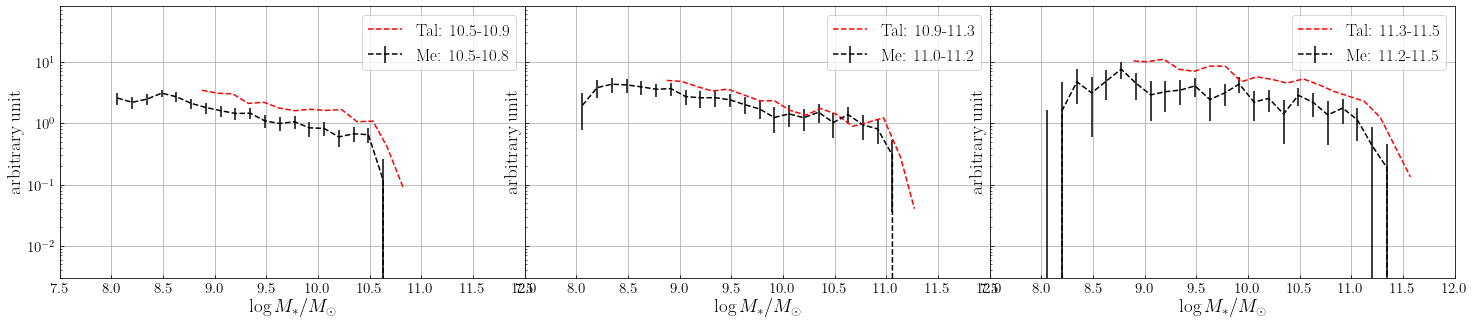

In [1196]:
# overplot Tal+14 results

fig, axs = plt.subplots(1, 3, figsize = (25, 5),sharex=True,sharey=True)
count_type = 'sat'
num_bins = 35 # number of bin edges

z_idx = 0
masscut_low = masscut_lows[z_idx]
   
# Tal+14 smf
smf_tal =  np.load('smf_lit/smf_sat_tal_0.2_0.5_10.5_10.9.npy')
axs[0].plot(smf_tal[:,0],smf_tal[:,1],'--',color='r',label='Tal: 10.5-10.9')

smf_tal =  np.load('smf_lit/smf_sat_tal_0.2_0.5_10.9_11.3.npy')
axs[1].plot(smf_tal[:,0],smf_tal[:,1],'--',color='r',label='Tal: 10.9-11.3')

smf_tal =  np.load('smf_lit/smf_sat_tal_0.2_0.5_11.3_11.5.npy')
axs[2].plot(smf_tal[:,0],smf_tal[:,1],'--',color='r',label='Tal: 11.3-11.5')

# my SSMF
masscut_host_list = [10.5,11.0,11.2]
masscut_host_high_list = [10.8,11.2,11.5]
for m_idx in range(len(masscut_host_list)):
    masscut_host = masscut_host_list[m_idx]
    masscut_host_high = masscut_host_high_list[m_idx]
    
    path = 'smf_pcat/test_smf_cenmass_'+str(masscut_host)+'_'+str(masscut_host_high)+'/'
    print(path)
    m_bin_left_edges = np.linspace(masscut_low, masscut_high, num=num_bins+1)[:-1]
    
    n_centrals, smf_avg, smf_inf, smf_sup = combine_deep_smf(path, ssfq, count_type, str(0.2), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins,relative_cut='r_scale')
    axs[m_idx].errorbar(m_bin_left_edges+bin_size/2, smf_avg/bin_size, yerr=[smf_avg-smf_inf,smf_sup-smf_avg]/bin_size,fmt='--'+color,label='Me: '+str(masscut_host)+'-'+str(masscut_host_high))
    
    axs[m_idx].grid()
    axs[m_idx].set_xlabel('$\log M_*/M_\odot$',fontsize=19)
    axs[m_idx].set_ylabel('arbitrary unit',fontsize=19)
    axs[m_idx].legend(fontsize=17)

axs[0].set_xlim([7.5,12])
axs[0].set_ylim([3e-3,80])
axs[0].set_yscale('log')
fig.subplots_adjust(wspace=0, hspace=0)


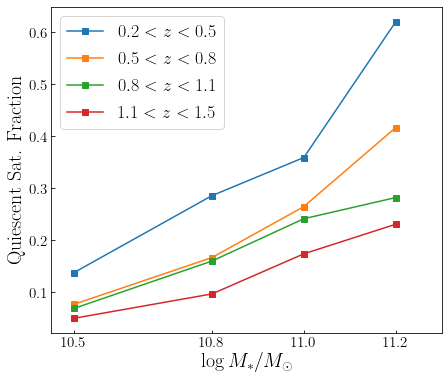

In [1251]:
num_sats = [1,2,3,4]
mass_sats = [10,23,26,30]
mass_cen_mins = [10.5,10.8,11.0,11.2,11.5]
fig, axs = plt.subplots(1, 1, figsize = (7, 6),sharex=True)

for z_idx,z in enumerate(z_mins):
    q_frac = []
    for mcen_idx in np.arange(4):
        masscut_host = mass_cen_mins[mcen_idx]
        masscut_host_high = mass_cen_mins[mcen_idx+1]
        path = 'smf_pcat/test_smf_cenmass_'+str(masscut_host)+'_'+str(masscut_host_high)+'/'
        n_centrals, smf_avg_sf, smf_inf_sf, smf_sup_sf = combine_deep_smf(path, 'ssf', count_type, str(z), masscut_low=str(masscut_low), masscut_host=str(masscut_host), bin_number=num_bins, relative_cut='r_scale')
        n_centrals, smf_avg_q, smf_inf_q, smf_sup_q = combine_deep_smf(path, 'sq', count_type, str(z), masscut_low=str(masscut_low), masscut_host=str(masscut_host), bin_number=num_bins, relative_cut='r_scale')
        smf_avg_sf[smf_avg_sf<0]=0
        smf_avg_q[smf_avg_q<0]=0
        
        n_sf = round(sum(smf_avg_sf),1)
        n_q = round(sum(smf_avg_q),1)
        q_frac.append(n_q/n_sf)
    
    axs.plot(mass_cen_mins[:-1], q_frac,'s-',label='$'+str(z_mins[z_idx])+'<z<'+str(z_maxs[z_idx])+'$') 
    
axs.set_xlabel('$\log M_*/M_\odot$',fontsize=20)
axs.set_ylabel('Quiescent Sat. Fraction',fontsize=20)
axs.legend(fontsize=18)
axs.set_xlim([10.45,11.3])
axs.xaxis.set_ticks(np.array([10.5, 10.8, 11.0, 11.2]))

plt.savefig('/Users/lejay/Desktop/smf_paper/ssmf_sat_qfrac.png')

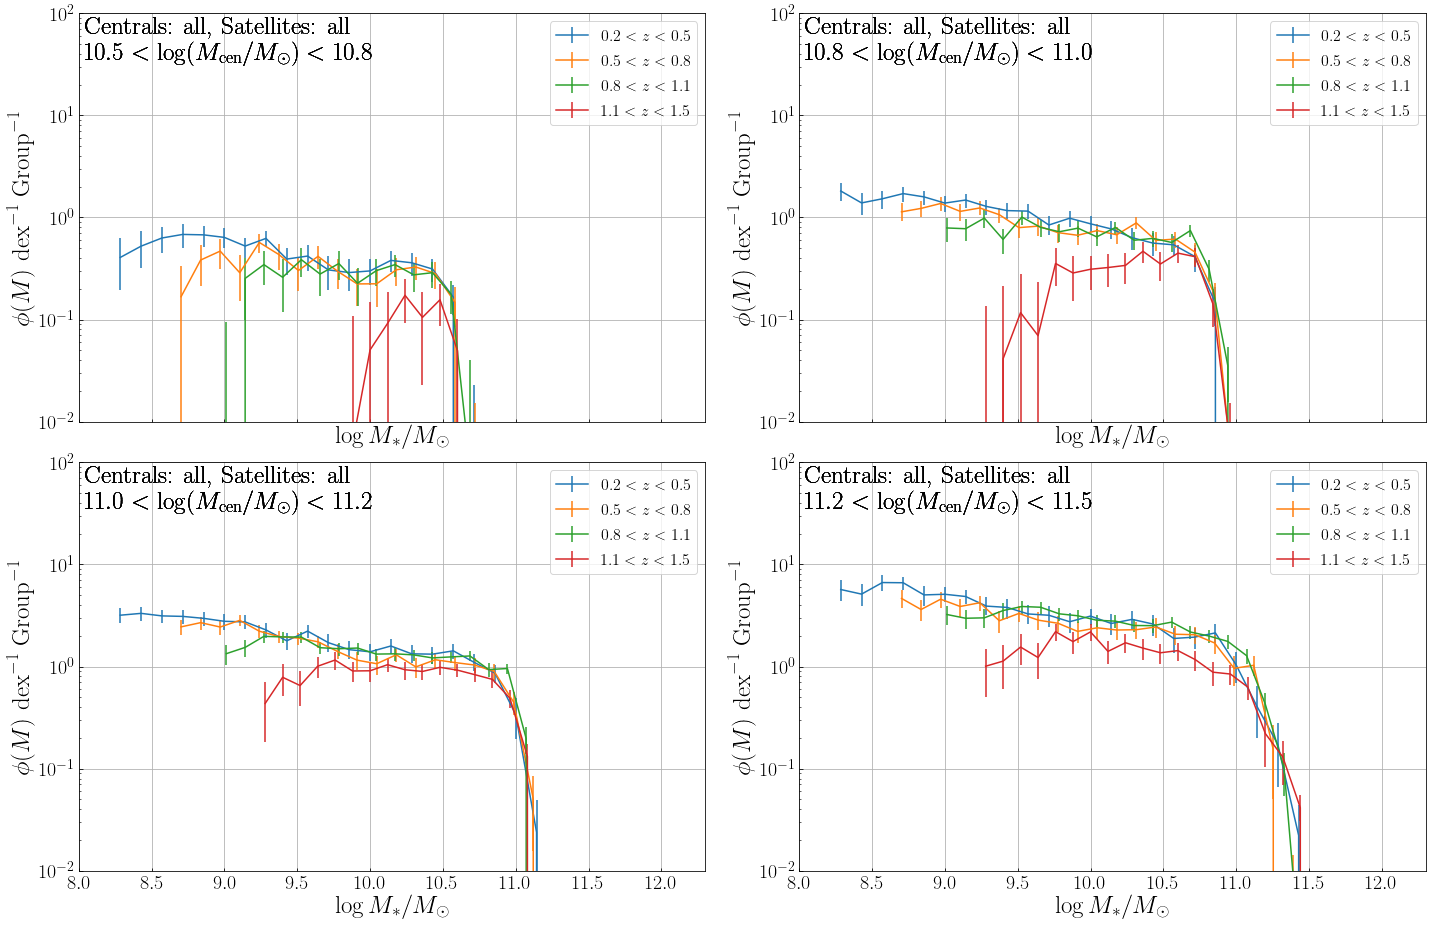

In [411]:
# plot SMF

z_mins = [0.2,0.5,0.8,1.1]
z_maxs = [0.5,0.8,1.1,1.5]
num_bins = 35 # number of bin edges

fig, axs = plt.subplots(2, 2, figsize = (20, 13),sharex=True)
m_cens = [10.5,10.8,11.0,11.2,11.5]
csfq='all'
ssfq='all'
count_type = 'sat'

for mcen_idx in np.arange(len(m_cens[:-1])):
    for z_idx,z in enumerate(z_mins): 
        row = mcen_idx//2
        col = mcen_idx % 2
        
        masscut_low = masscut_lows[z_idx]
        masscut_host = mass_cen_mins[mcen_idx]
        masscut_host_high = mass_cen_mins[mcen_idx+1]

        m_bin_left_edges = np.linspace(masscut_low, masscut_high, num=num_bins+1)[:-1]
        bin_size = m_bin_left_edges[1] - m_bin_left_edges[0]
        mlim_index = np.searchsorted(m_bin_left_edges,mass_limits[z_idx])
        
        path = 'smf_pcat/test_smf_cenmass_'+str(masscut_host)+'_'+str(masscut_host_high)+'/'
        n_centrals, smf_avg, smf_inf, smf_sup = combine_deep_smf(path, ssfq, count_type, str(z), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins,relative_cut='r_scale')
        
        axs[row][col].errorbar(m_bin_left_edges[mlim_index:], smf_avg[mlim_index:]/bin_size,yerr=[smf_avg[mlim_index:]-smf_inf[mlim_index:],smf_sup[mlim_index:]-smf_avg[mlim_index:]]/bin_size,label='$'+str(z_mins[z_idx])+'<z<'+str(z_maxs[z_idx])+'$')  
        axs[row][col].set_ylabel(r'$\phi(M)~\mathrm{dex}^{-1} ~\mathrm{Group}^{-1}$',fontsize=25)
        axs[row][col].set_yscale('log')
        axs[row][col].set_xlim([8,12.3])
        axs[row][col].set_ylim([1e-2,100])
        
        axs[row][col].grid(True)
        axs[row][col].annotate('Centrals: '+csfq+', Satellites: '+ssfq,xy=([0.01,0.95]),xycoords='axes fraction',fontsize=25,color='k')
        axs[row][col].annotate('$'+str(masscut_host)+'<\log(M_\mathrm{cen}/M_\odot)<'+str(masscut_host_high)+'$',xy=([0.01,0.88]),xycoords='axes fraction',fontsize=25,color='k')
        axs[row][col].set_xlabel('$\log M_*/M_\odot$',fontsize=25)
        axs[row][col].legend(fontsize=16)
    
plt.tight_layout()
fig.subplots_adjust(wspace=0.15, hspace=0.1)
plt.savefig('/Users/lejay/Desktop/smf_paper/ssmf_z_evo_allmass.png')

8.8 13.0
smf_pcat/test_smf_cenmass_10.5_10.8/
No. of satellites 1.1
smf_pcat/test_smf_cenmass_10.8_11.0/
No. of satellites 3.2
smf_pcat/test_smf_cenmass_11.0_11.2/
No. of satellites 6.4
smf_pcat/test_smf_cenmass_11.2_11.5/
No. of satellites 11.6
smf_pcat/test_smf_cenmass_10.5_10.8/
No. of satellites 0.6
smf_pcat/test_smf_cenmass_10.8_11.0/
No. of satellites 2.1
smf_pcat/test_smf_cenmass_11.0_11.2/
No. of satellites 4.4
smf_pcat/test_smf_cenmass_11.2_11.5/
No. of satellites 8.0
smf_pcat/test_smf_cenmass_10.5_10.8/
No. of satellites 0.2
smf_pcat/test_smf_cenmass_10.8_11.0/
No. of satellites 1.5
smf_pcat/test_smf_cenmass_11.0_11.2/
No. of satellites 3.4
smf_pcat/test_smf_cenmass_11.2_11.5/
No. of satellites 6.8
smf_pcat/test_smf_cenmass_10.5_10.8/
No. of satellites -0.4
smf_pcat/test_smf_cenmass_10.8_11.0/
No. of satellites 0.3
smf_pcat/test_smf_cenmass_11.0_11.2/
No. of satellites 1.6
smf_pcat/test_smf_cenmass_11.2_11.5/
No. of satellites 2.6


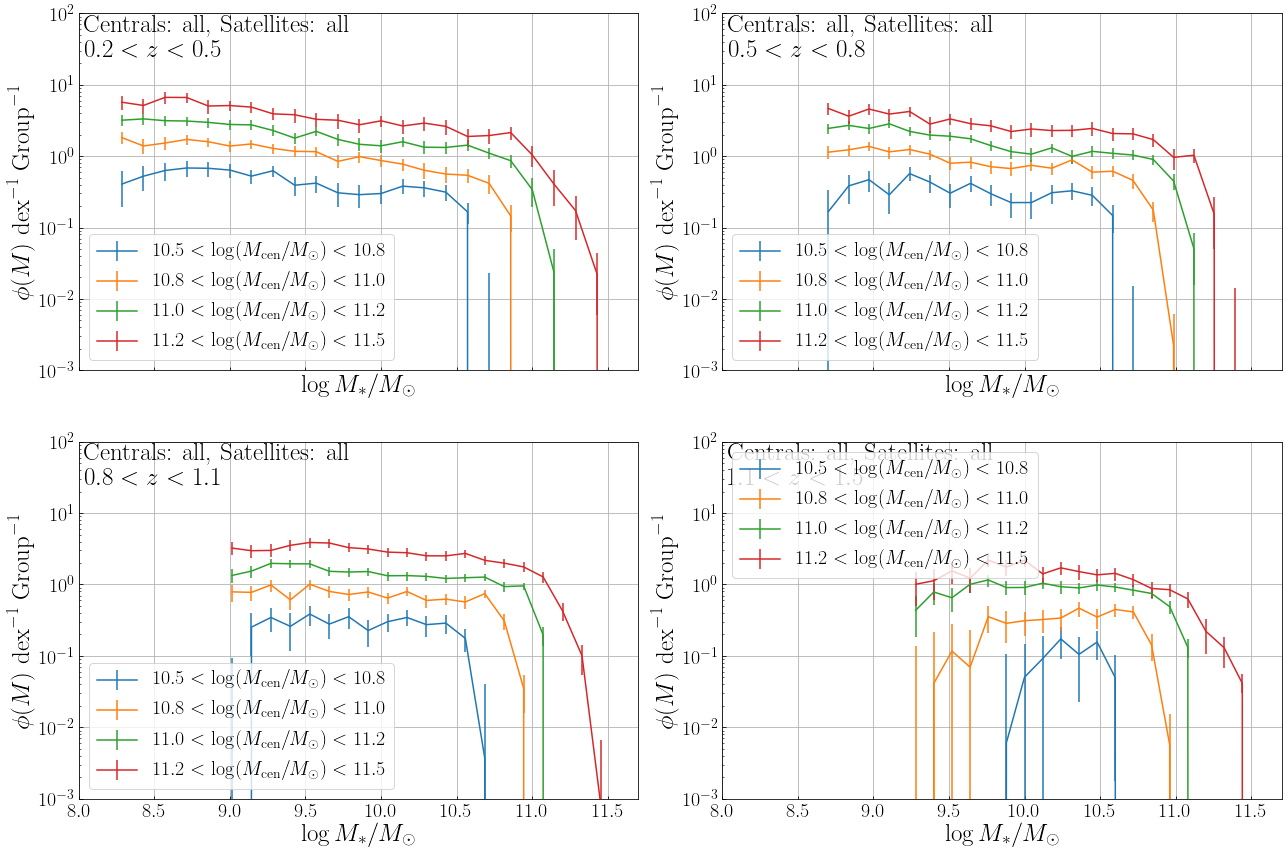

In [412]:
# plot SMF on different central mass cut

fig, axs = plt.subplots(2, 2, figsize = (18, 12),sharex=True)
q_colors = ['lightsalmon','red','brown','maroon']
sf_colors = ['cornflowerblue','blue','darkblue','midnightblue']
all_colors  = ['lightgray','darkgray','gray','black']
color_sets = [all_colors, sf_colors, q_colors]

z_mins = [0.2,0.5,0.8,1.1]
z_maxs = [0.5,0.8,1.1,1.5]
m_cens = [10.5,10.8,11.0,11.2,11.5]
num_bins = 35 # number of bin edges

ssfq='all'
count_type = 'sat'
print(masscut_low, masscut_high)

fit_params = []
fit_params_err = []
for z_idx in range(4):
    for i in range(len(m_cens[:-1])):   
        z = z_mins[z_idx]
        
        masscut_low = masscut_lows[z_idx]
        bins = np.linspace(masscut_low, masscut_high, num=num_bins+1)
        m_bin_left_edges = bins[:-1]
        bin_size = m_bin_left_edges[1] - m_bin_left_edges[0]
        mlim_index = np.searchsorted(m_bin_left_edges,mass_limits[z_idx])
        
        masscut_host = m_cens[i]
        masscut_host_high = m_cens[i+1]
        path = 'smf_pcat/test_smf_cenmass_'+str(masscut_host)+'_'+str(masscut_host_high)+'/'
        print(path)
        
        n_centrals, smf_avg, smf_inf, smf_sup = combine_deep_smf(path, ssfq, count_type, str(z), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins,relative_cut='r_scale')
        print('No. of satellites', round(sum(smf_avg),1))
        smf_avg[smf_avg<0]=0
        
        yerror = [smf_avg[mlim_index:]-smf_inf[mlim_index:],smf_sup[mlim_index:]-smf_avg[mlim_index:]]
        axs[z_idx//2][z_idx%2].errorbar(m_bin_left_edges[mlim_index:], smf_avg[mlim_index:]/bin_size ,yerr=yerror/bin_size, label='$'+str(masscut_host)+'<\log(M_\mathrm{cen}/M_\odot)<'+str(masscut_host_high)+'$')  
        
        axs[z_idx//2][z_idx%2].set_yscale('log')
        axs[z_idx//2][z_idx%2].set_xlim([8,11.7])
        axs[z_idx//2][z_idx%2].set_ylim([1e-3,100])
        axs[z_idx//2][z_idx%2].grid(True)
        
    
    axs[z_idx//2][z_idx%2].set_xlabel('$\log M_*/M_\odot$',fontsize=25)
    axs[z_idx//2][z_idx%2].set_ylabel(r'$\phi(M)~\mathrm{dex}^{-1} ~\mathrm{Group}^{-1}$',fontsize=25)
    axs[z_idx//2][z_idx%2].annotate('$'+str(z_mins[z_idx])+'<z<'+str(z_maxs[z_idx])+'$',xy=([0.01,0.88]),xycoords='axes fraction',fontsize=25,color='k')
    axs[z_idx//2][z_idx%2].annotate('Centrals: '+csfq+', Satellites: '+ssfq,xy=([0.01,0.95]),xycoords='axes fraction',fontsize=25,color='k')
    axs[z_idx//2][z_idx%2].legend(fontsize=20)

plt.tight_layout()
fig.subplots_adjust(wspace=0.15, hspace=0.2)
plt.savefig('/Users/lejay/Desktop/smf_paper/ssmf_mcen_dep.png')

In [230]:
# n_sat vs. M_cen cut 

z_mins = [0.2,0.5,0.8,1.1]
z_maxs = [0.5,0.8,1.1,1.5]
z_idx = 3
num_bins = 50 # number of bin edges

ssfq='all'
count_type = 'sat'
print(masscut_low, masscut_high)

for i,masscut_host in enumerate([10.5,10.8,11.0,11.2]):   
    z = z_mins[z_idx]
    
    masscut_low = masscut_lows[z_idx]
    m_bin_left_edges = np.linspace(masscut_low, masscut_high, num=num_bins+1)[:-1]
    bin_size = m_bin_left_edges[1] - m_bin_left_edges[0]
    
    n_centrals, smf_avg, smf_inf, smf_sup = combine_deep_smf('smf_pcat/test_smf_cenmass_'+str(masscut_host)+'/', ssfq, count_type, str(z), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins)
    print(masscut_host, n_centrals, round(sum(smf_avg),1))

8.0 13.0
10.5 9720.0 22.0
10.8 8707.0 11.7
11.0 6875.0 9.0
11.2 4366.0 8.1


In [235]:
for masscut_host in [10.5, 10.8, 11.0, 11.2]:
    masscut_low = masscut_lows[z_idx]
    m_bin_left_edges = np.linspace(masscut_low, masscut_high, num=num_bins+1)[:-1]
    bin_size = m_bin_left_edges[1] - m_bin_left_edges[0]
    
    n_centrals, smf_avg, smf_inf, smf_sup = combine_deep_smf('smf_pcat/test_smf_cenmass_'+str(masscut_host)+'/', ssfq, count_type, str(z), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins, csfq='all')
    total_mass_sat = sum(smf_avg*10**(m_bin_left_edges-11))
    print('total satellite mass:',round(total_mass_sat,2),'10^11 solar masses')

total satellite mass: 6.98 10^11 solar masses
total satellite mass: 6.02 10^11 solar masses
total satellite mass: 6.34 10^11 solar masses
total satellite mass: 7.7 10^11 solar masses


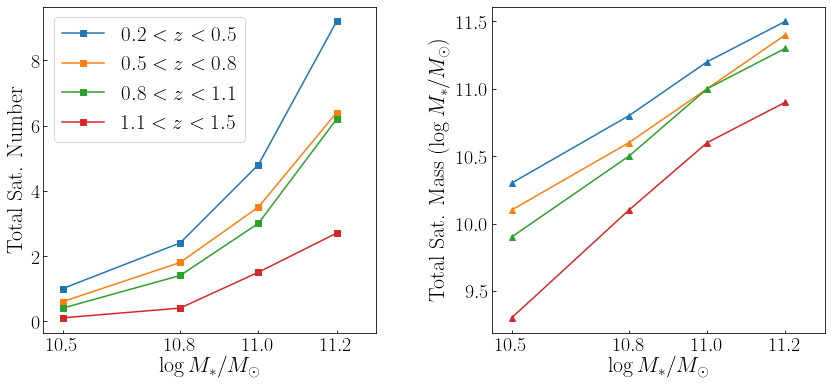

In [414]:
# total number of satellites and total mass of satellites


num_sats = [1,2,3,4]
mass_sats = [10,23,26,30]
mass_cen_mins = [10.5,10.8,11.0,11.2,11.5]
fig, axs = plt.subplots(1, 2, figsize = (14, 6),sharex=True)
mass_limits = [8.205, 8.657, 8.962, 9.26 ]
mass_limits_q = [ 8.752,  9.373,  9.794, 10.204]

for z_idx,z in enumerate(z_mins):
    n_sat = []
    m_sat = []
    for m_cen_idx in np.arange(4):
        masscut_host = mass_cen_mins[m_cen_idx]
        masscut_host_high = mass_cen_mins[m_cen_idx+1]
        mlim_index = np.searchsorted(m_bin_left_edges,9.2)
        
        path = 'smf_pcat/test_smf_cenmass_'+str(masscut_host)+'_'+str(masscut_host_high)+'/'
        n_centrals, smf_avg, smf_inf, smf_sup = combine_deep_smf(path, ssfq, count_type, str(z), masscut_low=str(masscut_low), masscut_host=str(masscut_host), bin_number=num_bins, relative_cut='r_scale')
        smf_avg[smf_avg<0]=0
        
        n_sat.append(round(sum(smf_avg[mlim_index:]),1))
        m_sat.append(round(np.log10(sum(smf_avg[mlim_index:]*10**(m_bin_left_edges[mlim_index:]+bin_size/2))),1))
    
    axs[0].plot(mass_cen_mins[:-1], n_sat,'s-',label='$'+str(z_mins[z_idx])+'<z<'+str(z_maxs[z_idx])+'$') 
    axs[1].plot(mass_cen_mins[:-1], m_sat,'^-')
    
axs[0].set_xlabel('$\log M_*/M_\odot$',fontsize=22)
axs[1].set_xlabel('$\log M_*/M_\odot$',fontsize=22)
axs[0].set_ylabel('Total Sat. Number',fontsize=22)
axs[1].set_ylabel('Total Sat. Mass ($\log M_*/M_\odot$)',fontsize=22)
axs[0].legend(fontsize=21)

axs[0].set_xlim([10.45,11.3])
axs[0].xaxis.set_ticks(np.array([10.5, 10.8, 11.0, 11.2]))
axs[1].xaxis.set_ticks(np.array([10.5, 10.8, 11.0, 11.2]))
fig.subplots_adjust(wspace=0.35, hspace=0.2)
plt.savefig('/Users/lejay/Desktop/smf_paper/ssmf_nsat_mcen.png')

#### relative mass and radius cut

smf_pcat/test_smf_relative_scale_cenmass_10.5_10.8/
smf_pcat/test_smf_relative_scale_cenmass_10.8_11.0/
smf_pcat/test_smf_relative_scale_cenmass_11.0_11.2/
smf_pcat/test_smf_relative_scale_cenmass_11.2_11.5/
smf_pcat/test_smf_relative_scale_cenmass_10.5_10.8/
smf_pcat/test_smf_relative_scale_cenmass_10.8_11.0/
smf_pcat/test_smf_relative_scale_cenmass_11.0_11.2/
smf_pcat/test_smf_relative_scale_cenmass_11.2_11.5/
smf_pcat/test_smf_relative_scale_cenmass_10.5_10.8/
smf_pcat/test_smf_relative_scale_cenmass_10.8_11.0/
smf_pcat/test_smf_relative_scale_cenmass_11.0_11.2/
smf_pcat/test_smf_relative_scale_cenmass_11.2_11.5/
smf_pcat/test_smf_relative_scale_cenmass_10.5_10.8/
smf_pcat/test_smf_relative_scale_cenmass_10.8_11.0/
smf_pcat/test_smf_relative_scale_cenmass_11.0_11.2/
smf_pcat/test_smf_relative_scale_cenmass_11.2_11.5/


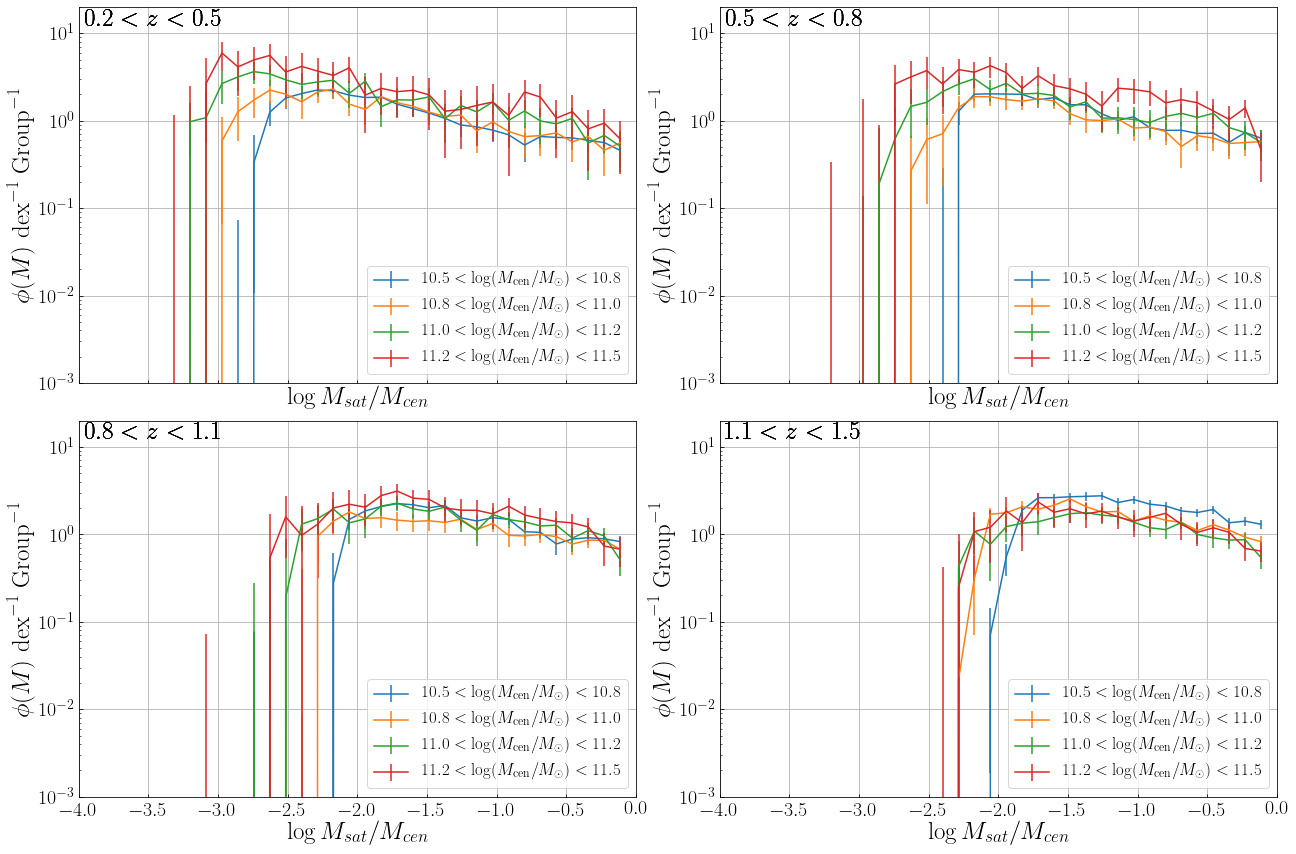

In [312]:
# plot SMF on different central SF/Q (at M>11.0)

colors = ['b','r']
ssfq='all'
count_type = 'sat'

fig, axs = plt.subplots(2, 2, figsize = (18, 12),sharex=True)
z_mins = [0.2,0.5,0.8,1.1]
z_maxs = [0.5,0.8,1.1,1.5]
num_bins = 35 # number of bin edges

m_cens = [10.5,10.8,11.0,11.2,11.5]
for z_idx in range(4):
    for m_idx in np.arange(4):
        masscut_host = m_cens[m_idx]
        masscut_host_high = m_cens[m_idx+1]
        m_bin_left_edges = np.linspace(-4, 0, num=num_bins+1)[:-1]
        
        fit_params = []
        fit_params_err = []
        z = z_mins[z_idx]
        path = 'smf_pcat/test_smf_relative_scale_cenmass_'+str(masscut_host)+'_'+str(masscut_host_high)+'/'
        print(path)
        n_centrals, smf_avg, smf_inf, smf_sup = combine_deep_smf(path, ssfq, count_type, str(z), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins, csfq='all', relative_cut=True)
        axs[z_idx//2][z_idx%2].errorbar(m_bin_left_edges, smf_avg/bin_size,yerr=[smf_avg-smf_inf,smf_sup-smf_avg]/bin_size,label='$'+str(masscut_host)+'<\log(M_\mathrm{cen}/M_\odot)<'+str(masscut_host_high)+'$')  
        
        axs[z_idx//2][z_idx%2].set_yscale('log')
        axs[z_idx//2][z_idx%2].set_xlim([-4,0])
        axs[z_idx//2][z_idx%2].set_ylim([1e-3,20])
        axs[z_idx//2][z_idx%2].grid(True)
            
        
        axs[z_idx//2][z_idx%2].set_xlabel('$\log M_{sat}/M_{cen}$',fontsize=25)
        axs[z_idx//2][z_idx%2].set_ylabel(r'$\phi(M)~\mathrm{dex}^{-1} ~\mathrm{Group}^{-1}$',fontsize=25)
        axs[z_idx//2][z_idx%2].annotate('$'+str(z_mins[z_idx])+'<z<'+str(z_maxs[z_idx])+'$',xy=([0.01,0.95]),xycoords='axes fraction',fontsize=25,color='k')
        axs[z_idx//2][z_idx%2].legend(fontsize=17)

plt.tight_layout()
fig.subplots_adjust(wspace=0.15, hspace=0.1)
plt.savefig('/Users/lejay/Desktop/smf_paper/ssmf_rel_mscale.png')

#### split on central sample

csf 8.8 13.0

cq 8.8 13.0

csf 8.8 13.0

cq 8.8 13.0

csf 8.8 13.0

cq 8.8 13.0

csf 8.8 13.0

cq 8.8 13.0



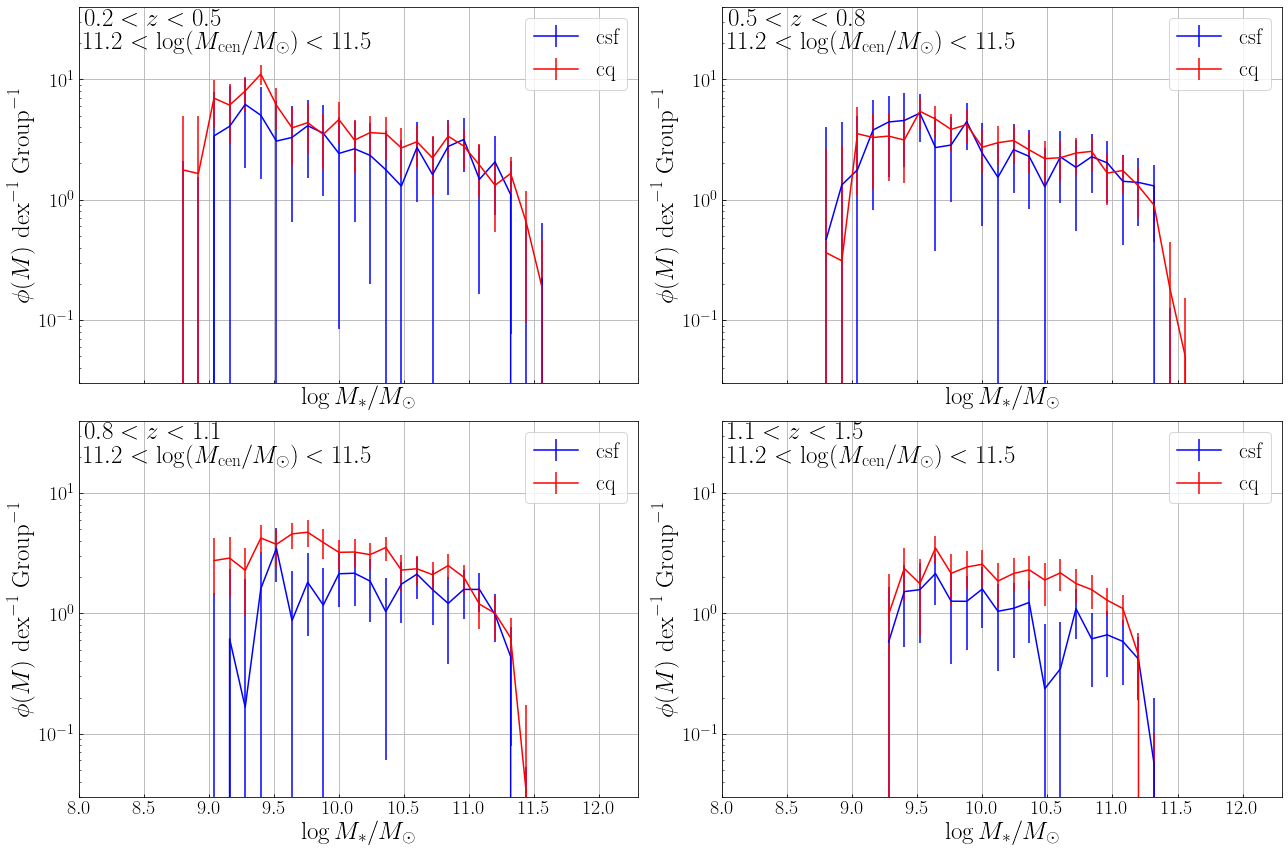

In [392]:
# plot SMF on different central SF/Q (at M>11.0)

fig, axs = plt.subplots(2, 2, figsize = (18, 12),sharex=True)
colors = ['b','r']

z_mins = [0.2,0.5,0.8,1.1]
z_maxs = [0.5,0.8,1.1,1.5]
z_idx = 0
num_bins = 35 # number of bin edges

ssfq='all'
count_type = 'sat'

masscut_host = 11.2
masscut_host_high = 11.5
fit_params = []
fit_params_err = []
for z_idx in range(4):
    for i,cen_sfq in enumerate(['csf','cq']):  
        print(cen_sfq,masscut_low, masscut_high)
        print()
        z = z_mins[z_idx]
        m_bin_left_edges = np.linspace(masscut_low, masscut_high, num=num_bins+1)[:-1]
        mlim_index = np.searchsorted(m_bin_left_edges,mass_limits[z_idx])
        
        path = 'smf_pcat/test_smf_cenmass_'+str(masscut_host)+'_'+str(masscut_host_high)+'/'
        n_centrals, smf_avg, smf_inf, smf_sup = combine_deep_smf(path, ssfq, count_type, str(z), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins, csfq=cen_sfq, relative_cut='r_scale')
        axs[z_idx//2][z_idx%2].errorbar(m_bin_left_edges[mlim_index:], smf_avg[mlim_index:]/bin_size,yerr=[(smf_avg[mlim_index:]-smf_inf[mlim_index:])/bin_size,(smf_sup[mlim_index:]-smf_avg[mlim_index:])/bin_size],label=cen_sfq,color=colors[i])  
        axs[z_idx//2][z_idx%2].set_yscale('log')
        axs[z_idx//2][z_idx%2].set_xlim([8,12.3])
        axs[z_idx//2][z_idx%2].set_ylim([3e-2,40])
        axs[z_idx//2][z_idx%2].grid(True)
        
    axs[z_idx//2][z_idx%2].set_xlabel('$\log M_*/M_\odot$',fontsize=25)
    axs[z_idx//2][z_idx%2].set_ylabel(r'$\phi(M)~\mathrm{dex}^{-1} ~\mathrm{Group}^{-1}$',fontsize=25)
    axs[z_idx//2][z_idx%2].annotate('$'+str(z_mins[z_idx])+'<z<'+str(z_maxs[z_idx])+'$',xy=([0.01,0.95]),xycoords='axes fraction',fontsize=25,color='k')
    axs[z_idx//2][z_idx%2].annotate('$'+str(masscut_host)+'<\log(M_\mathrm{cen}/M_\odot)<'+str(masscut_host_high)+'$',xy=([0.01,0.88]),xycoords='axes fraction',fontsize=25,color='k')
    axs[z_idx//2][z_idx%2].legend(fontsize=22)

plt.tight_layout()
fig.subplots_adjust(wspace=0.15, hspace=0.1)
plt.savefig('/Users/lejay/Desktop/smf_paper/ssmf_cen_csfq.png')

csf 8.0 13.0 11.2 11.5

cq 8.0 13.0 11.2 11.5

csf 8.3 13.0 11.2 11.5

cq 8.3 13.0 11.2 11.5

csf 8.5 13.0 11.2 11.5

cq 8.5 13.0 11.2 11.5

csf 8.8 13.0 11.2 11.5

cq 8.8 13.0 11.2 11.5



/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


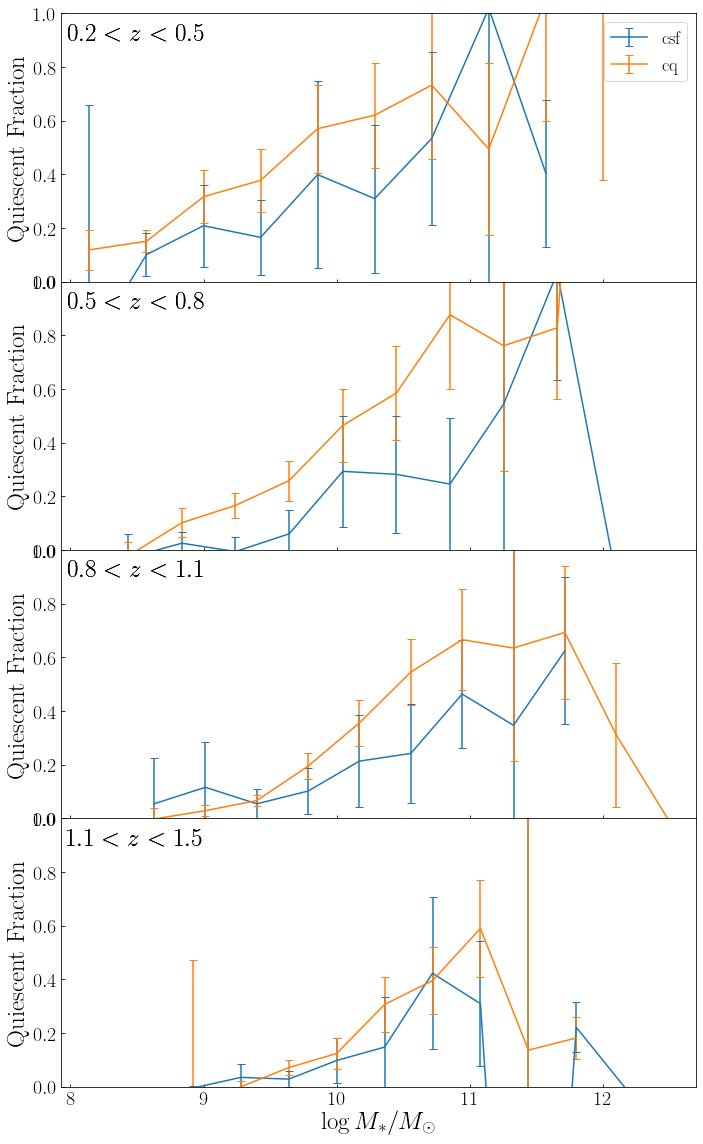

In [308]:
# Q-frac for CQ/CSF
fig, axs = plt.subplots(4, 1, figsize = (10, 16),sharex=True,sharey=True)
z_mins = [0.2,0.5,0.8,1.1]
z_maxs = [0.5,0.8,1.1,1.5]
masscut_lows=[8.0, 8.3, 8.5, 8.8]
rebin_factor = 3
masscut_host=11.2
masscut_host_high=11.5

for z_idx in range(len(z_mins)):
    for i,cen_sfq in enumerate(['csf','cq']):  
        masscut_low = masscut_lows[z_idx]
        m_bin_left_edges = np.linspace(masscut_low, masscut_high, num=num_bins+1)[:-1]
        m_bin_left_edges = rebin_arr(m_bin_left_edges,factor=rebin_factor)
        
        print(cen_sfq,masscut_low, masscut_high,masscut_host,masscut_host_high)
        print()
        z = z_mins[z_idx]
        path = 'smf_pcat/test_smf_cenmass_'+str(masscut_host)+'_'+str(masscut_host_high)+'/'
        
        ssmf_all_sat = combine_deep_smf(path, 'all', count_type, str(z), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins, csfq=cen_sfq, relative_cut='r_scale')
        ssmf_all_sat_avg = ssmf_all_sat[1]
        ssmf_all_sat_inf = ssmf_all_sat[2]
        ssmf_all_sat_sup = ssmf_all_sat[3]
        ssmf_all_sat_avg = rebin_arr(ssmf_all_sat_avg,factor=rebin_factor)
        ssmf_all_sat_inf = rebin_arr(ssmf_all_sat_inf,factor=rebin_factor)
        ssmf_all_sat_sup = rebin_arr(ssmf_all_sat_sup,factor=rebin_factor)
        
        ssmf_all_sat_err = (ssmf_all_sat_sup-ssmf_all_sat_inf)/2/np.sqrt(rebin_factor)
        
        ssmf_q_sat = combine_deep_smf(path, 'sq', count_type, str(z), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins, csfq=cen_sfq, relative_cut='r_scale')
        ssmf_q_sat_avg = ssmf_q_sat[1]
        ssmf_q_sat_inf = ssmf_q_sat[2]
        ssmf_q_sat_sup = ssmf_q_sat[3]
        ssmf_q_sat_avg = rebin_arr(ssmf_q_sat_avg,factor=rebin_factor)
        ssmf_q_sat_inf = rebin_arr(ssmf_q_sat_inf,factor=rebin_factor)
        ssmf_q_sat_sup = rebin_arr(ssmf_q_sat_sup,factor=rebin_factor)
        
        ssmf_q_sat_err = (ssmf_q_sat_sup-ssmf_q_sat_inf)/2/np.sqrt(rebin_factor)
        
        qfrac_sat = ssmf_q_sat_avg / ssmf_all_sat_avg
        qfrac_sat_err = np.sqrt((ssmf_all_sat_err/ssmf_all_sat_avg)**2+(ssmf_q_sat_err/ssmf_q_sat_avg)**2)*(ssmf_q_sat_avg/ssmf_all_sat_avg)
        axs[z_idx].errorbar(m_bin_left_edges, qfrac_sat, yerr=qfrac_sat_err,label=cen_sfq,capsize=4)
        axs[z_idx].annotate('$'+str(z_mins[z_idx])+'<z<'+str(z_maxs[z_idx])+'$',xy=([0.01,0.9]),xycoords='axes fraction',fontsize=25,color='k')
        axs[z_idx].set_ylabel('Quiescent Fraction',fontsize=25)
    
axs[0].set_ylim([0,1])
axs[3].set_xlabel('$\log M_*/M_\odot$',fontsize=25)
axs[0].legend(fontsize=18)
plt.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
plt.savefig('/Users/lejay/Desktop/smf_paper/qfrac_cqcsf.png')

8.0 13.0
0.14285714285714235
smf_pcat/test_smf_cenmass_10.5_10.8/
[ 7.443e-02  1.050e+01 -1.342e-03]
[ 7.443e-02  1.050e+01 -1.342e-03]
8.3 13.0
0.13428571428571345
smf_pcat/test_smf_cenmass_10.5_10.8/
[ 0.072 10.5    0.149]
[ 7.443e-02  1.050e+01 -1.342e-03]
8.5 13.0
0.12857142857142811
smf_pcat/test_smf_cenmass_10.5_10.8/
[ 0.101 10.342  0.523]
[ 7.443e-02  1.050e+01 -1.342e-03]
8.8 13.0
0.11999999999999922
smf_pcat/test_smf_cenmass_10.5_10.8/
[ 0.048 10.42   2.   ]
[ 7.443e-02  1.050e+01 -1.342e-03]
8.0 13.0
0.14285714285714235
smf_pcat/test_smf_cenmass_10.8_11.0/
[ 0.118 10.8   -0.127]
[ 7.443e-02  1.050e+01 -1.342e-03]
8.3 13.0
0.13428571428571345
smf_pcat/test_smf_cenmass_10.8_11.0/
[ 0.12  10.8   -0.044]
[ 7.443e-02  1.050e+01 -1.342e-03]
8.5 13.0
0.12857142857142811
smf_pcat/test_smf_cenmass_10.8_11.0/
[ 0.145 10.8    0.101]
[ 7.443e-02  1.050e+01 -1.342e-03]
8.8 13.0
0.11999999999999922
smf_pcat/test_smf_cenmass_10.8_11.0/
[ 0.145 10.526  0.976]
[ 7.443e-02  1.050e+01 -1.342e-

/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in true_divide


[ 0.167 11.    -0.123]
[ 7.443e-02  1.050e+01 -1.342e-03]
8.5 13.0
0.12857142857142811
smf_pcat/test_smf_cenmass_11.0_11.2/
[ 0.242 11.     0.041]
[ 7.443e-02  1.050e+01 -1.342e-03]
8.8 13.0
0.11999999999999922
smf_pcat/test_smf_cenmass_11.0_11.2/
[ 0.242 10.788  0.319]
[ 7.443e-02  1.050e+01 -1.342e-03]
8.0 13.0
0.14285714285714235
smf_pcat/test_smf_cenmass_11.2_11.5/
[ 0.363 11.027 -0.129]
[ 7.443e-02  1.050e+01 -1.342e-03]
8.3 13.0
0.13428571428571345
smf_pcat/test_smf_cenmass_11.2_11.5/
[ 0.288 11.2   -0.103]
[ 7.443e-02  1.050e+01 -1.342e-03]
8.5 13.0
0.12857142857142811
smf_pcat/test_smf_cenmass_11.2_11.5/
[4.271e-01 1.110e+01 1.970e-03]
[ 7.443e-02  1.050e+01 -1.342e-03]
8.8 13.0
0.11999999999999922
smf_pcat/test_smf_cenmass_11.2_11.5/
[ 0.329 10.848  0.19 ]
[ 7.443e-02  1.050e+01 -1.342e-03]


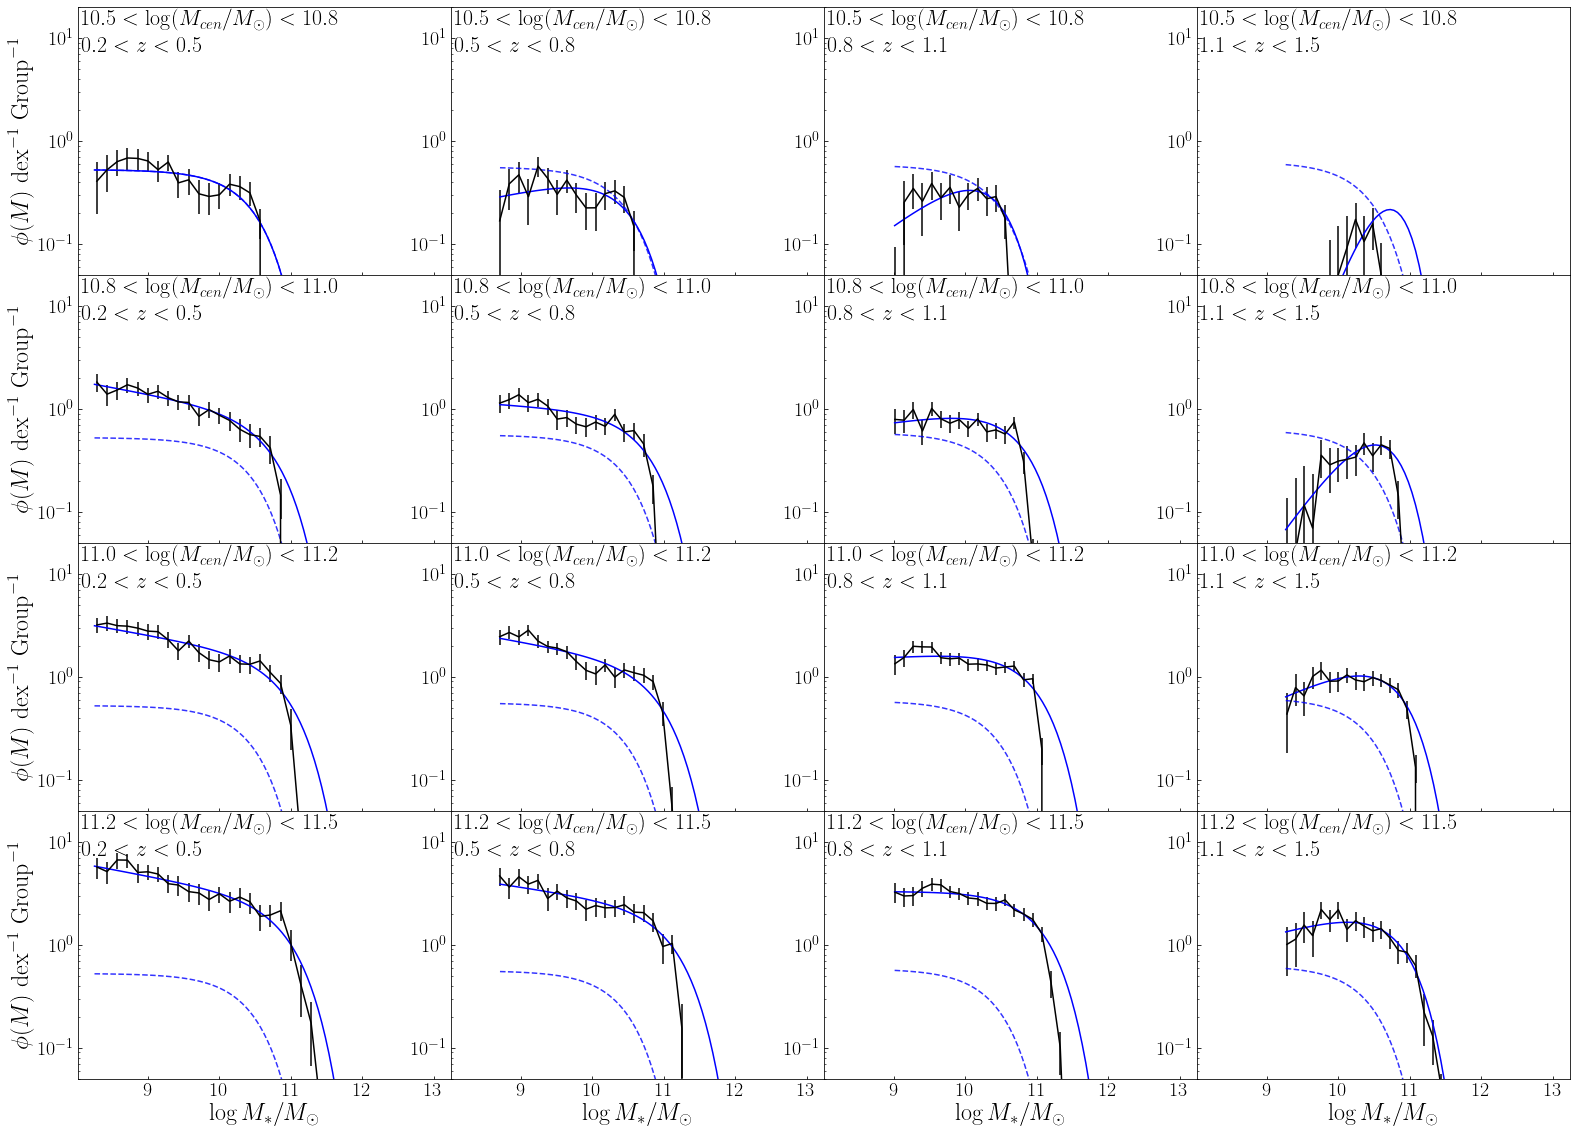

In [410]:
# fitted sat SMFs
z_mins = [0.2,0.5,0.8,1.1]
z_maxs = [0.5,0.8,1.1,1.5]
mass_limits = [8.205, 8.657, 8.962, 9.26 ]
m_cens = [10.5,10.8,11.0,11.2,11.5]
masscut_lows=[8.0, 8.3, 8.5, 8.8]
masscut_high = 13.0

# m_cens = [10.8,11.0,11.2,11.5]
colors = ['k','b','r','g']
num_bins = 35

csfq = 'all'
ssfq = 'all'
count_type='sat'
fit_data='single'

        
fig, axs = plt.subplots(4, 4, figsize = (22, 16),sharex=True)
for i in range(len(m_cens[:-1])):   
    fit_params = []
    fit_params_err = []
    for z_idx in np.arange(len(z_mins)):
        z = z_mins[z_idx]
        masscut_low = masscut_lows[z_idx]
        print(masscut_low,masscut_high)
        bins = np.linspace(masscut_low, masscut_high, num=num_bins+1)
        m_bin_left_edges = bins[:-1]
        bin_size = m_bin_left_edges[1] - m_bin_left_edges[0]
        print(bin_size)
        
        mlim_index_data = np.searchsorted(m_bin_left_edges,mass_limits[z_idx])
        mhigh_index_data = np.searchsorted(m_bin_left_edges,m_cens[i])
        
        masscut_host = m_cens[i]
        masscut_host_high = m_cens[i+1]
        path = 'smf_pcat/test_smf_cenmass_'+str(masscut_host)+'_'+str(masscut_host_high)+'/'
        print(path)
        
        n_centrals, smf_avg, smf_inf, smf_sup = combine_deep_smf(path, ssfq, count_type, str(z), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins, csfq=csfq, relative_cut='r_scale')
        axs[i][z_idx].errorbar(m_bin_left_edges[mlim_index_data:], smf_avg[mlim_index_data:]/bin_size, yerr=[smf_avg[mlim_index_data:]-smf_inf[mlim_index_data:],smf_sup[mlim_index_data:]-smf_avg[mlim_index_data:]]/bin_size,color='k')
        y_fitting = smf_avg
        y_fitting_err = (smf_sup - smf_avg)
        
        if fit_data=='double':
            #fit with double Schechter
            fit_params_field = fit_params_arr[z_idx]
            alpha1 = fit_params_field[2]
            alpha2 = fit_params_field[4]
            popt, pcov, chi2_ = fit_double_schechter(m_bin_left_edges, y_fitting, y_fitting_err, start=mlim_index_data,end=mhigh_index_data)
            fit_params.append(popt)
            fit_params_err.append(np.sqrt(np.diag(pcov)))
            # print(popt)
            
            x_plot = np.linspace(8,13.0,100)
            mlim_index = np.searchsorted(x_plot,mass_limits[z_idx])
            y_plot1 = double_schechter(x_plot, popt[0], popt[1], popt[2],popt[3], popt[4])
        else:
            # fit with single Schechter
            popt, pcov, chi2_ = fit_schechter(m_bin_left_edges, y_fitting, y_fitting_err, start=mlim_index_data,end=mhigh_index_data, mass_ini=masscut_host-0.1)
            fit_params.append(popt)
            fit_params_err.append(np.sqrt(np.diag(pcov)))
            
            x_plot = np.linspace(8,13.0,100)
            mlim_index = np.searchsorted(x_plot,mass_limits[z_idx])
            y_plot1 = schechter(x_plot, popt[0], popt[1], popt[2]) # phi,m_s,alpha
            
            if z_idx==0 and i==0:
                popt_fiducial = popt
    
            print(popt)
            print(popt_fiducial)
        
        axs[i][z_idx].plot(x_plot[mlim_index:],y_plot1[mlim_index:]/bin_size,color='b')
        axs[i][z_idx].plot(np.linspace(8,13.0,100)[mlim_index:],schechter(x_plot, popt_fiducial[0],popt_fiducial[1],popt_fiducial[2])[mlim_index:]/bin_size,color='b',alpha=0.8,linestyle='--')
        axs[i][z_idx].annotate('$'+str(masscut_host)+'<\log(M_{cen}/M_\odot)<'+str(masscut_host_high)+'$',xy=([0.01,0.92]),xycoords='axes fraction',fontsize=22,color='k')
        axs[i][z_idx].annotate('$'+str(z_mins[z_idx])+'<z<'+str(z_maxs[z_idx])+'$',xy=([0.01,0.83]),xycoords='axes fraction',fontsize=22,color='k')
        
        axs[i][z_idx].set_yscale('log')
        axs[i][z_idx].set_ylim([5e-2,20])
        axs[i][z_idx].set_xlabel('$\log M_*/M_\odot$',fontsize=24)
    
    if fit_data=='single':
        np.save('fit_param_single_sat_'+csfq+'_'+str(masscut_host)+'_'+ssfq, np.array(fit_params))
        np.save('fit_param_single_err_sat_'+csfq+'_'+str(masscut_host)+'_'+ssfq, np.array(fit_params_err))
    elif fit_data=='double':
        np.save('fit_param_sat_'+csfq+'_'+str(masscut_host)+'_'+ssfq, np.array(fit_params))
        np.save('fit_param_err_sat_'+csfq+'_'+str(masscut_host)+'_'+ssfq, np.array(fit_params_err))
    axs[i][0].set_ylabel(r'$\phi(M)~\mathrm{dex}^{-1} ~\mathrm{Group}^{-1}$',fontsize=24) 
        
plt.tight_layout()
fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)
plt.savefig('/Users/lejay/Desktop/smf_paper/ssmf_fitted.png')

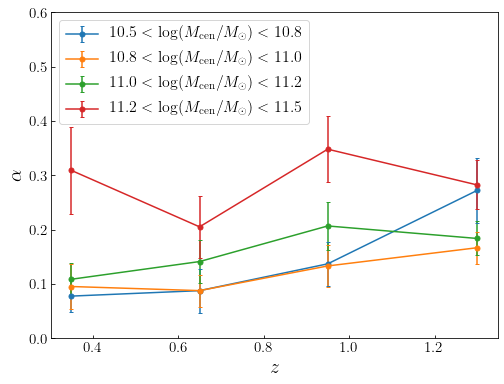

In [1339]:
fig, axs = plt.subplots(1, 1, figsize = (8, 6))
csfq = 'all'
ssfq = 'all'
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
    
m_cens = [10.5,10.8,11.0,11.2,11.5]
for i in range(len(m_cens[:-1])):  
    alpha_list = []
    alpha_err_list = []
    masscut_host = m_cens[i]
    masscut_host_high = m_cens[i+1]
    
    fit_params = np.load('fit_param_single_sat_'+csfq+'_'+str(masscut_host)+'_'+ssfq+'.npy')
    fit_params_err = np.load('fit_param_single_err_sat_'+csfq+'_'+str(masscut_host)+'_'+ssfq+'.npy')
    for z_idx in np.arange(len(z_mins)):
        alpha_list.append(fit_params[z_idx][0])
        alpha_err_list.append(fit_params_err[z_idx][0])
    
    plt.errorbar((np.array(z_maxs)+np.array(z_mins))/2,alpha_list, yerr=alpha_err_list, fmt='.-',capsize=2,markersize=10,label='$'+str(masscut_host)+'<\log(M_\mathrm{cen}/M_\odot)<'+str(masscut_host_high)+'$')
    plt.xlabel(r'$z$',fontsize=20)
    plt.ylabel(r'$\alpha$',fontsize=20)
    plt.ylim([0,0.6])
    plt.legend(fontsize=16)

[[ 3.089e-01  1.100e+01 -8.529e-02]
 [ 2.050e-01  1.133e+01 -1.468e-01]
 [ 3.479e-01  1.107e+01  1.038e-02]
 [ 2.821e-01  1.098e+01  6.502e-02]]
[[ 0.069 11.22  -0.297]
 [ 0.138 10.876 -0.244]
 [ 0.254 10.823 -0.053]
 [ 0.237 10.83   0.052]]
[[ 0.366 10.8    0.268]
 [ 0.392 10.8    0.515]
 [ 0.303 10.8    0.785]
 [ 0.183 10.8    1.18 ]]


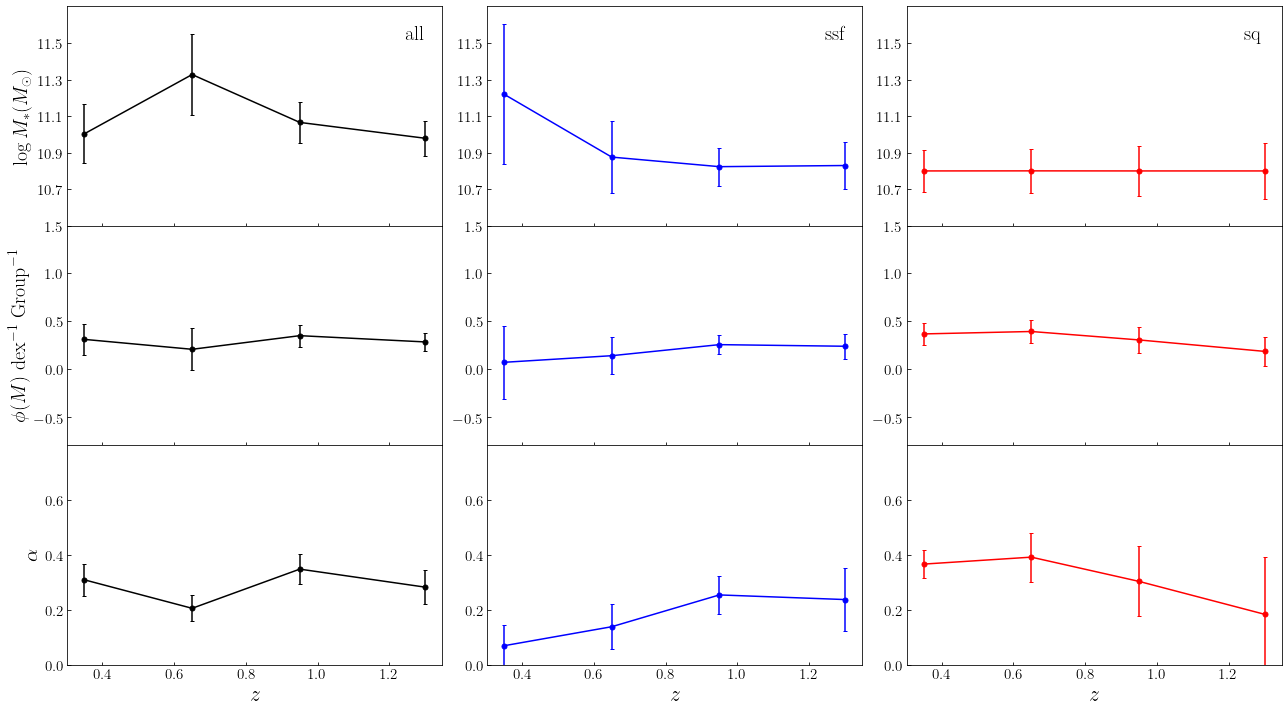

In [1318]:
# fitting parameter evolution plot

fig, axs = plt.subplots(3, 3, figsize = (18, 10))

csfq='all'
masscut_host=11.2
colors = ['k','b','r']

for sfq_idx,ssfq in enumerate(['all','ssf','sq']):
    fit_params = np.load('fit_param_single_sat_'+csfq+'_'+str(masscut_host)+'_'+ssfq+'.npy')
    fit_params_err = np.load('fit_param_single_err_sat_'+csfq+'_'+str(masscut_host)+'_'+ssfq+'.npy')
    print(fit_params)
    
    phi_list = []
    alpha_list = []
    ms_list = []
    phi_err_list = []
    alpha_err_list = []
    ms_err_list = []
    z_mins = [0.2, 0.5, 0.8, 1.1]
    z_maxs = [0.5, 0.8, 1.1, 1.5]
    
    # m_s,phi1,alpha_s1,phi2,alpha_s2,sigma_m (constant sigma_m)
    # m_s,phi1,alpha_s1,phi2,alpha_s2,z_min (varying sigma_m)

    for i in range(4): # 4 z-bins
        phi_list.append(fit_params[i][0])
        alpha_list.append(fit_params[i][0])
        phi_err_list.append(fit_params_err[i][1])
        alpha_err_list.append(fit_params_err[i][2])
    
        ms_list.append(fit_params[i][1])
        ms_err_list.append(fit_params_err[i][1])
        
        if sfq=='q':
            alpha2_err_list = [0,0,0,0]
    # M*
    axs[0][sfq_idx].errorbar((np.array(z_maxs)+np.array(z_mins))/2,ms_list, yerr=ms_err_list, fmt='.-',color=colors[sfq_idx],capsize=2,markersize=10)
    
    # Phi
    axs[1][sfq_idx].errorbar((np.array(z_maxs)+np.array(z_mins))/2,phi_list, yerr=phi_err_list, fmt='.-',color=colors[sfq_idx],capsize=2,markersize=10)
    
    # alpha
    axs[2][sfq_idx].errorbar((np.array(z_maxs)+np.array(z_mins))/2,alpha_list, yerr=alpha_err_list, fmt='.-',color=colors[sfq_idx],capsize=2,markersize=10)
    axs[0][sfq_idx].annotate(ssfq,xy=([0.9,0.85]),xycoords='axes fraction',fontsize=20,color='k')

    axs[2][sfq_idx].set_xlabel(r'$z$',fontsize=22)
    axs[0][0].set_ylabel(r'$\log M_* (M_\odot)$',fontsize=20)
    axs[1][0].set_ylabel(r'$\phi(M)~\mathrm{dex}^{-1} ~\mathrm{Group}^{-1}$',fontsize=20)
    axs[2][0].set_ylabel(r'$\alpha$',fontsize=21)
    
    axs[0][sfq_idx].set_ylim([masscut_host-0.7,masscut_host+0.5])
    axs[1][sfq_idx].set_ylim([-0.8,1.5])
    axs[2][sfq_idx].set_ylim([0,0.8])
    
    axs[0][sfq_idx].yaxis.set_ticks(np.arange(masscut_host-0.5,masscut_host+0.5, 0.2))
    axs[1][sfq_idx].yaxis.set_ticks(np.arange(-0.5,2, 0.5))
    axs[2][sfq_idx].yaxis.set_ticks(np.arange(0,0.8,0.2))
    
plt.tight_layout()
fig.subplots_adjust(hspace=0)
plt.savefig('/Users/lejay/Desktop/smf_paper/ssmf_param_evo.png')

[10.171  0.108  2.     0.116 -0.233]
[10.155  0.13   2.     0.118 -0.241]
[10.092  0.148  2.     0.22  -0.13 ]
[ 1.000e+01  2.464e-01  2.000e+00  3.948e-01 -9.221e-23]
[10.047  0.078  2.     0.095 -0.38   0.2  ]
[10.044  0.094  2.     0.087 -0.471  0.2  ]
[10.012  0.136  2.     0.11  -0.393  0.2  ]
[10.     0.213  1.999  0.138 -0.782  0.2  ]
[10.107  0.112  2.     0.023 -0.138  0.2  ]
[ 1.010e+01  1.047e-01  2.000e+00  8.700e-03 -2.776e-01  2.000e-01]
[ 1.010e+01  8.354e-02  2.000e+00  5.340e-04 -1.283e+00  2.000e-01]
[ 1.011e+01  5.867e-02  2.000e+00  9.077e-05 -2.000e+00  2.000e-01]


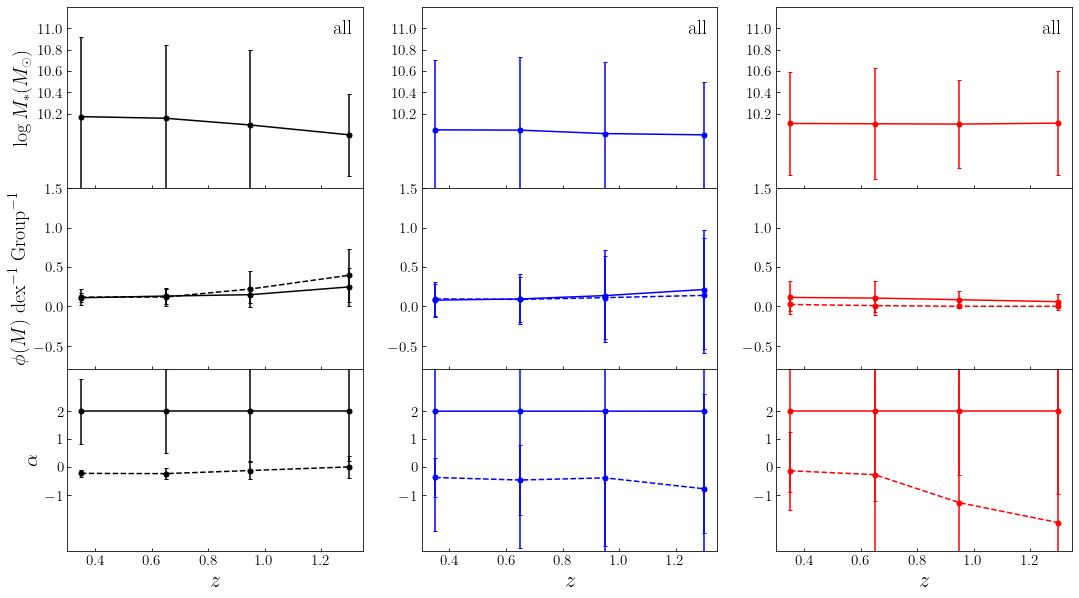

In [1284]:
# fitting parameter evolution plot

fig, axs = plt.subplots(3, 3, figsize = (18, 10))

csfq='all'
masscut_host=11.2
colors = ['k','b','r']

for sfq_idx,ssfq in enumerate(['all','ssf','sq']):
    fit_params = np.load('fit_param_sat_'+csfq+'_'+str(masscut_host)+'_'+ssfq+'.npy')
    fit_params_err = np.load('fit_param_err_sat_'+csfq+'_'+str(masscut_host)+'_'+ssfq+'.npy')
    
    phi1_list = []
    phi2_list = []
    alpha1_list = []
    alpha2_list = []
    ms_list = []
    phi1_err_list = []
    phi2_err_list = []
    alpha1_err_list = []
    alpha2_err_list = []
    ms_err_list = []
    z_mins = [0.2, 0.5, 0.8, 1.1]
    z_maxs = [0.5, 0.8, 1.1, 1.5]
    
    # m_s,phi1,alpha_s1,phi2,alpha_s2,sigma_m (constant sigma_m)
    # m_s,phi1,alpha_s1,phi2,alpha_s2,z_min (varying sigma_m)

    for i in range(4): # 4 z-bins
        print(fit_params[i])
        if fit_params[i][2] > fit_params[i][4]:
            phi1_list.append(fit_params[i][1])
            phi2_list.append(fit_params[i][3])
            alpha1_list.append(fit_params[i][2])
            alpha2_list.append(fit_params[i][4])
            phi1_err_list.append(fit_params_err[i][1])
            phi2_err_list.append(fit_params_err[i][3])
            alpha1_err_list.append(fit_params_err[i][2])
            alpha2_err_list.append(fit_params_err[i][4])
        else:
            phi1_list.append(fit_params[i][3])
            phi2_list.append(fit_params[i][1])
            alpha1_list.append(fit_params[i][4])
            alpha2_list.append(fit_params[i][2])
            phi1_err_list.append(fit_params_err[i][3])
            phi2_err_list.append(fit_params_err[i][1])
            alpha1_err_list.append(fit_params_err[i][4])
            alpha2_err_list.append(fit_params_err[i][2])
    
        ms_list.append(fit_params[i][0])
        ms_err_list.append(fit_params_err[i][0])
        
        if sfq=='q':
            alpha2_err_list = [0,0,0,0]
    # M*
    axs[0][sfq_idx].errorbar((np.array(z_maxs)+np.array(z_mins))/2,ms_list, yerr=ms_err_list, fmt='.-',color=colors[sfq_idx],capsize=2,markersize=10)
    
    # Phi
    axs[1][sfq_idx].errorbar((np.array(z_maxs)+np.array(z_mins))/2,phi1_list, yerr=phi1_err_list, fmt='.-',color=colors[sfq_idx],capsize=2,markersize=10)
    axs[1][sfq_idx].errorbar((np.array(z_maxs)+np.array(z_mins))/2,phi2_list, yerr=phi2_err_list, fmt='.--',color=colors[sfq_idx],capsize=2,markersize=10)
    
    # alpha
    axs[2][sfq_idx].errorbar((np.array(z_maxs)+np.array(z_mins))/2,alpha1_list, yerr=alpha1_err_list, fmt='.-',color=colors[sfq_idx],capsize=2,markersize=10)
    axs[2][sfq_idx].errorbar((np.array(z_maxs)+np.array(z_mins))/2,alpha2_list, yerr=alpha2_err_list, fmt='.--',color=colors[sfq_idx],capsize=2,markersize=10)
    
    axs[0][sfq_idx].annotate(ssfq,xy=([0.9,0.85]),xycoords='axes fraction',fontsize=20,color='k')

    axs[2][sfq_idx].set_xlabel(r'$z$',fontsize=22)
    axs[0][0].set_ylabel(r'$\log M_* (M_\odot)$',fontsize=20)
    axs[1][0].set_ylabel(r'$\phi(M)~\mathrm{dex}^{-1} ~\mathrm{Group}^{-1}$',fontsize=20)
    axs[2][0].set_ylabel(r'$\alpha$',fontsize=21)
    
    axs[0][sfq_idx].set_ylim([9.5,11.2])
    axs[1][sfq_idx].set_ylim([-0.8,1.5])
    axs[2][sfq_idx].set_ylim([-3,3.5])
    
    axs[0][sfq_idx].yaxis.set_ticks(np.arange(10.2,11.2, 0.2))
    axs[1][sfq_idx].yaxis.set_ticks(np.arange(-0.5,2, 0.5))
    axs[2][sfq_idx].yaxis.set_ticks(np.arange(-1,3,1))
    
# fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)

smf_pcat/test_smf_cenmass_11.2_11.5/


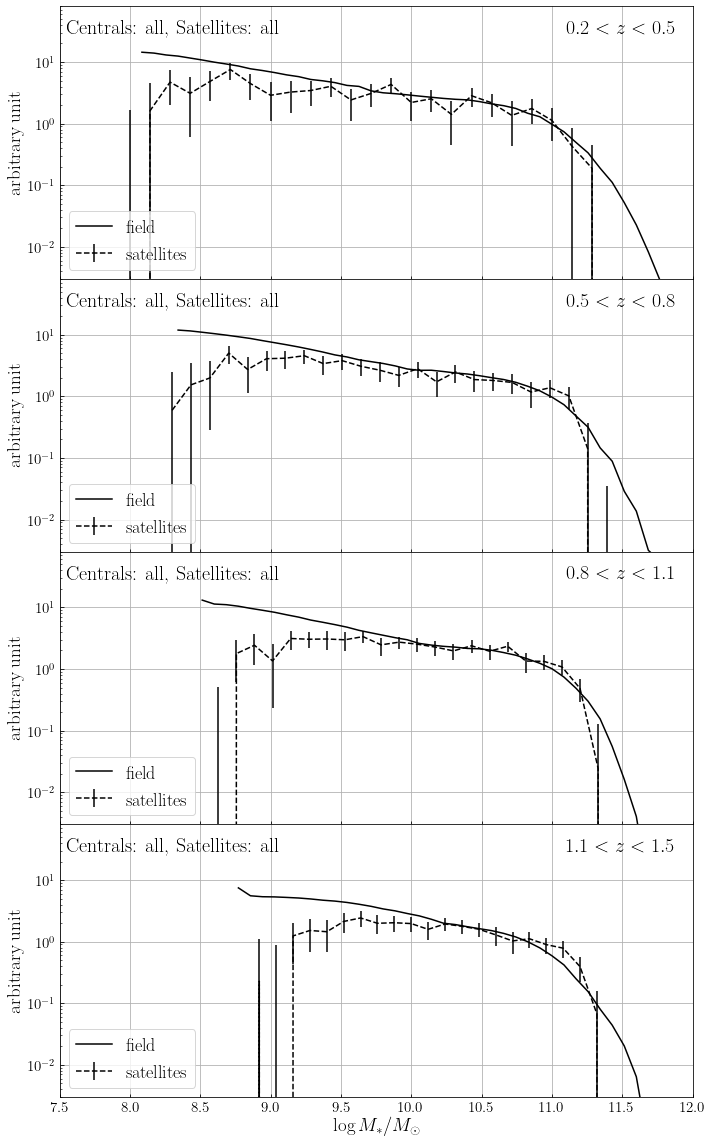

In [1259]:
# compare to the field values
# sat smf
sfq = 'all'
if sfq != 'all':
    ssfq = 's'+sfq
else:
    ssfq = sfq

if sfq == 'sf':
    color = 'b'
    norm_factors = np.array([40,50,80,100])*8
elif sfq == 'q':
    color = 'r'
    norm_factors = np.array([60,60,70,80])*8
else:
    color = 'k'
    norm_factors = np.array([65,80,100,100])*8
    
z_mins = [0.2,0.5,0.8,1.1]
z_maxs = [0.5,0.8,1.1,1.5]
smf_comp_idx = [1,4,6,9]
fig, axs = plt.subplots(4, 1, figsize = (10, 16),sharex=True,sharey=True)

count_type = 'sat'
num_bins = 35 # number of bin edges

masscut_host=11.2
masscut_host_high=11.5
path = 'smf_pcat/test_smf_cenmass_'+str(masscut_host)+'_'+str(masscut_host_high)+'/'
print(path)

fit_params = []
fit_params_err = []
for i,z in enumerate(z_mins):   
    
    # field smf
    bins_field = np.linspace(8,12.2,50)[:-1]
    smf_field = np.load('pcat_smf_nonir_'+sfq+'_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')[0]
    axs[i].plot(bins_field[smf_comp_idx[i]:],smf_field[smf_comp_idx[i]:]*norm_factors[i],'-'+color,label='field')
        
    masscut_low = masscut_lows[i]
    m_bin_left_edges = np.linspace(masscut_low, masscut_high, num=num_bins+1)[:-1]
    n_centrals,smf_sat,smf_inf,smf_sup = combine_deep_smf(path, ssfq, count_type, str(z), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins, relative_cut='r_scale')
    
    axs[i].errorbar(m_bin_left_edges,smf_sat/bin_size, yerr=[smf_sat-smf_inf,smf_sup-smf_sat]/bin_size,fmt='--'+color,label='satellites')
    
    axs[i].annotate('$'+str(round(z_mins[i],1))+'<z<'+str(round(z_maxs[i],1))+'$',xy=([0.8,0.9]),xycoords='axes fraction',fontsize=20,color='k')
    axs[i].annotate('Centrals: '+csfq+', Satellites: '+ssfq,xy=([0.01,0.9]),xycoords='axes fraction',fontsize=20,color='k')
    axs[i].set_xlim([7.5,12])
    axs[i].set_ylim([3e-3,80])
    axs[i].set_yscale('log')
    axs[i].grid()
    axs[i].legend(fontsize=18,loc='lower left')
    axs[3].set_xlabel('$\log M_*/M_\odot$',fontsize=19)
    axs[i].set_ylabel('arbitrary unit',fontsize=19)

plt.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
plt.savefig('/Users/lejay/Desktop/smf_paper/ssmf_vs_field.png')

In [145]:
def rebin_arr(arr,factor=2):
    new_arr = np.array([])
    for i in range(len(arr)//factor):
        new_arr = np.append(new_arr,sum(arr[i*factor:i*factor+factor])/factor)
    return new_arr

smf_pcat/test_smf_cenmass_11.2_11.5/
[ 8.143  8.571  9.     9.429  9.857 10.286 10.714 11.143 11.571 12.
 12.429]
[ 8.434  8.837  9.24   9.643 10.046 10.449 10.851 11.254 11.657 12.06
 12.463]
[ 8.629  9.014  9.4    9.786 10.171 10.557 10.943 11.329 11.714 12.1
 12.486]
[ 8.92  9.28  9.64 10.   10.36 10.72 11.08 11.44 11.8  12.16 12.52]


/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide


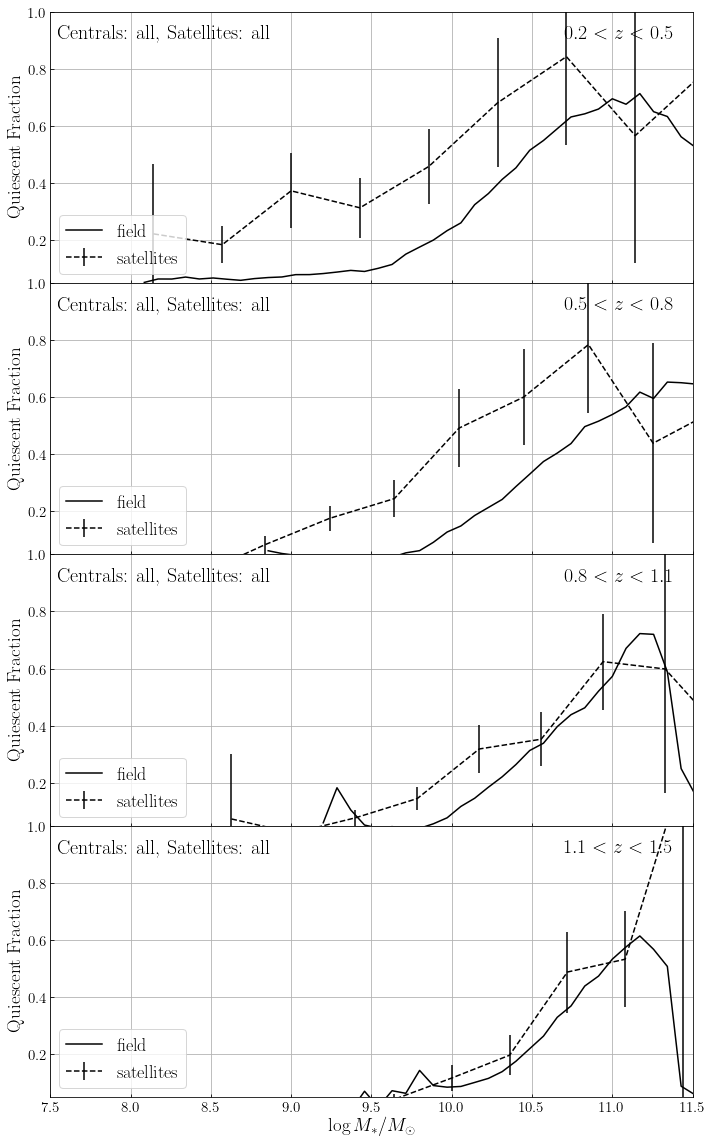

In [1261]:
# compare to the field values
# sat smf
sfq = 'all'
if sfq != 'all':
    ssfq = 's'+sfq
else:
    ssfq = sfq

if sfq == 'sf':
    color = 'b'
    norm_factors = [40,50,80,100]
elif sfq == 'q':
    color = 'r'
    norm_factors = [60,60,70,80]
else:
    color = 'k'
    norm_factors = [40,40,45,50]
    
z_mins = [0.2,0.5,0.8,1.1]
z_maxs = [0.5,0.8,1.1,1.5]
smf_comp_idx = [1,10,14,16]
fig, axs = plt.subplots(4, 1, figsize = (10, 16),sharex=True,sharey=True)

count_type = 'sat'
num_bins = 35 # number of bin edges
    
    
masscut_host=11.2
masscut_host_high=11.5
path = 'smf_pcat/test_smf_cenmass_'+str(masscut_host)+'_'+str(masscut_host_high)+'/'
print(path)

fit_params = []
fit_params_err = []
for i,z in enumerate(z_mins):   
    
    # field Q_frac
    bins_field = np.linspace(8,12.2,50)[:-1]
    smf_all_field = np.load('pcat_smf_nonir_all_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')[0]
    smf_q_field = np.load('pcat_smf_nonir_q_onebin_fc_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')[0]
    qfrac_field = smf_q_field / smf_all_field
    axs[i].plot(bins_field[smf_comp_idx[i]:],qfrac_field[smf_comp_idx[i]:],'-'+color,label='field')
    
    # SSMF Q_frac
    rebin_factor=3
    masscut_low = masscut_lows[i]
    m_bin_left_edges = np.linspace(masscut_low, masscut_high, num=num_bins+1)[:-1]
    m_bin_left_edges = rebin_arr(m_bin_left_edges,factor=rebin_factor)
    print(m_bin_left_edges)
    
    n_centrals,ssmf_all_sat,ssmf_all_inf,ssmf_all_sup = combine_deep_smf(path, 'all', count_type, str(z), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins, relative_cut='r_scale')
    ssmf_all_sat = rebin_arr(ssmf_all_sat,factor=rebin_factor)
    ssmf_all_inf = rebin_arr(ssmf_all_inf,factor=rebin_factor)
    ssmf_all_sup = rebin_arr(ssmf_all_sup,factor=rebin_factor)
    ssmf_all_sat_err = (ssmf_all_sup-ssmf_all_inf)/2/np.sqrt(rebin_factor)
    
    n_centrals,ssmf_q_sat,ssmf_q_inf,ssmf_q_sup = combine_deep_smf(path, 'sq', count_type, str(z), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins, relative_cut='r_scale')
    ssmf_q_sat = rebin_arr(ssmf_q_sat,factor=rebin_factor)
    ssmf_q_inf = rebin_arr(ssmf_q_inf,factor=rebin_factor)
    ssmf_q_sup = rebin_arr(ssmf_q_sup,factor=rebin_factor)
    ssmf_q_sat_err = (ssmf_q_sup-ssmf_q_inf)/2/np.sqrt(rebin_factor)
    
    qfrac_sat = ssmf_q_sat / ssmf_all_sat
    qfrac_sat_err = np.sqrt((ssmf_all_sat_err/ssmf_all_sat)**2+(ssmf_q_sat_err/ssmf_q_sat)**2)*qfrac_sat
    
    axs[i].errorbar(m_bin_left_edges, qfrac_sat, yerr=qfrac_sat_err,fmt='--'+color,label='satellites')
    
    axs[i].annotate('$'+str(round(z_mins[i],1))+'<z<'+str(round(z_maxs[i],1))+'$',xy=([0.8,0.9]),xycoords='axes fraction',fontsize=20,color='k')
    axs[i].annotate('Centrals: '+csfq+', Satellites: '+ssfq,xy=([0.01,0.9]),xycoords='axes fraction',fontsize=20,color='k')
    axs[i].set_xlim([7.5,11.5])
    axs[i].set_ylim([5e-2,1])
    # axs[i].set_yscale('log')
    axs[i].grid()
    axs[i].legend(fontsize=18,loc='lower left')
    axs[3].set_xlabel('$\log M_*/M_\odot$',fontsize=19)
    axs[i].set_ylabel('Quiescent Fraction',fontsize=19)

plt.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
plt.savefig('/Users/lejay/Desktop/smf_paper/ssmf_field_qfrac.png')

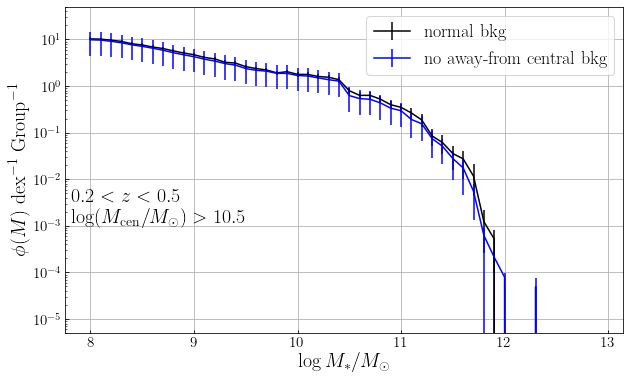

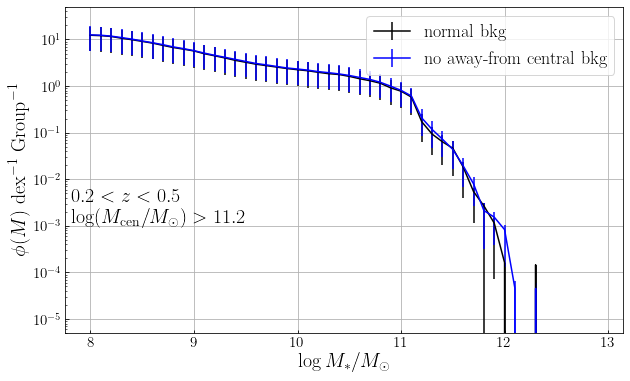

In [288]:
for masscut_host in [10.5,11.2]:
    fig, axs = plt.subplots(1, 1, figsize = (10, 6),sharex=True)
    
    # background strategy tests
    z_mins = [0.2,0.5,0.8,1.1]
    z_maxs = [0.5,0.8,1.1,1.5]
    z_idx = 0
    z_min = z_mins[z_idx]
    z_max = z_maxs[z_idx]
    
    num_bins = 50 # number of bin edges
    m_bin_left_edges = np.linspace(masscut_low, masscut_high, num=num_bins+1)[:-1]
    ssfq='all'
    count_type = 'bkg'
    
    path1 = 'smf_pcat/test_smf_cenmass_'+str(masscut_host)+'/'
    n_centrals, smf_avg, smf_inf, smf_sup = combine_deep_smf(path1, ssfq, count_type, str(z_min), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins, csfq='all')
    axs.errorbar(m_bin_left_edges, smf_avg,yerr=[smf_avg-smf_inf,smf_sup-smf_avg],label='normal bkg',color='k')  
        
    path2 = 'smf_pcat/test_smf_noisobkg_cenmass_'+str(masscut_host)+'/'
    n_centrals, smf_avg, smf_inf, smf_sup = combine_deep_smf(path2, ssfq, count_type, str(z_min), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins, csfq='all')
    axs.errorbar(m_bin_left_edges, smf_avg,yerr=[smf_avg-smf_inf,smf_sup-smf_avg],label='no away-from central bkg',color='b')  
    
    axs.annotate('$'+str(z_mins[z_idx])+'<z<'+str(z_maxs[z_idx])+'$',xy=([0.01,0.40]),xycoords='axes fraction',fontsize=20,color='k')
    axs.annotate('$\log(M_\mathrm{cen}/M_\odot)>'+str(masscut_host)+'$',xy=([0.01,0.33]),xycoords='axes fraction',fontsize=20,color='k')
    
    plt.yscale('log')
    plt.legend(fontsize=18)
    plt.ylim([5e-6,50])
    plt.grid()
    axs.set_xlabel('$\log M_*/M_\odot$',fontsize=20)
    axs.set_ylabel(r'$\phi(M)~\mathrm{dex}^{-1} ~\mathrm{Group}^{-1}$',fontsize=20)

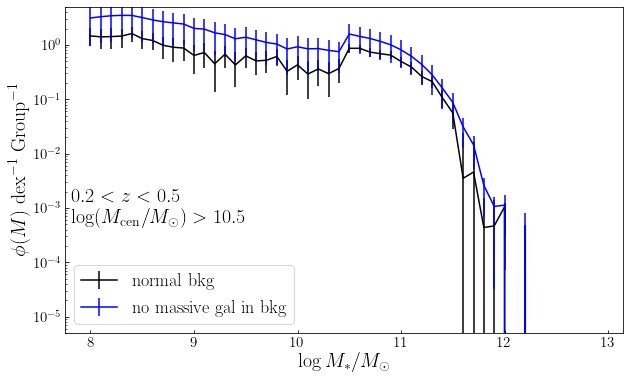

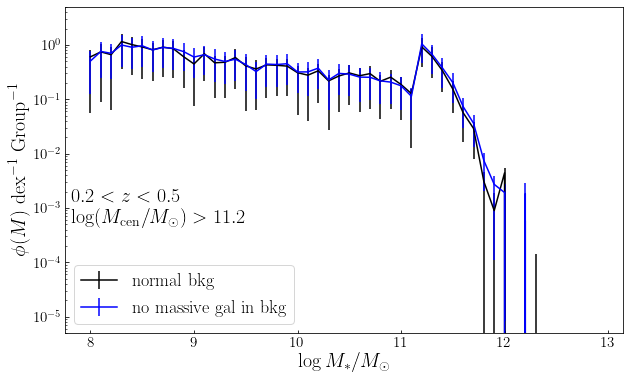

In [285]:
for masscut_host in [10.5,11.2]:
    fig, axs = plt.subplots(1, 1, figsize = (10, 6),sharex=True)
    
    # background strategy tests
    z_mins = [0.2,0.5,0.8,1.1]
    z_maxs = [0.5,0.8,1.1,1.5]
    z_idx = 0
    z_min = z_mins[z_idx]
    z_max = z_maxs[z_idx]
    
    num_bins = 50 # number of bin edges
    m_bin_left_edges = np.linspace(masscut_low, masscut_high, num=num_bins+1)[:-1]
    ssfq='all'
    count_type = 'sat'
    
    path1 = 'smf_pcat/test_smf_cenmass_'+str(masscut_host)+'/'
    n_centrals, smf_avg, smf_inf, smf_sup = combine_deep_smf(path1, ssfq, count_type, str(z_min), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins, csfq='all')
    axs.errorbar(m_bin_left_edges, smf_avg,yerr=[smf_avg-smf_inf,smf_sup-smf_avg],label='normal bkg',color='k')  
        
    path2 = 'smf_pcat/test_smf_nomassivebkg_cenmass_'+str(masscut_host)+'/'
    n_centrals, smf_avg, smf_inf, smf_sup = combine_deep_smf(path2, ssfq, count_type, str(z_min), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins, csfq='all')
    axs.errorbar(m_bin_left_edges, smf_avg,yerr=[smf_avg-smf_inf,smf_sup-smf_avg],label='no massive gal in bkg',color='b')  
    
    axs.annotate('$'+str(z_mins[z_idx])+'<z<'+str(z_maxs[z_idx])+'$',xy=([0.01,0.40]),xycoords='axes fraction',fontsize=20,color='k')
    axs.annotate('$\log(M_\mathrm{cen}/M_\odot)>'+str(masscut_host)+'$',xy=([0.01,0.33]),xycoords='axes fraction',fontsize=20,color='k')
    
    plt.yscale('log')
    plt.legend(fontsize=18)
    plt.ylim([5e-6,5])
    axs.set_xlabel('$\log M_*/M_\odot$',fontsize=20)
    axs.set_ylabel(r'$\phi(M)~\mathrm{dex}^{-1} ~\mathrm{Group}^{-1}$',fontsize=20)

number of centrals 1131.0
number of bkgs 1131.0
number of centrals 1131.0


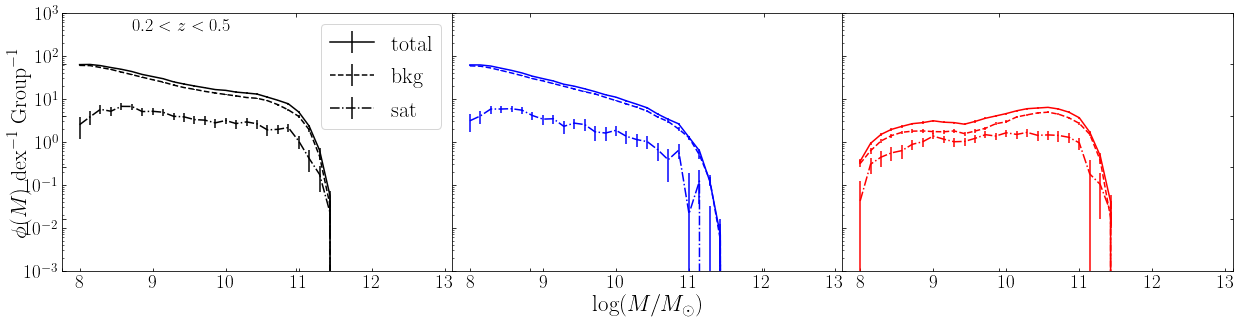

In [428]:
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=19), plt.rc('ytick', labelsize=19)
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(18,5))

z_mins = [0.2,0.5,0.8,1.1]
z_maxs = [0.5,0.8,1.1,1.5]
z_idx = 0
z_min = z_mins[z_idx]
z_max = z_maxs[z_idx]

masscut_low = masscut_lows[z_idx]
num_bins = 35 # number of bin edges
bin_edges = np.linspace(masscut_low, masscut_high, num=num_bins+1)[:-1]
bin_size = bin_edges[1] - bin_edges[0]

low_r='0.0'; high_r='0.7'
masscut_host = 11.2
masscut_host_high = 11.5
path = 'smf_pcat/test_smf_cenmass_'+str(masscut_host)+'_'+str(masscut_host_high)+'/'

#load data
all_total = combine_deep_smf(path, 'all', 'total', str(z_min), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins, relative_cut='r_scale')
all_bkg = combine_deep_smf(path, 'all', 'bkg', str(z_min), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins, relative_cut='r_scale')
all_sat = combine_deep_smf(path, 'all', 'sat', str(z_min), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins, relative_cut='r_scale')

sf_total = combine_deep_smf(path, 'ssf', 'total', str(z_min), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins, relative_cut='r_scale')
sf_bkg = combine_deep_smf(path, 'ssf', 'bkg', str(z_min), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins, relative_cut='r_scale')
sf_sat = combine_deep_smf(path, 'ssf', 'sat', str(z_min), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins, relative_cut='r_scale')

q_total = combine_deep_smf(path, 'sq', 'total', str(z_min), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins, relative_cut='r_scale')
q_bkg = combine_deep_smf(path, 'sq', 'bkg', str(z_min), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins, relative_cut='r_scale')
q_sat = combine_deep_smf(path, 'sq', 'sat', str(z_min), masscut_low=str(masscut_low),masscut_host=str(masscut_host),bin_number=num_bins, relative_cut='r_scale')

# all
print('number of centrals',all_total[0])
print('number of bkgs',all_bkg[0])
print('number of centrals',all_sat[0])

error_all = [(all_total[1]-all_total[2])/bin_size, (all_total[3]-all_total[1])/bin_size]
error_bkg = [(all_bkg[1]-all_bkg[2])/bin_size, (all_bkg[3]-all_bkg[1])/bin_size]
error_sat = [(all_sat[1]-all_sat[2])/bin_size, (all_sat[3]-all_sat[1])/bin_size]
axs[0].errorbar(bin_edges, all_total[1]/bin_size,yerr=error_all,fmt='k',label='total')
axs[0].errorbar(bin_edges, all_bkg[1]/bin_size,yerr=error_bkg,fmt='--k',label='bkg')
axs[0].errorbar(bin_edges, all_sat[1]/bin_size,yerr=error_sat,fmt='-.k',label='sat')
axs[0].annotate(r'$'+str(z_min)+'<z<'+str(z_max)+'$',xy=([0.18,0.93]),xycoords='axes fraction',fontsize=18,color='k')

#sf
error_sf = [(sf_total[1]-sf_total[2])/bin_size, (sf_total[3]-sf_total[1])/bin_size]
error_sf_bkg = [(sf_bkg[1]-sf_bkg[2])/bin_size, (sf_bkg[3]-sf_bkg[1])/bin_size]
error_sf_sat = [(sf_sat[1]-sf_sat[2])/bin_size, (sf_sat[3]-sf_sat[1])/bin_size]
axs[1].errorbar(bin_edges, sf_total[1]/bin_size,yerr=error_sf,fmt='b')
axs[1].errorbar(bin_edges, sf_bkg[1]/bin_size,yerr=error_sf_bkg,fmt='--b')
axs[1].errorbar(bin_edges, sf_sat[1]/bin_size,yerr=error_sf_sat,fmt='-.b')

#q
error_q = [(q_total[1]-q_total[2])/bin_size, (q_total[3]-q_total[1])/bin_size]
error_q_bkg = [(q_bkg[1]-q_bkg[2])/bin_size, (q_bkg[3]-q_bkg[1])/bin_size]
error_q_sat = [(q_sat[1]-q_sat[2])/bin_size, (q_sat[3]-q_sat[1])/bin_size]

axs[2].errorbar(bin_edges, q_total[1]/bin_size,yerr=error_q,fmt='r')
axs[2].errorbar(bin_edges, q_bkg[1]/bin_size,yerr=error_q_bkg,fmt='--r')
axs[2].errorbar(bin_edges, q_sat[1]/bin_size,yerr=error_q_sat,fmt='-.r')

axs[0].set_yscale('log')
axs[0].set_ylim([1e-3,1e3])
axs[0].legend(fontsize=22)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.xlabel(r'$\log(M/M_\odot)$', fontsize=23)
plt.ylabel(r'$\phi(M)~\mathrm{dex}^{-1} ~\mathrm{Group}^{-1}$', fontsize=22)

plt.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
plt.savefig('/Users/lejay/Desktop/smf_paper/ssmf_total_sat_bkg.png')

#### spatial completeness 

#### catalog from Angelo

In [147]:
cat = Table.read('/Users/lejay/research/massive_gals/cluster_cats/COSMOS_z005_R3000_sig2_N100_specz_241107.fits')

# select centrals
cluster_IDs = np.unique(cat['cluster_ID'])

for cluster_ID in cluster_IDs:
    cat_cluster = cat[cat['cluster_ID'] == cluster_ID]
    cat_cluster = cat_cluster[cat_cluster['mem_prob']>0.15]
    central_gal = cat_cluster[cat_cluster['mem_prob']==100]
    print(cluster_ID,central_gal['ID'][0],len(cat_cluster)-1)

DUD_103 42094416122372119 112
DUD_104 43163553741434914 179
DUD_62 44218380529459079 62
DUD_72 44223470065698963 76
DUD_74 43159022550933820 114
DUD_77 42089876341945470 59
DUD_78 43159026845895392 136
DUD_82 43158876522059780 170
DUD_83 44223186597867377 72
DUD_89 43158580169290315 170
DUD_96 43158335356161222 69
DUD_97 44222499403111638 115


#### speed test on cosmological calculators

In [252]:
from cosmic_calc import *
from astropy.cosmology import *
from astropy.cosmology import WMAP9
import time

In [265]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
cosmo.comoving_volume(1)

<Quantity 1.511e+11 Mpc3>

In [245]:
t1 = time.time()
v = []
for z in np.arange(0,20,0.01):
    v.append(cosmo.comoving_volume(z).value)
t2 = time.time()
print(t2-t1)

0.13830184936523438


In [246]:
t1 = time.time()
v2 = []
for z in np.arange(0,20,0.01):
    v2.append(cosmic_calc(z,H0=70,WM=0.3,WV=0.7))
t2 = time.time()
print(t2-t1)

4.75600528717041


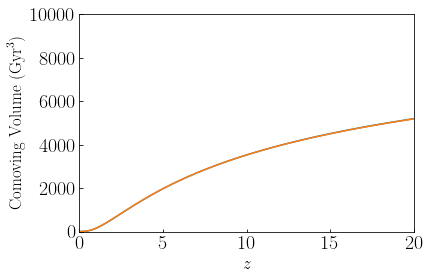

In [248]:
plt.plot(np.arange(0,20,0.01),np.array(v)/1e9)
plt.plot(np.arange(0,20,0.01),np.array(v2))

plt.xlim(0,20)
plt.ylim(0,10000)
plt.xlabel('$z$',fontsize=17)
plt.ylabel('Comoving Volume ($\mathrm{Gyr}^3$)',fontsize=17)
plt.show()

In [264]:
# check (proper scale) kpc-->arcsec scale

cosmo2 = FlatLambdaCDM(H0=70, Om0=0.3)
print(1/cosmo2.arcsec_per_kpc_proper(1).value)

dis = WMAP9.angular_diameter_distance(1).value
print(1/3600/180*np.pi*dis*1e3)

8.008707025690136
8.152313264896698


In [272]:
# angular size in degrees for 700 kpc circle

r_iso = 0.7 # Mpc
print(r_iso/cosmo.angular_diameter_distance(1).value/np.pi*180)
print(r_iso*1e3*cosmo.arcsec_per_kpc_proper(1).value/3600)

0.024279130678736313
0.024279130678736313


In [359]:
# cat = Table.read('/Users/lejay/research/lephare_dev/my_code/graham_output_cats_new/pcat_COSMOS_deep_cat_out_nomaglimit_nonir_il_nz_prior_formass_sfq_added.fits')
cat = Table.read('/Users/lejay/Desktop/COSMOS_galaxies_241104.fits')
cat_name = 'COSMOS'

In [360]:
zkeyname = 'Z_COMBINE'
mass_keyname = 'MASS_MED'
id_keyname = 'ID'
ra_key = 'RA'
dec_key = 'DEC'
z_min = 1.1
z_max = 1.5

In [363]:
if 'XMM' not in cat_name:
    cat = cat[cat['inside_u'] == True]
else:
    cat = cat[cat['inside_uS_deep'] == True]
    cat = cat[cat['inside_j'] == True]
cat = cat[cat['inside_hsc'] == True]
cat = cat[cat['isStar']==False]
cat = cat[cat['inside_hsc'] == True]
cat = cat[cat['isCompact']==False]
cat = cat[cat['i_compact_flag']==False]
cat = cat[cat['snr_i']>3]
cat = cat[cat['snr_r']>1.5]
cat = cat[cat['snr_z']>1.5]
cat_gal = cat[cat['i_cmodel']>0]
cat_gal = cat_gal[cat_gal[zkeyname] < 2.0]
# cat_gal = cat_gal[cat_gal[sfq_keyname] >= 0.0]
# cat_gal = cat_gal[cat_gal[sfq_keyname] <= 1.0]
print(z_min,z_max)
print(cat_name,len(cat_gal))

1.1 1.5
COSMOS 1118609
